# Model Development

In [35]:
# Stdlib
import os

# Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import GroupKFold, RandomizedSearchCV
from sklearn.metrics import (
    classification_report,
    r2_score,
    mean_squared_error,
)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# XGBoost
from xgboost import XGBClassifier, XGBRegressor

# SciPy
from scipy.stats import randint, uniform, pearsonr, spearmanr
from scipy.special import expit  # sigmoid

# Utilities
import joblib
from scipy.signal import medfilt

import joblib
from xgboost import XGBClassifier
from scipy.stats import randint, uniform


In [36]:
# Path to your saved pickle
pkl_path = "data/processed/zscores_df.pkl"

zscores_df = pd.read_pickle(pkl_path)

## Classification Models


--- Fold 1 ---
Train Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4237
           1       0.96      0.58      0.72       330

    accuracy                           0.97      4567
   macro avg       0.97      0.79      0.85      4567
weighted avg       0.97      0.97      0.96      4567

Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       997
           1       0.90      0.36      0.52       143

    accuracy                           0.91      1140
   macro avg       0.91      0.68      0.74      1140
weighted avg       0.91      0.91      0.90      1140



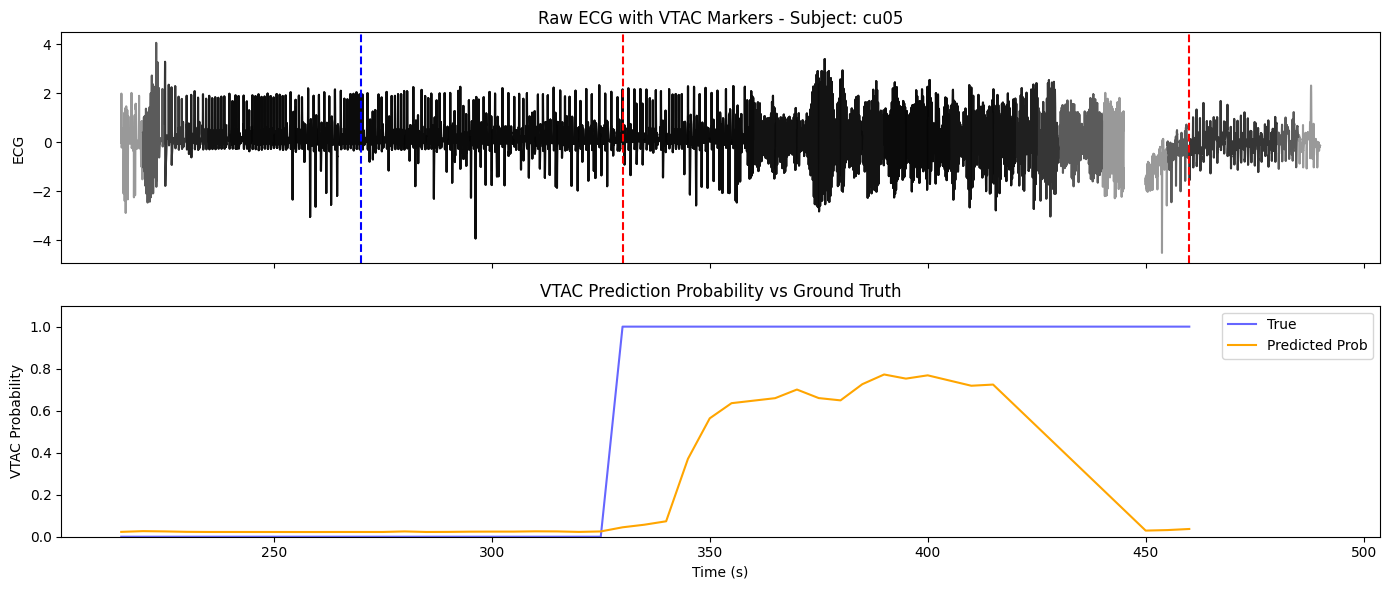

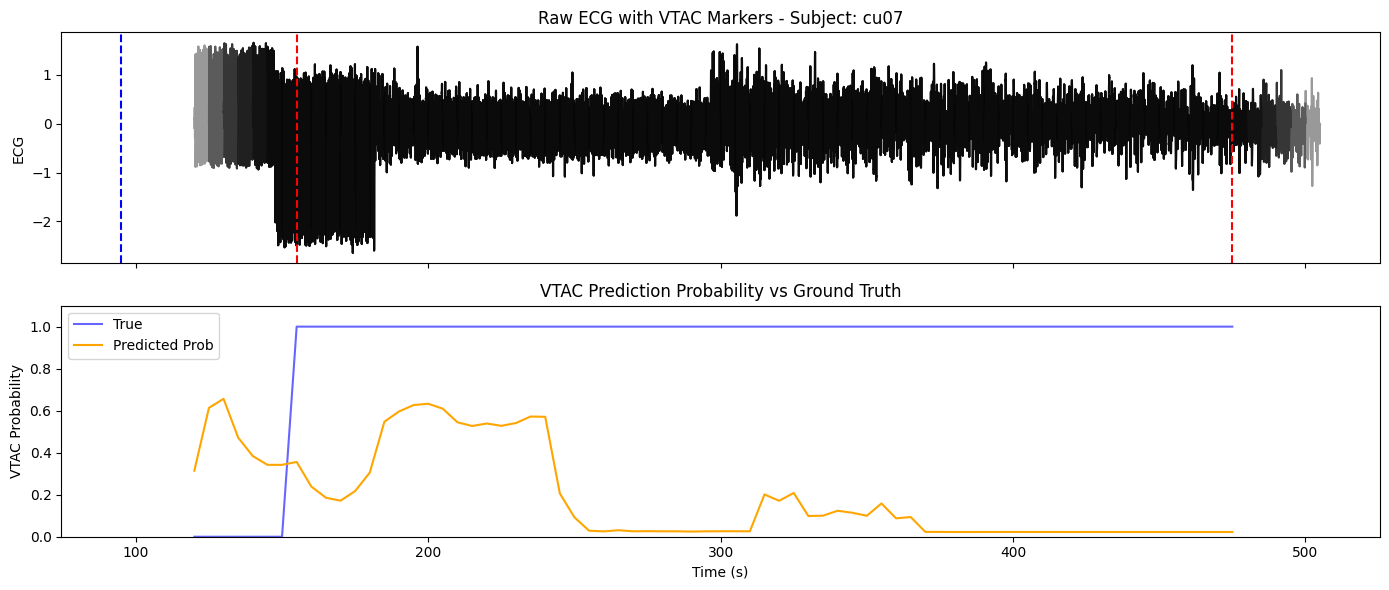

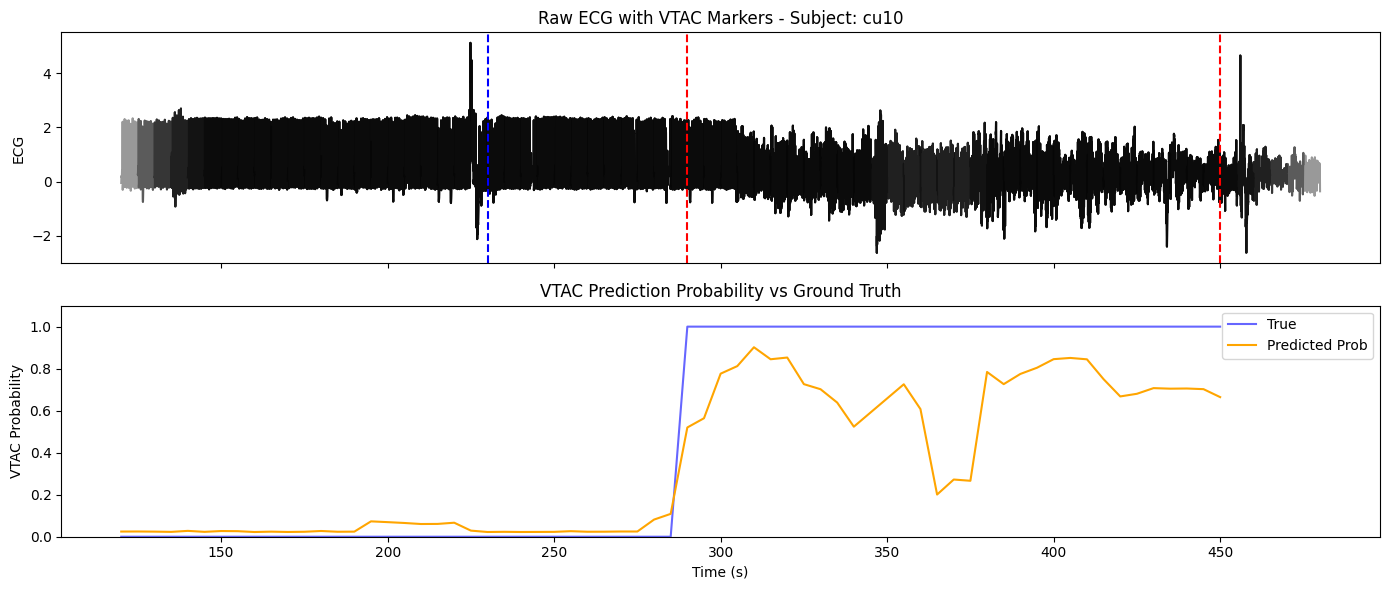

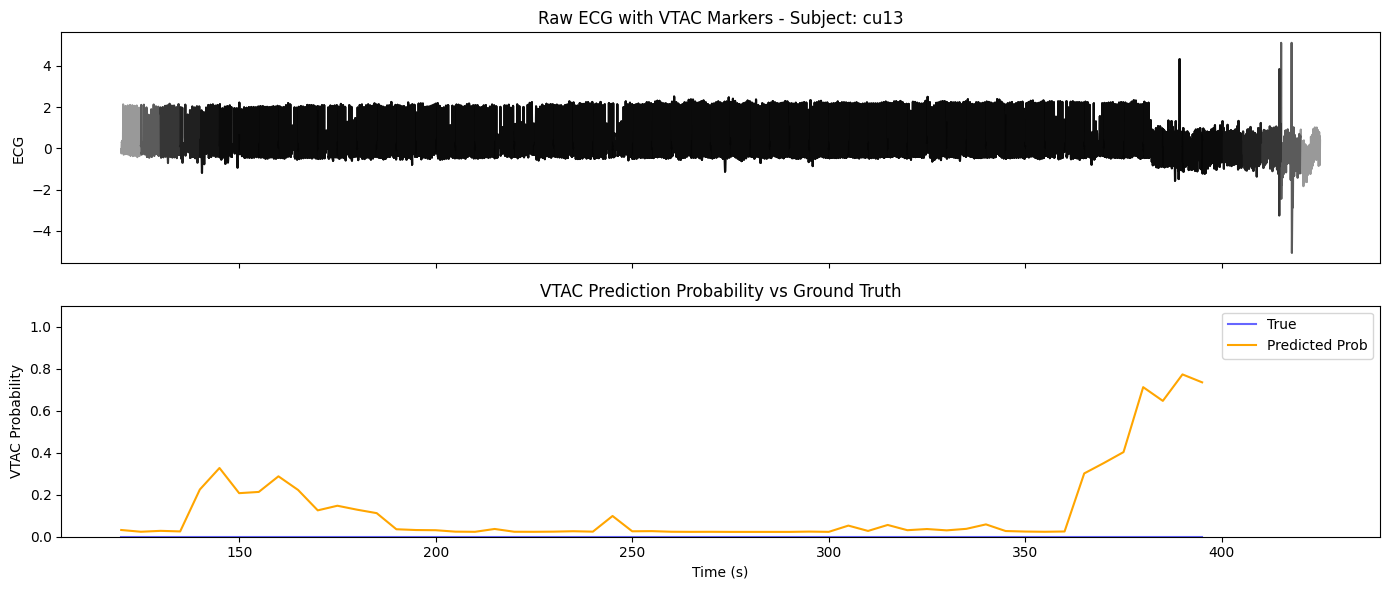

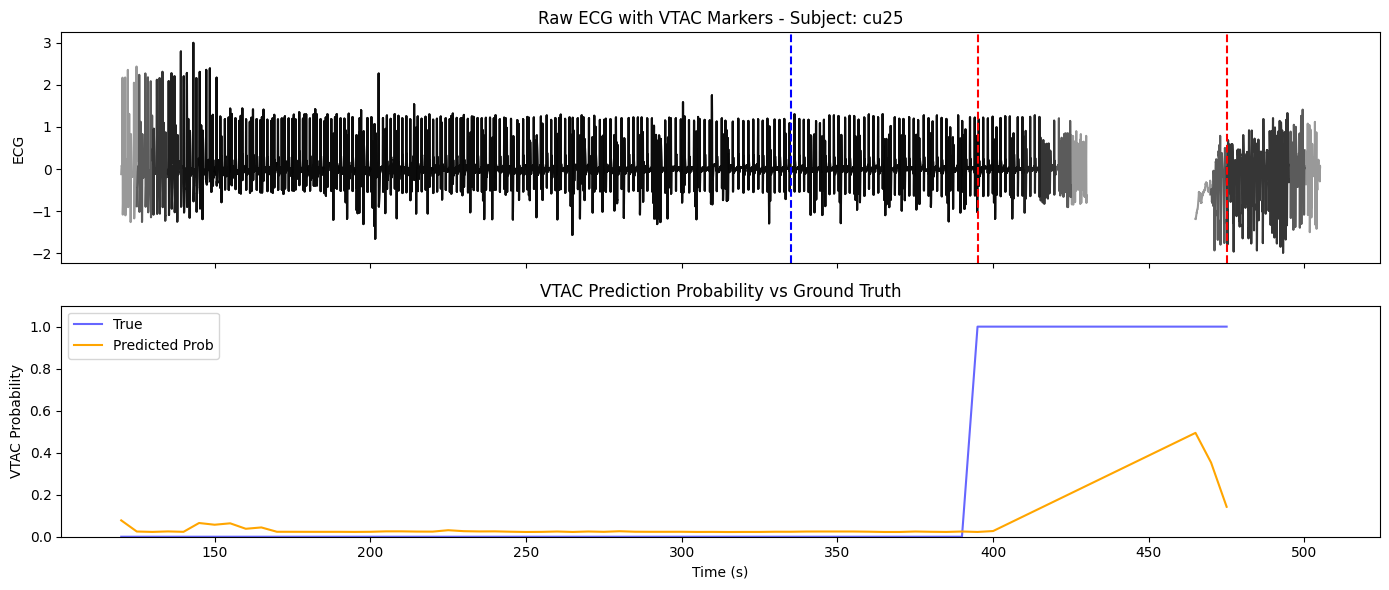

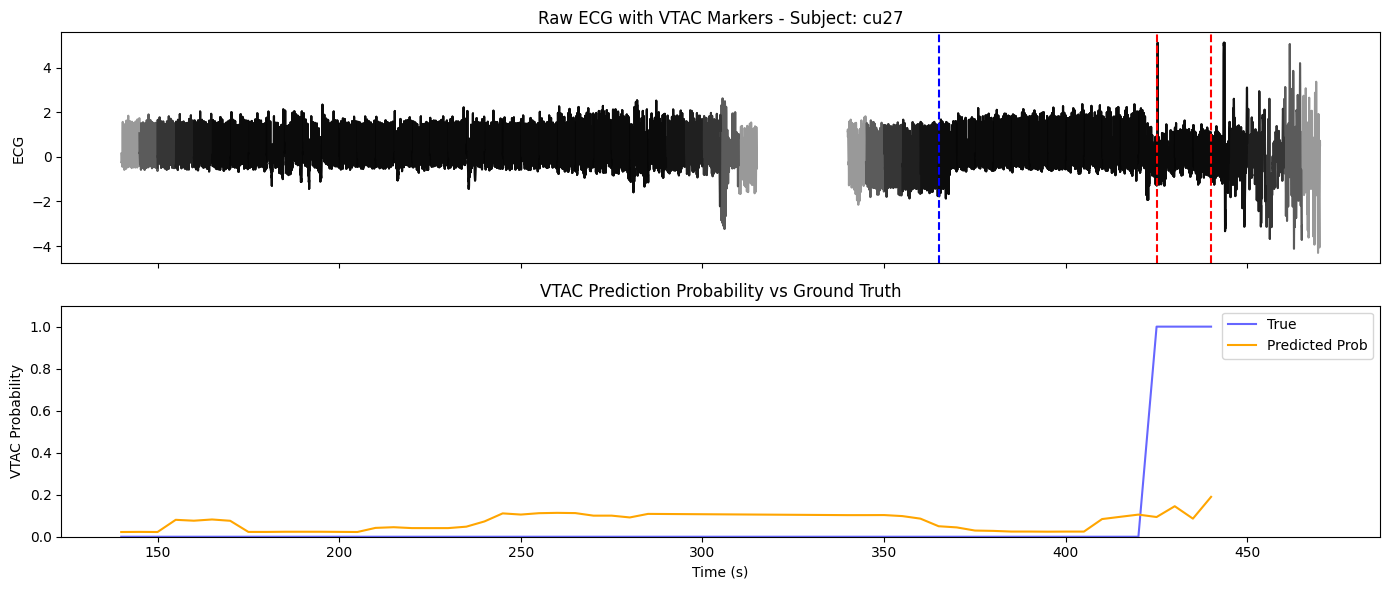

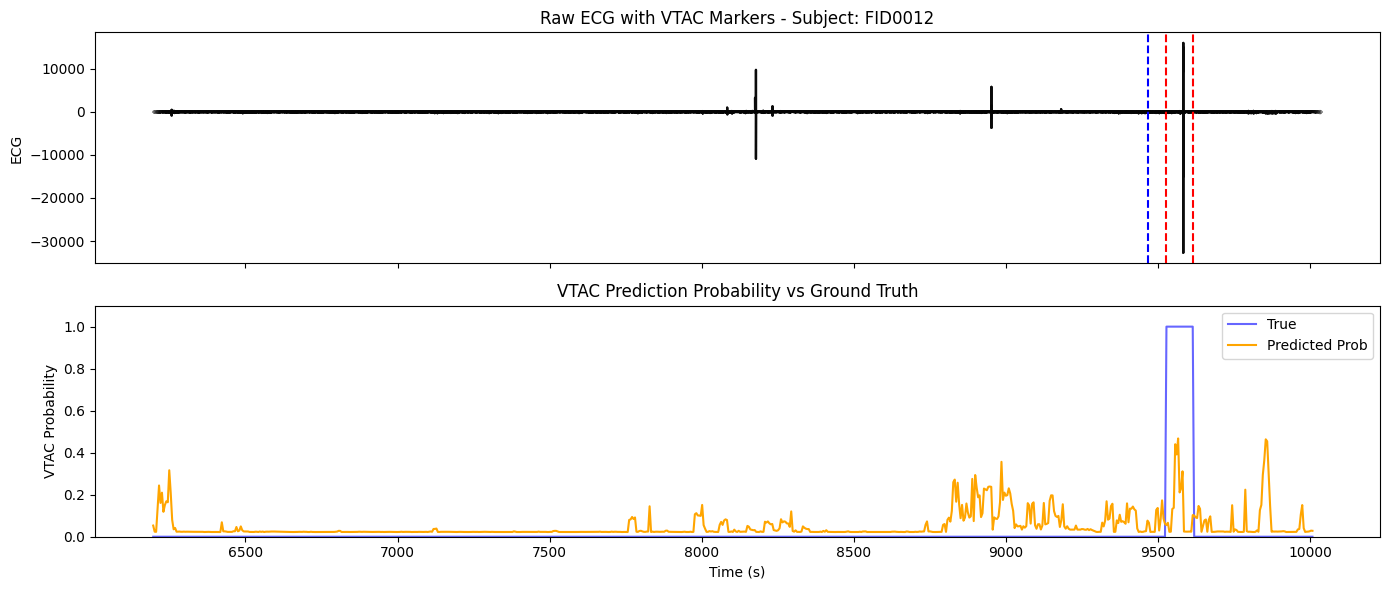


--- Fold 2 ---
Train Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4173
           1       0.98      0.54      0.69       394

    accuracy                           0.96      4567
   macro avg       0.97      0.77      0.84      4567
weighted avg       0.96      0.96      0.95      4567

Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1061
           1       0.68      0.41      0.51        79

    accuracy                           0.95      1140
   macro avg       0.82      0.70      0.74      1140
weighted avg       0.94      0.95      0.94      1140



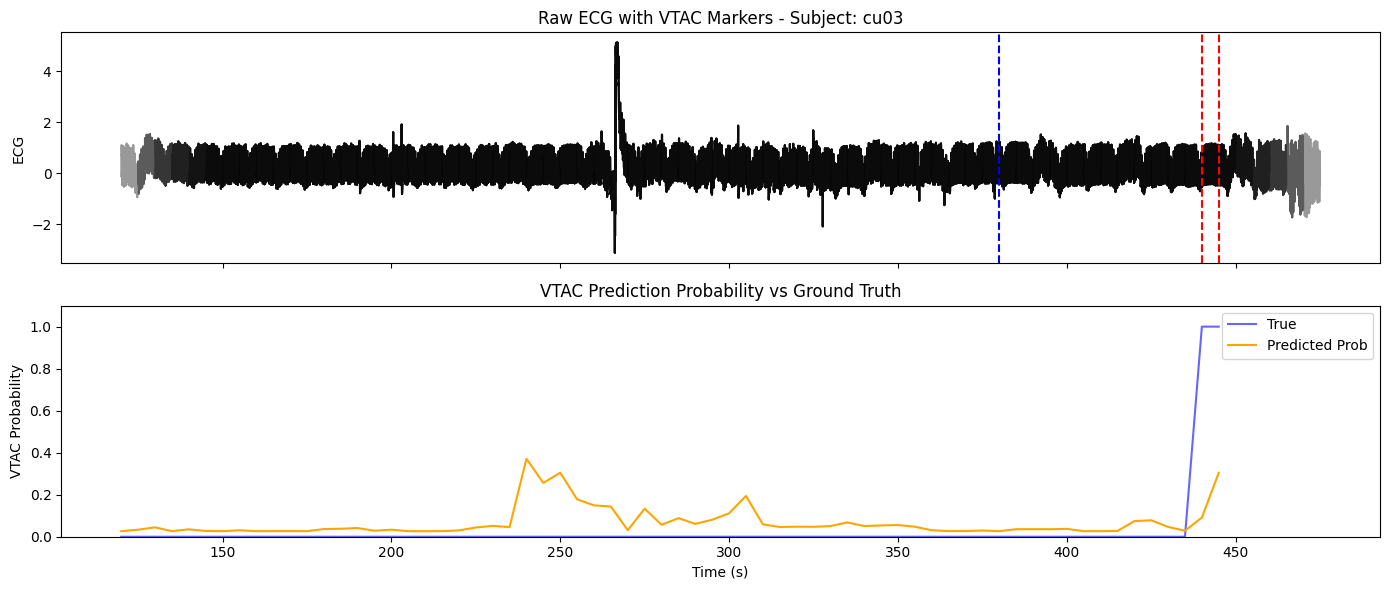

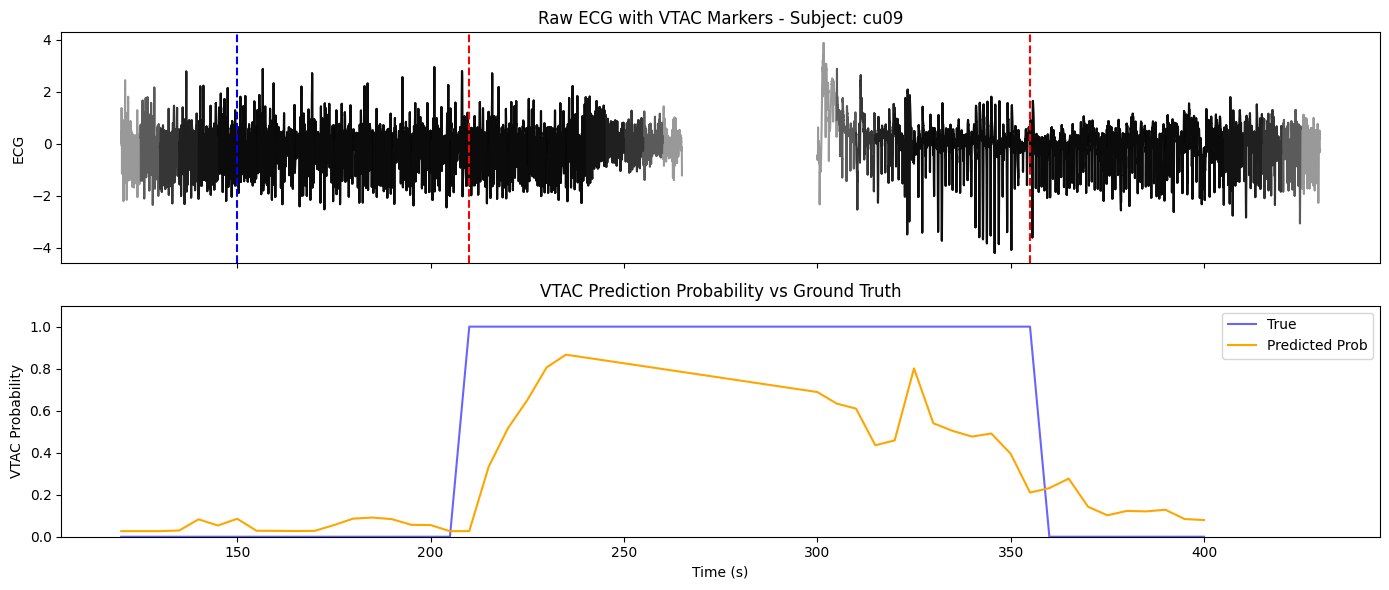

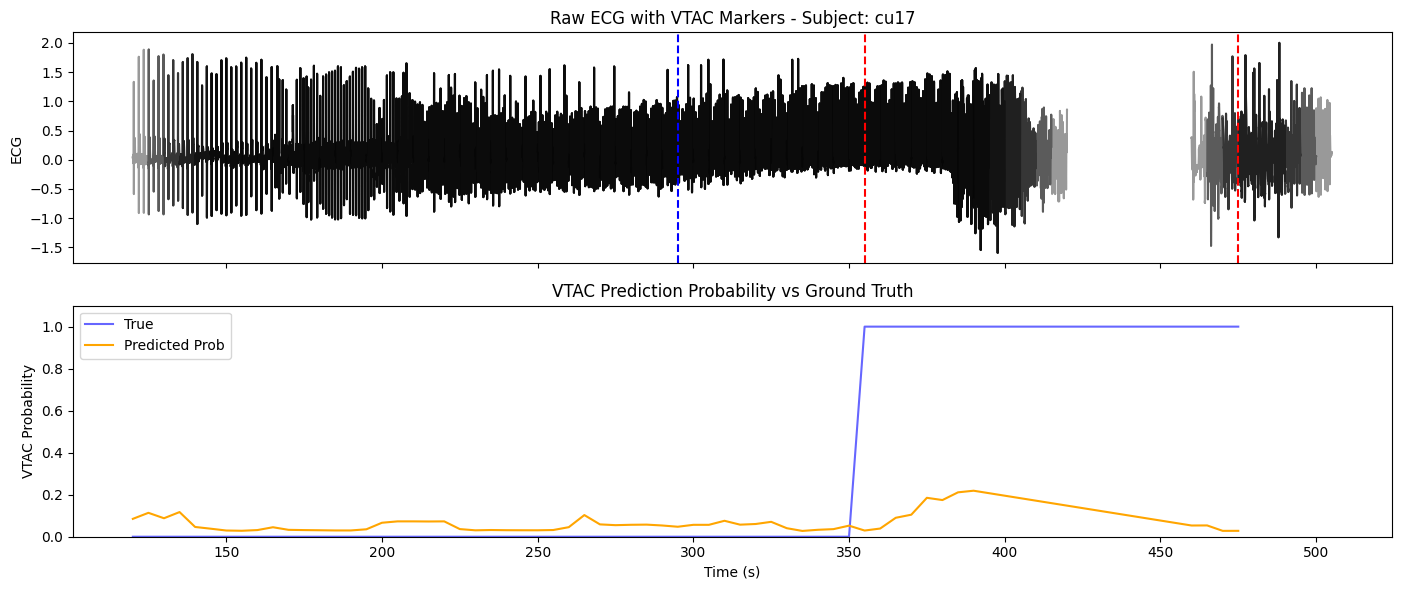

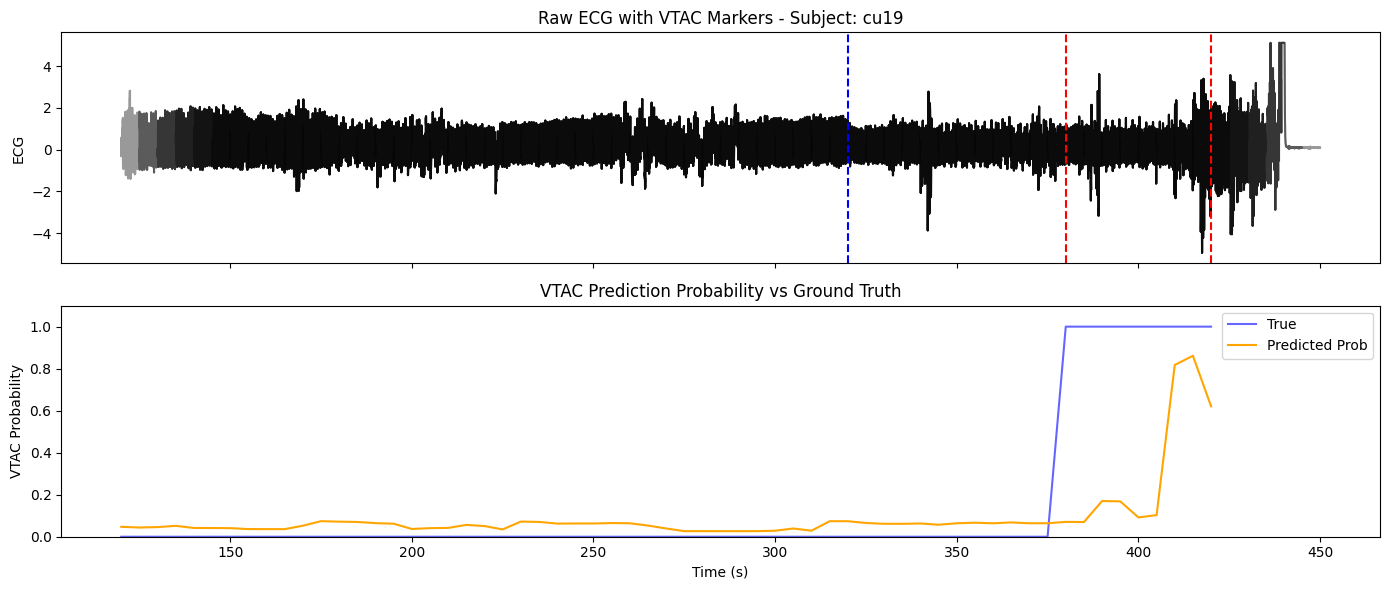

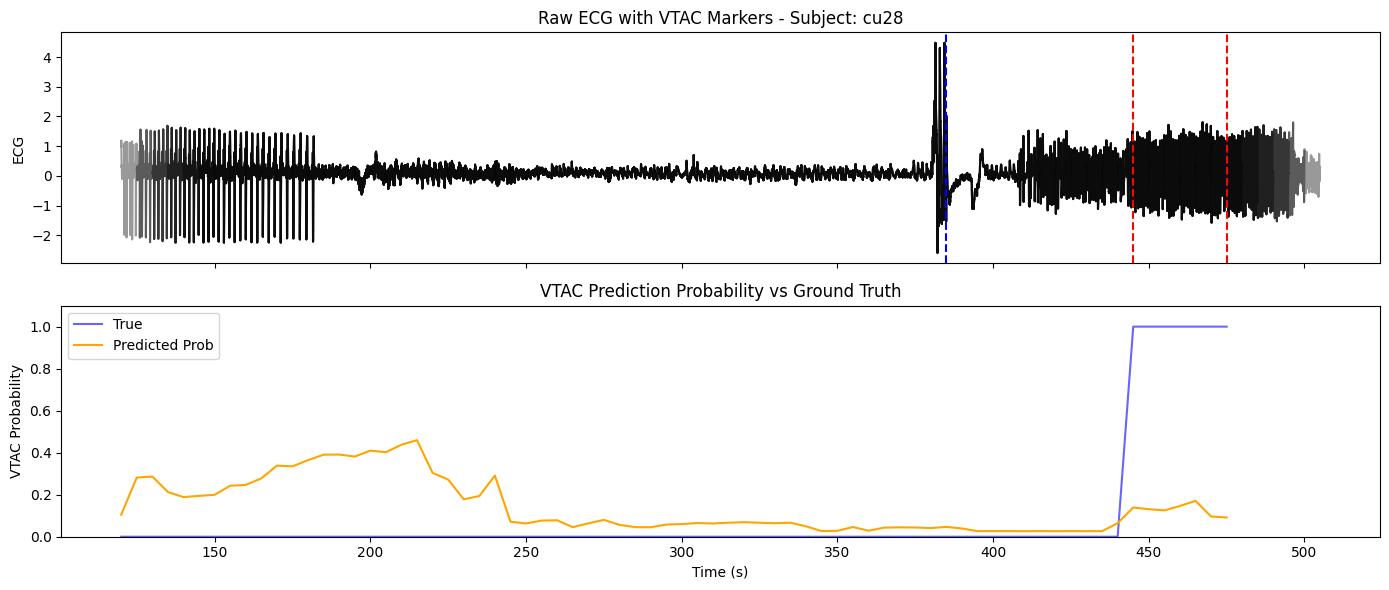

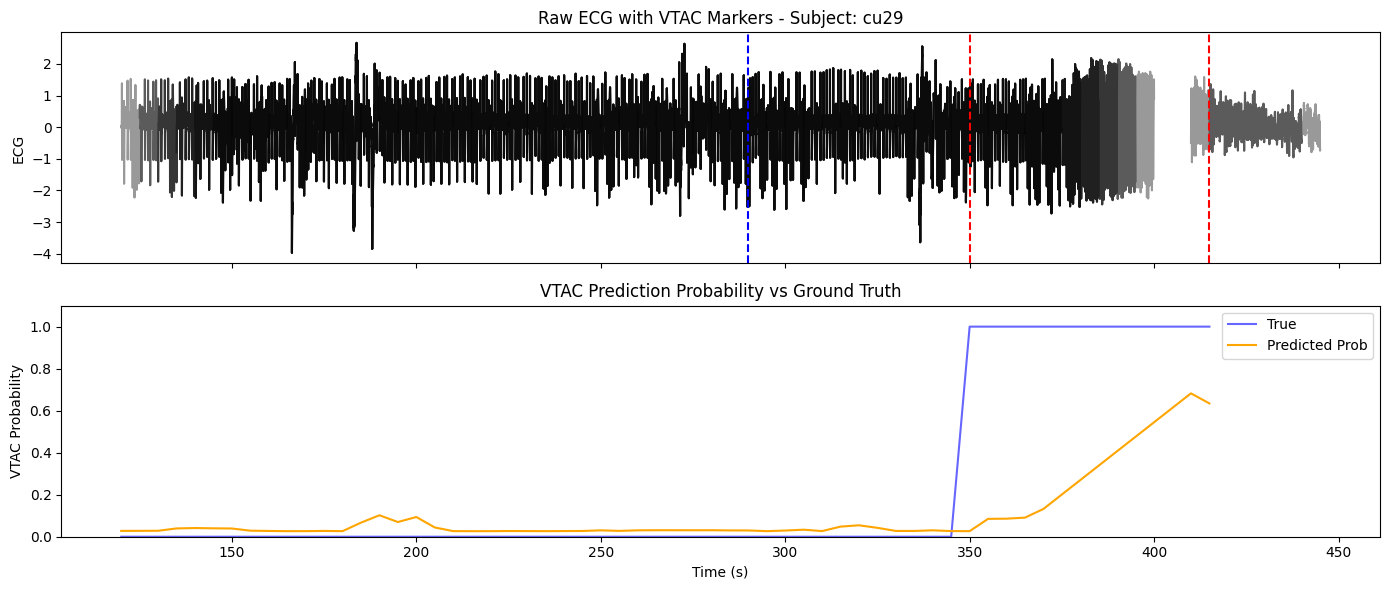

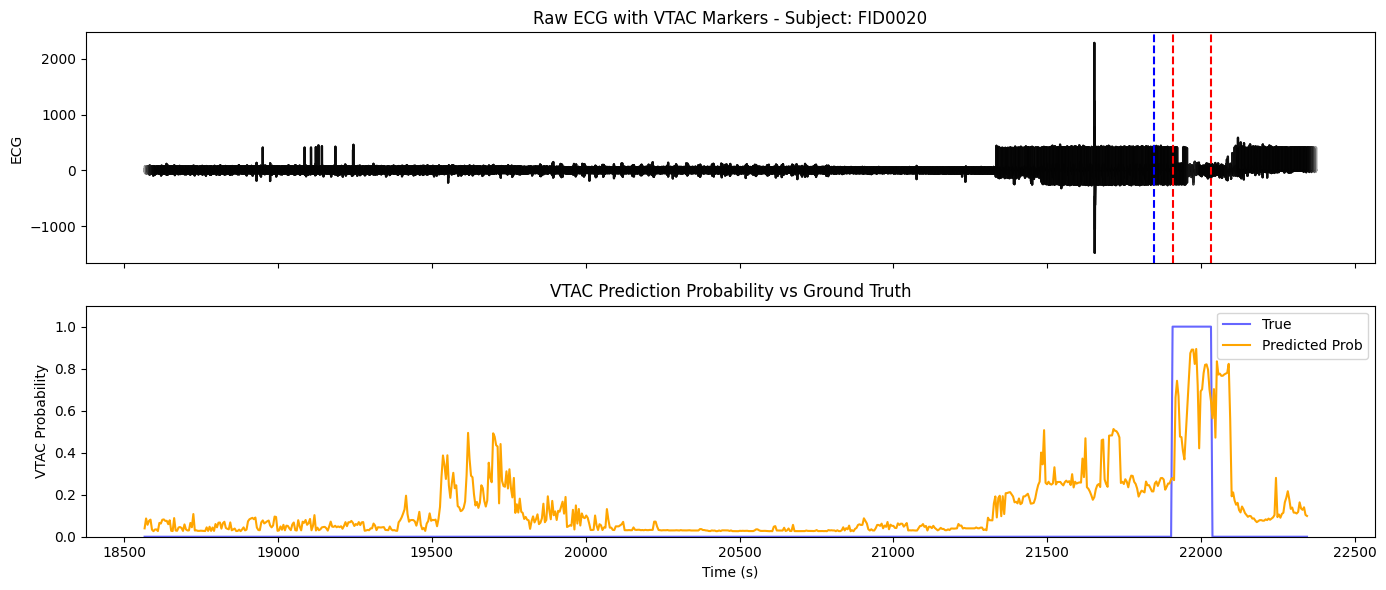


--- Fold 3 ---
Train Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4223
           1       0.98      0.52      0.68       354

    accuracy                           0.96      4577
   macro avg       0.97      0.76      0.83      4577
weighted avg       0.96      0.96      0.96      4577

Test Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1011
           1       0.98      0.36      0.53       119

    accuracy                           0.93      1130
   macro avg       0.95      0.68      0.75      1130
weighted avg       0.93      0.93      0.92      1130



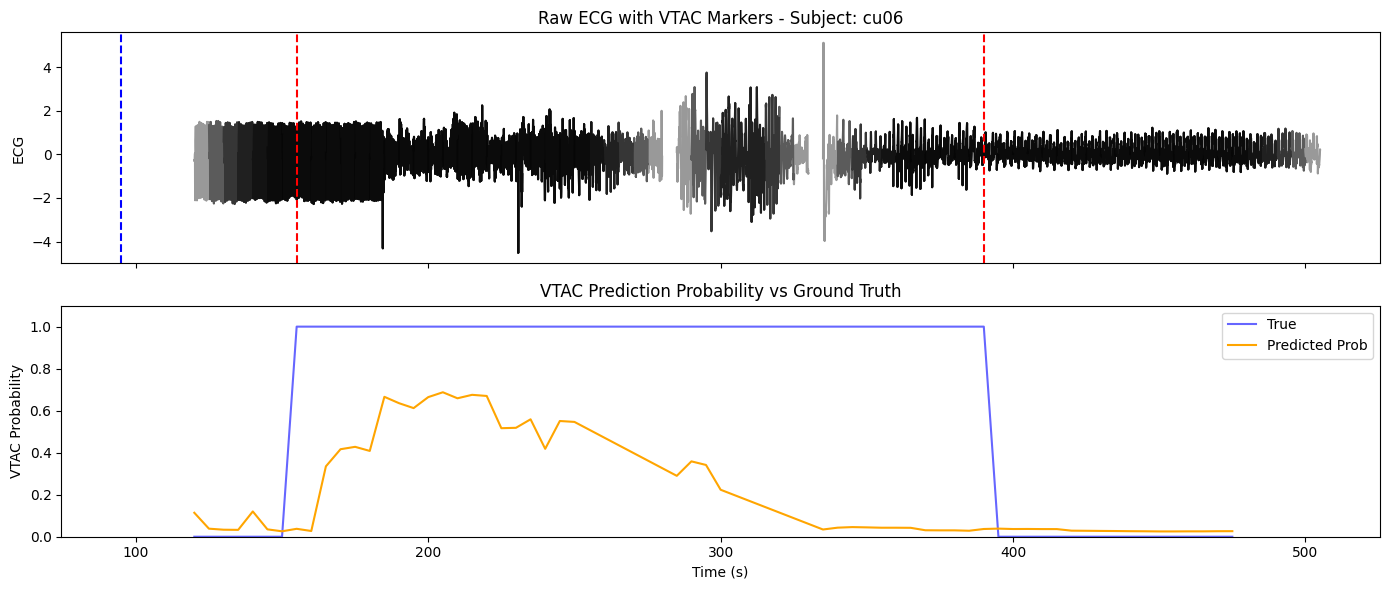

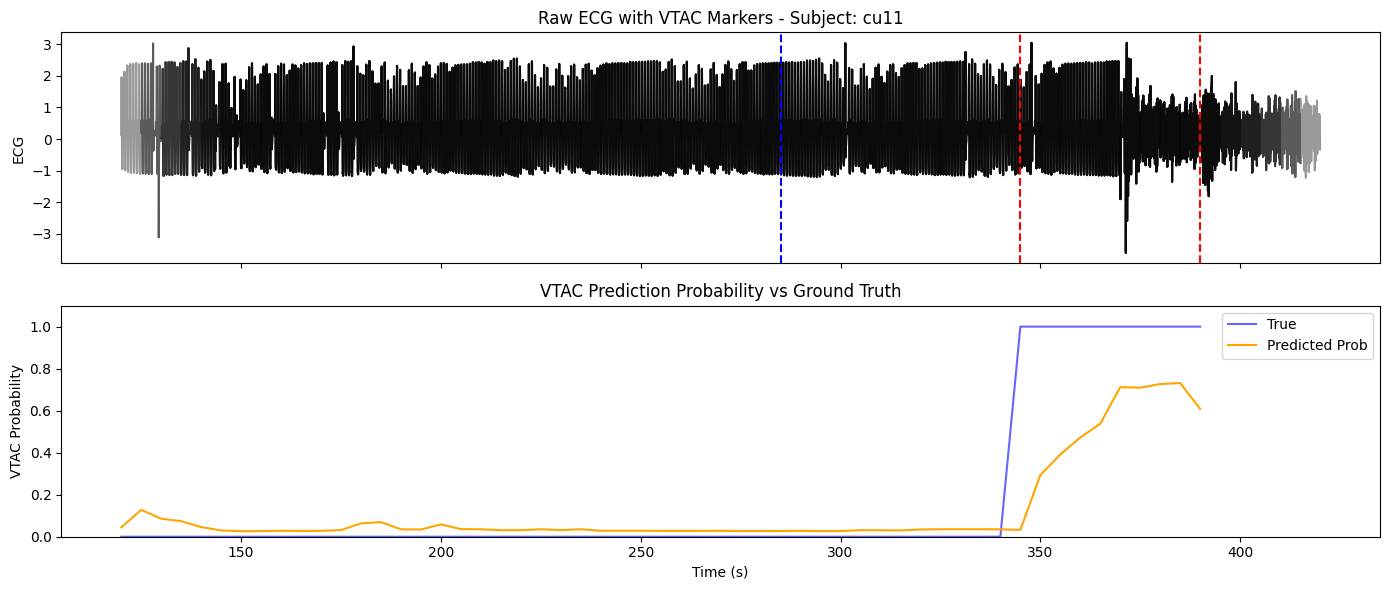

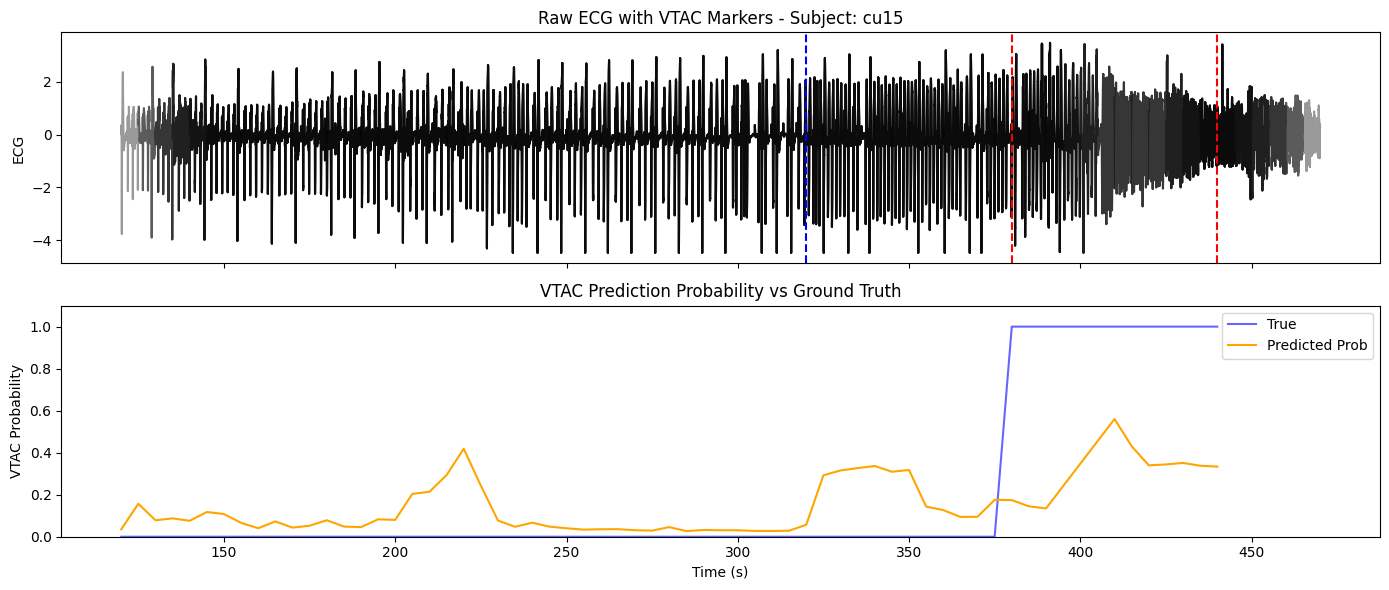

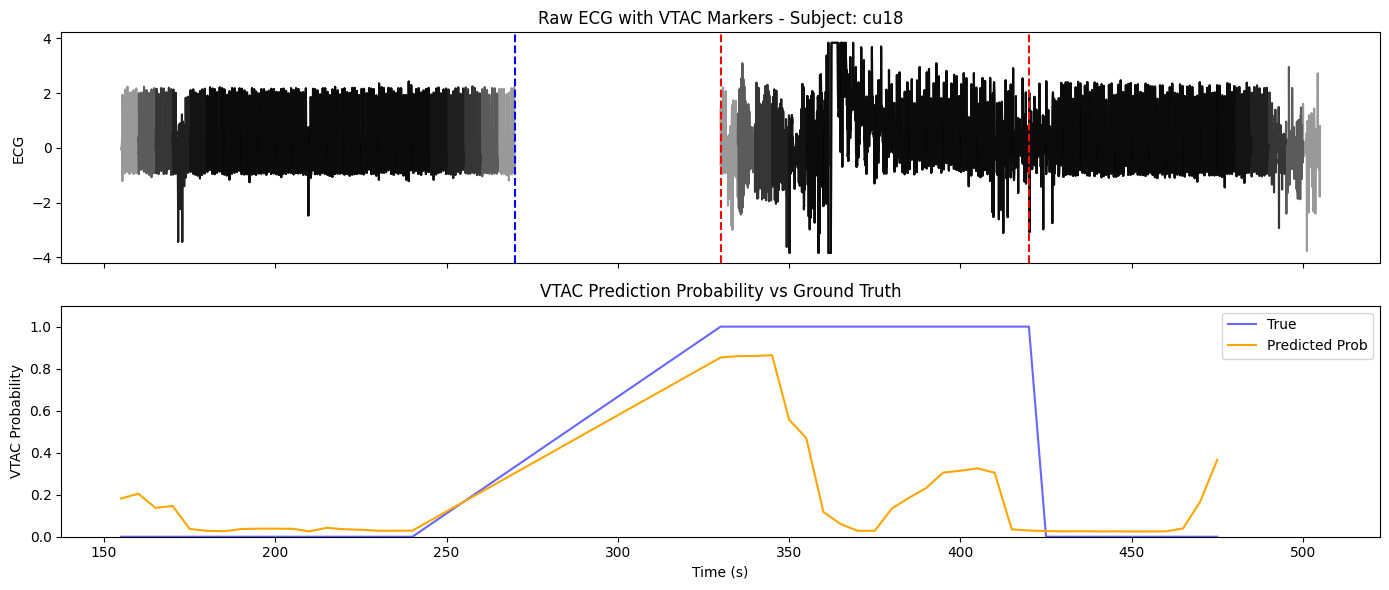

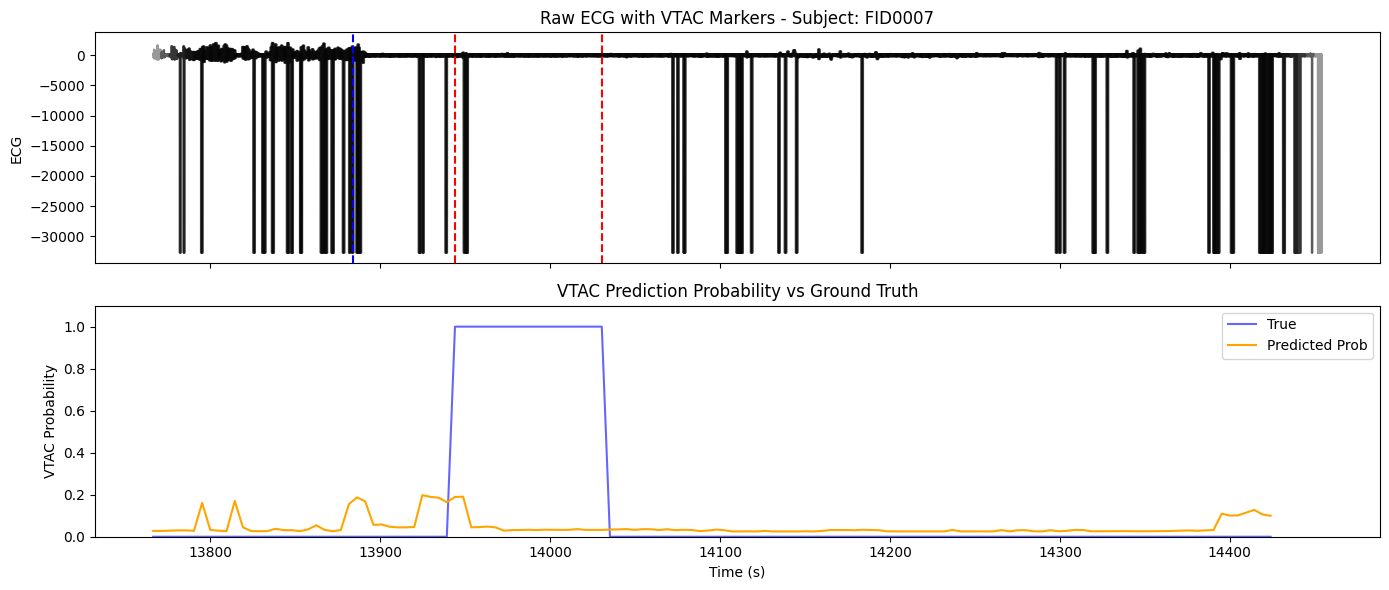

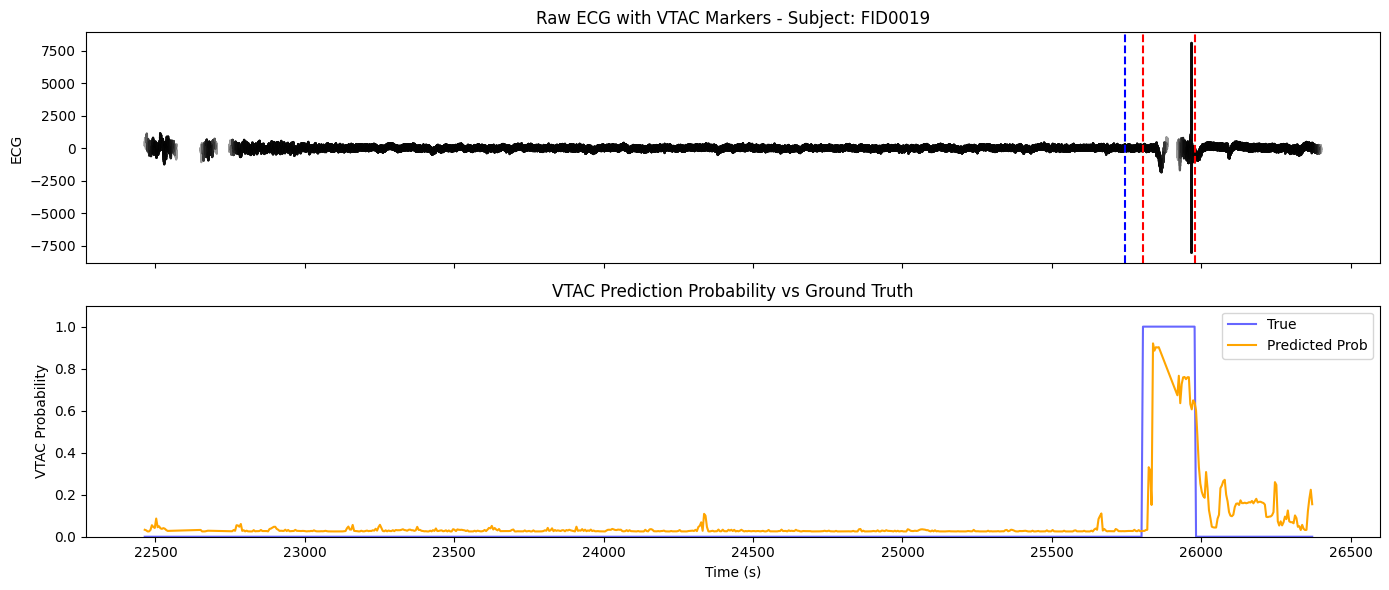


--- Fold 4 ---
Train Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4148
           1       1.00      0.53      0.70       402

    accuracy                           0.96      4550
   macro avg       0.98      0.77      0.84      4550
weighted avg       0.96      0.96      0.95      4550

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1086
           1       0.49      0.46      0.48        71

    accuracy                           0.94      1157
   macro avg       0.73      0.72      0.72      1157
weighted avg       0.94      0.94      0.94      1157



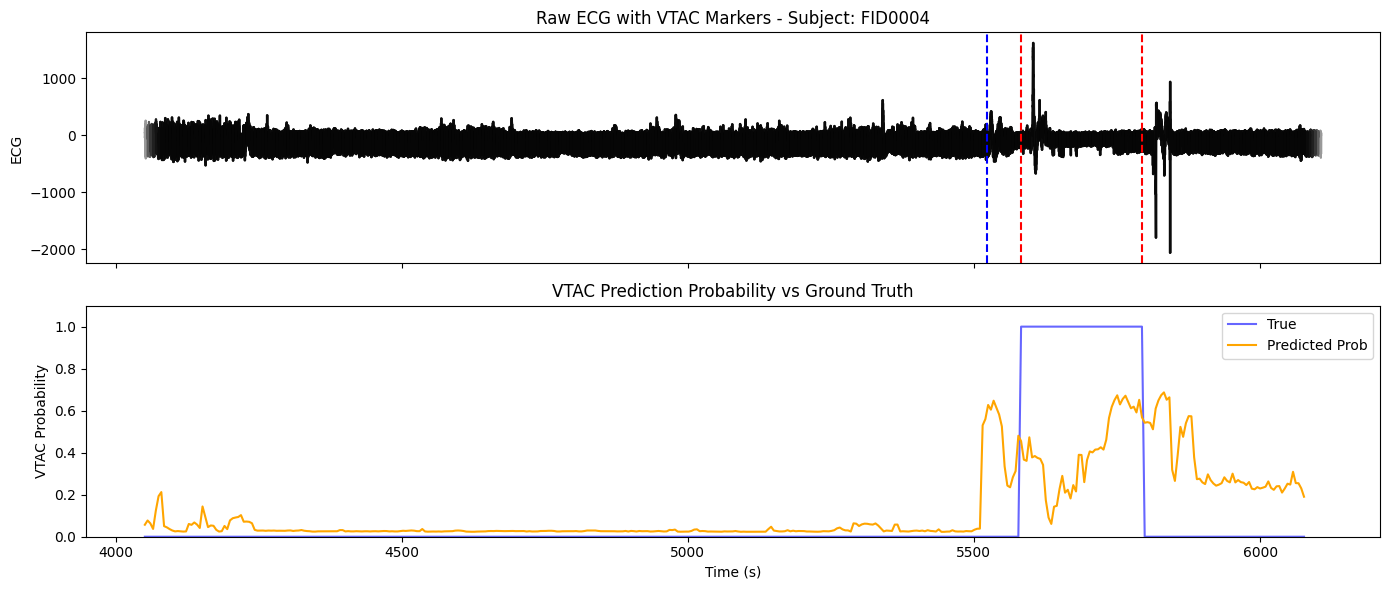

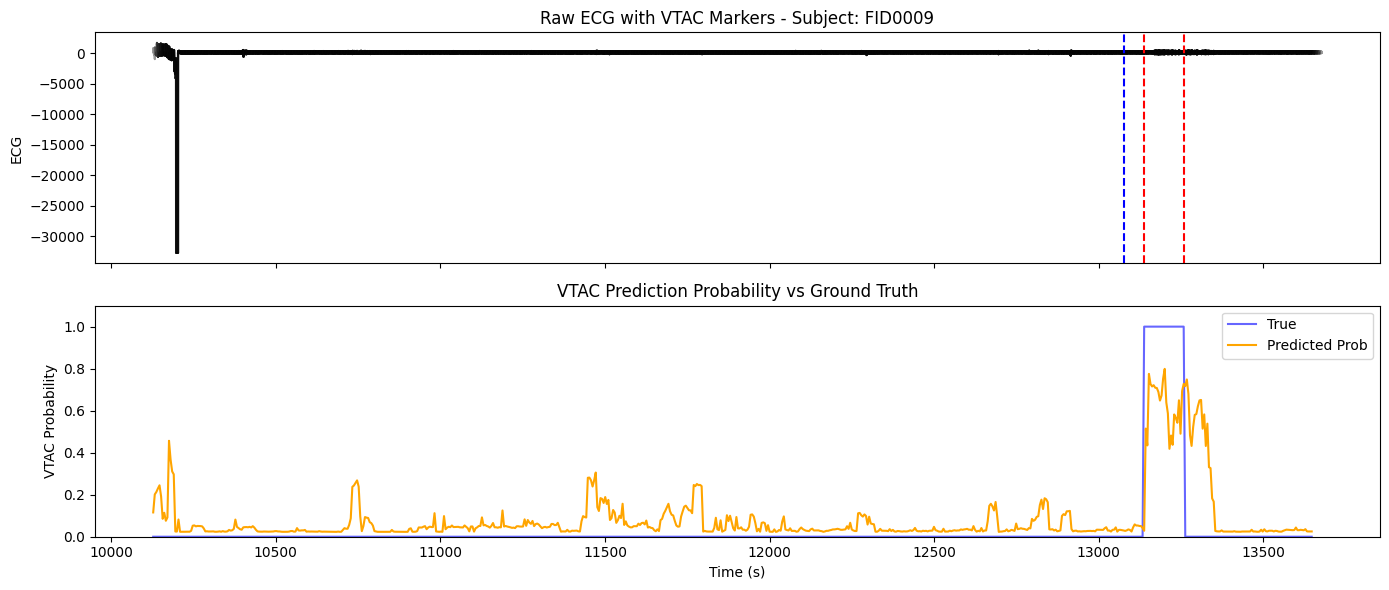


--- Fold 5 ---
Train Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4155
           1       0.96      0.53      0.69       412

    accuracy                           0.96      4567
   macro avg       0.96      0.76      0.83      4567
weighted avg       0.96      0.96      0.95      4567

Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1079
           1       0.90      0.31      0.46        61

    accuracy                           0.96      1140
   macro avg       0.93      0.65      0.72      1140
weighted avg       0.96      0.96      0.95      1140



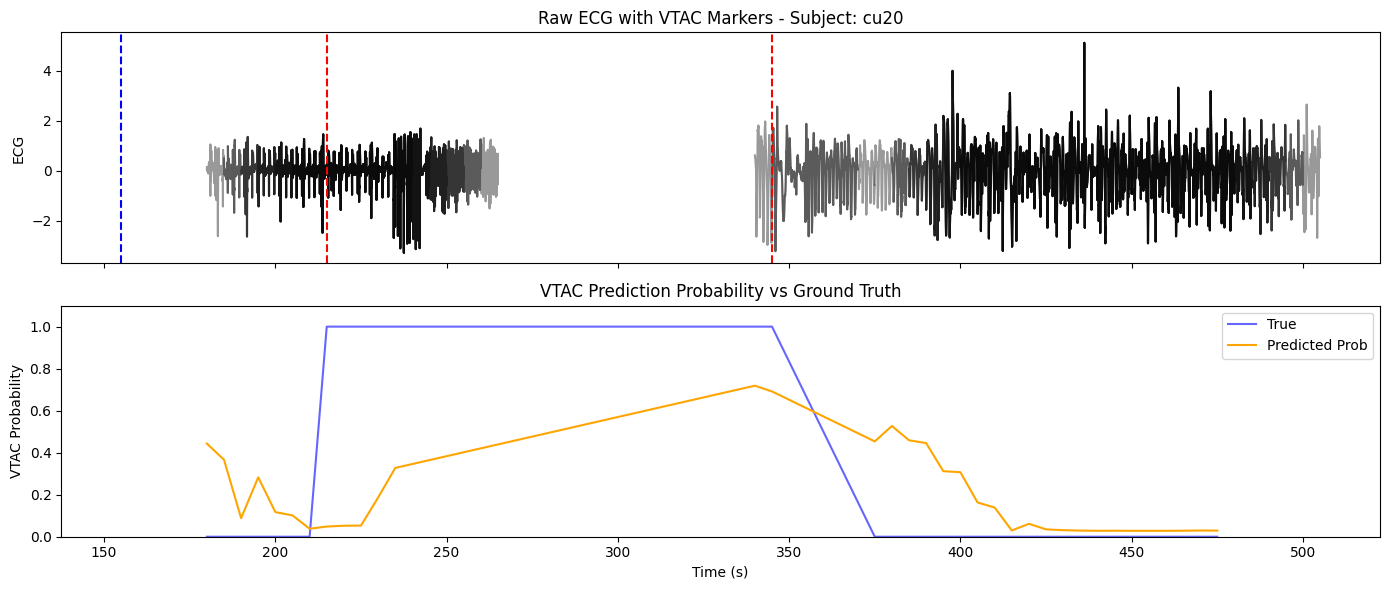

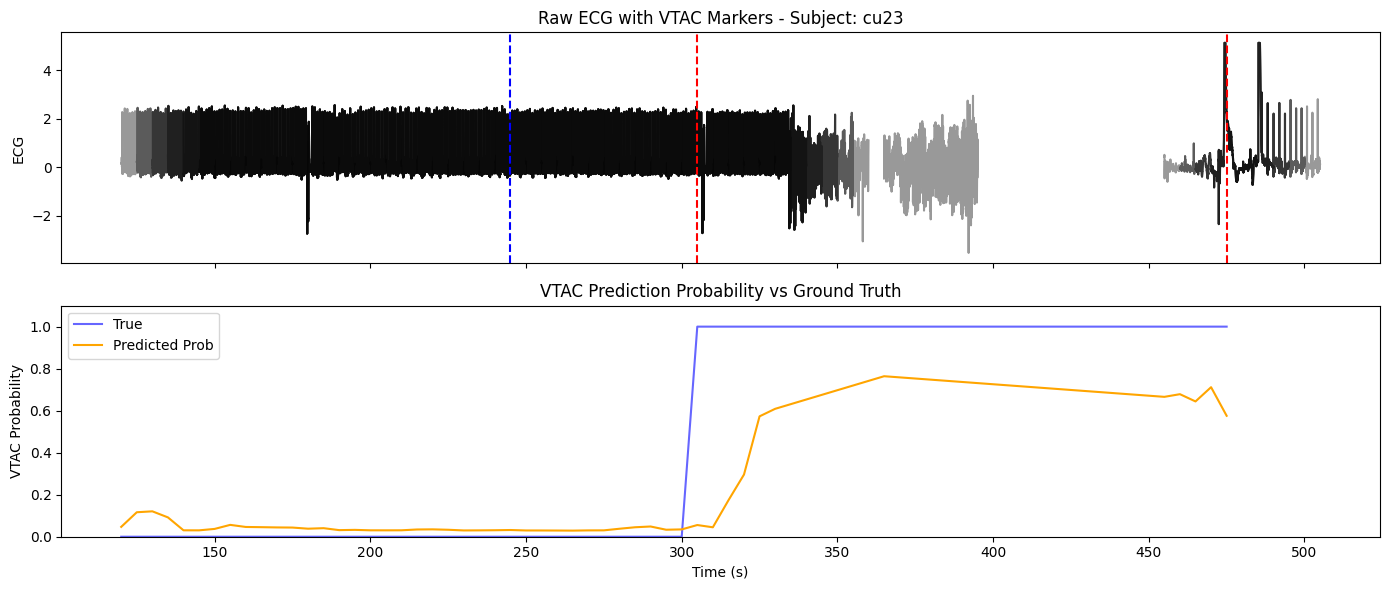

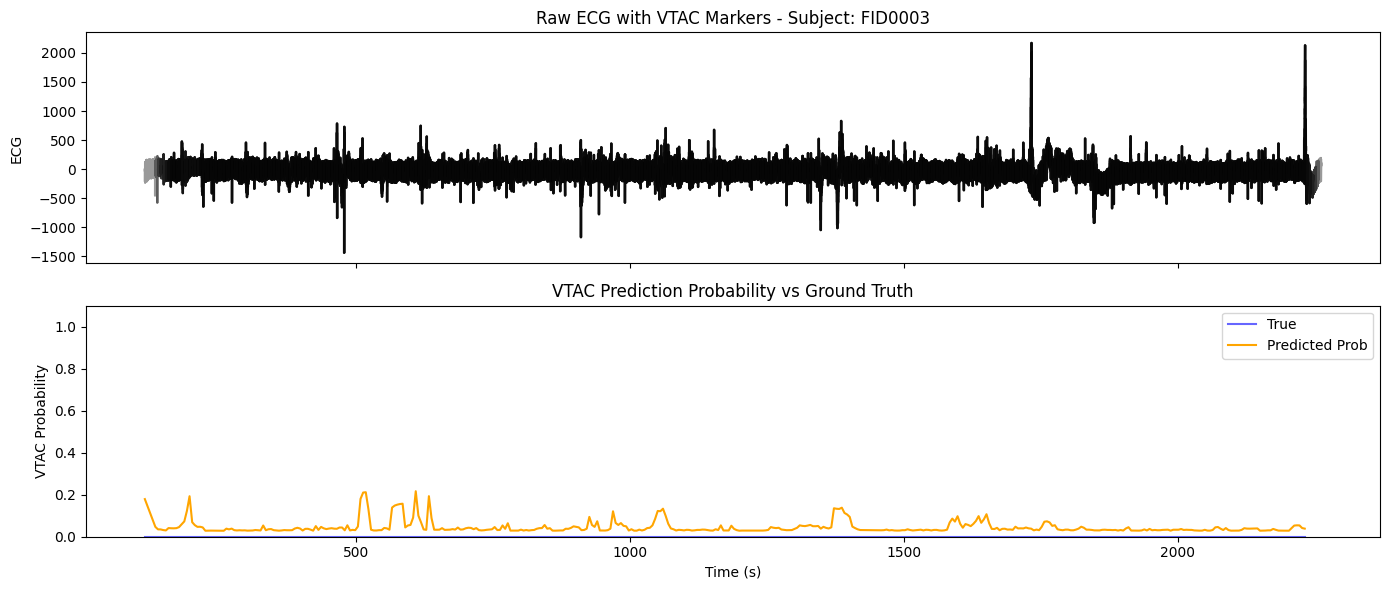

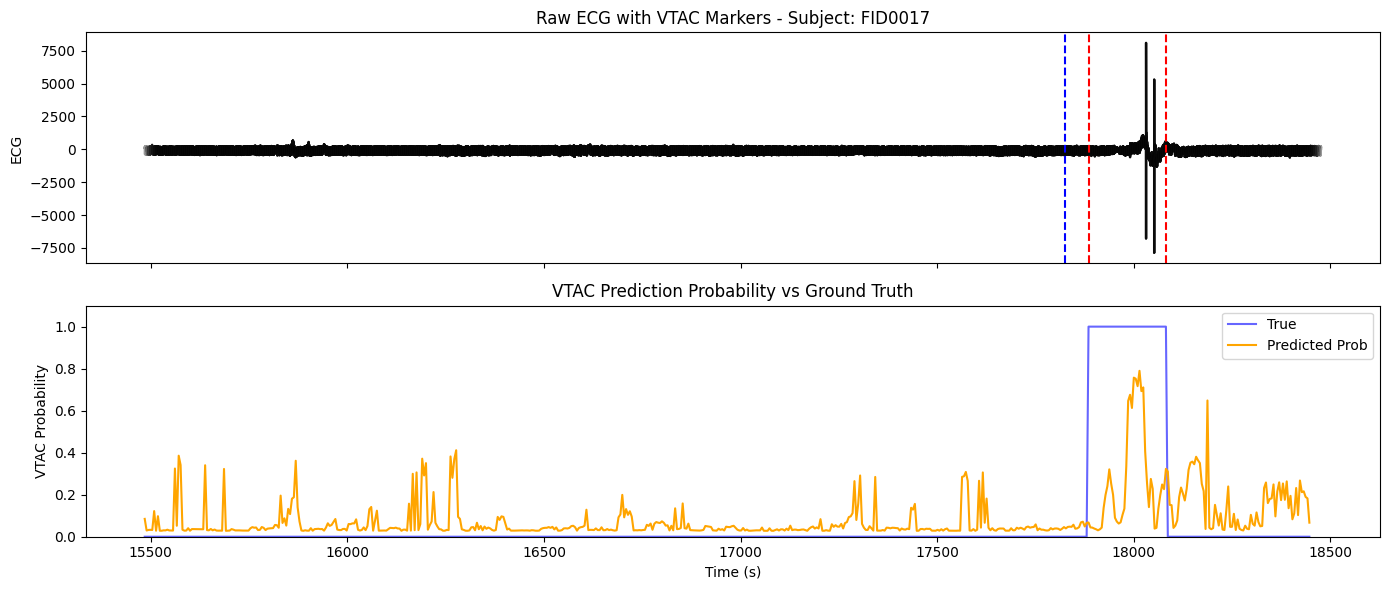

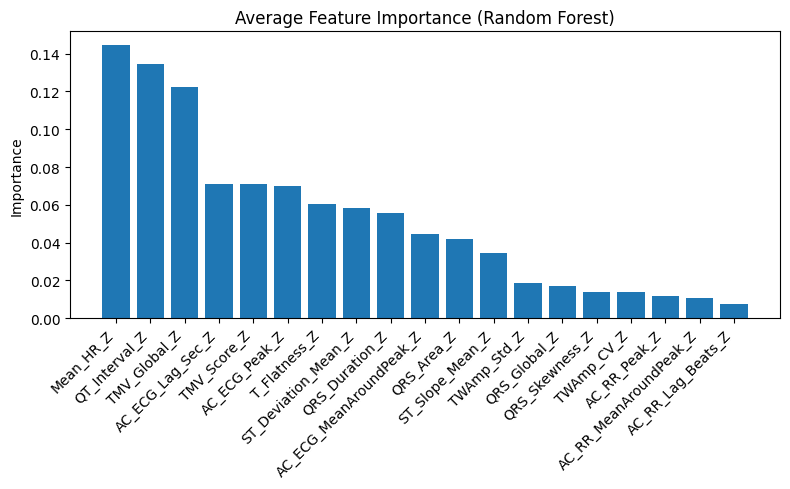

In [37]:
# --- Load your dataframe before running this ---
df = zscores_df.copy()

# --- Drop excluded subjects ---
excluded_subjects = ['cu01', 'cu02', 'cu04','cu12','cu14', 'cu21','cu24', 'cu30', 'cu31', 'cu33', 'cu34', 'cu35','cu16','cu26']
df = df[~df['Record'].isin(excluded_subjects)].copy()
# --- Label previous 60 seconds from first VTAC=1 per subject ---
sampling_rate = 250

features = [
    'QT_Interval_Z', 'TMV_Score_Z', 'Mean_HR_Z',"QRS_Global_Z",
    'T_Flatness_Z', 'TWAmp_Std_Z', 'TWAmp_CV_Z','TMV_Global_Z', 'QRS_Duration_Z', 'QRS_Area_Z',"QRS_Skewness_Z","ST_Deviation_Mean_Z",
    "ST_Slope_Mean_Z", "AC_ECG_Peak_Z","AC_ECG_Lag_Sec_Z","AC_ECG_MeanAroundPeak_Z","AC_RR_Peak_Z","AC_RR_Lag_Beats_Z","AC_RR_MeanAroundPeak_Z"
]

df = df.dropna(subset=features + ['VTAC_Label', 'Record'])

# --- ML Inputs ---
X = df[features].values
y = df['VTAC_Label'].values
groups = df['Record'].astype(str).values

# --- Cross-validation setup ---
gkf = GroupKFold(n_splits=5)
all_preds, all_true, all_probs, all_indices = [], [], [], []
feature_importances = np.zeros(len(features))

fold_num = 1
for train_idx, test_idx in gkf.split(X, y, groups):
    print(f"\n--- Fold {fold_num} ---")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    test_records = df.iloc[test_idx]['Record'].unique()

    # --- Randomized Search ---
    param_dist = {
        'n_estimators': [50, 100, 200, 300],  
        'max_depth': [3, 5, 7],
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5)
    }
    base_model = RandomForestClassifier(random_state=42)
    search = RandomizedSearchCV(base_model, param_distributions=param_dist, n_iter=20, cv=3,
                                scoring='f1', random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    model = search.best_estimator_

    # --- Predict ---
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    all_preds.extend(preds)
    all_true.extend(y_test)
    all_probs.extend(probs)
    all_indices.extend(test_idx)

    # --- Predict on train and test ---
    preds_train = model.predict(X_train)
    preds_test = model.predict(X_test)

    probs_test = model.predict_proba(X_test)[:, 1]

    # Save predictions
    all_preds.extend(preds_test)
    all_true.extend(y_test)
    all_probs.extend(probs_test)
    all_indices.extend(test_idx)

    # --- Print Reports ---
    print("Train Classification Report:")
    print(classification_report(y_train, preds_train))

    print("Test Classification Report:")
    print(classification_report(y_test, preds_test))


    feature_importances += model.feature_importances_
    # --- Plot for each subject ---
    for subject_id in test_records:
        subject_df = df.iloc[test_idx].copy()
        subject_df = subject_df[subject_df['Record'] == subject_id].copy()
        subject_df = subject_df.sort_values('Start')

        # Recompute X_sub for this subject
        X_sub = subject_df[features].values
        subject_df['Prediction'] = model.predict(X_sub)
        subject_df['Prob_VTAC'] = model.predict_proba(X_sub)[:, 1]

        fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

        # --- Top: Raw ECG ---
        for _, row in subject_df.iterrows():
            if isinstance(row['ECG_Raw'], list) and len(row['ECG_Raw']) > 0:
                # Start is in samples, convert to seconds for plotting
                t = np.linspace(
                    row['Start'] / sampling_rate,
                    (row['Start'] + sampling_rate * 30) / sampling_rate,
                    len(row['ECG_Raw'])
                )
                axs[0].plot(t, row['ECG_Raw'], color='black', alpha=0.4)

        # --- VTAC markers from VTAC_Label ---
        vtac_rows = subject_df[subject_df['VTAC_Label'] == 1]

        if not vtac_rows.empty:
            # Work in samples first
            vtac_start_sample = vtac_rows['Start'].min()
            vtac_end_sample   = vtac_rows['Start'].max()

            # Convert to seconds for plotting
            vtac_start_sec = vtac_start_sample / sampling_rate
            vtac_end_sec   = vtac_end_sample   / sampling_rate

            # Red lines = VTAC segment (in seconds)
            axs[0].axvline(vtac_start_sec, color='red', linestyle='--')
            axs[0].axvline(vtac_end_sec,   color='red', linestyle='--')

            # Blue line = 60 seconds before VTAC onset
            axs[0].axvline(vtac_start_sec - 60, color='blue', linestyle='--')

            # --- Label 60 seconds before VTAC as 1 in subject_df (optional) ---
            pre_vtac_start_sample = max(0, vtac_start_sample - 60 * sampling_rate)
            mask = (
                (subject_df['Start'] >= pre_vtac_start_sample) &
                (subject_df['Start'] <= vtac_start_sample)
            )
            subject_df.loc[mask, 'VTAC_Label_Updated'] = 1
        else:
            # No VTAC in this subject: optionally set VTAC_Label_Updated = VTAC_Label or 0
            subject_df['VTAC_Label_Updated'] = subject_df['VTAC_Label']

        axs[0].set_title(f"Raw ECG with VTAC Markers - Subject: {subject_id}")
        axs[0].set_ylabel("ECG")

        # --- Bottom: Probabilities ---
        axs[1].plot(
            subject_df['Start'] / sampling_rate,
            subject_df['VTAC_Label'],
            label="True", color='blue', alpha=0.6
        )
        axs[1].plot(
            subject_df['Start'] / sampling_rate,
            subject_df['Prob_VTAC'],
            label="Predicted Prob", color='orange'
        )
        axs[1].legend()
        axs[1].set_ylabel("VTAC Probability")
        axs[1].set_xlabel("Time (s)")
        axs[1].set_title("VTAC Prediction Probability vs Ground Truth")
        axs[1].set_ylim(0, 1.1)

        plt.tight_layout()
        plt.show()


    fold_num += 1

# --- Step 7: Feature Importance ---
feature_importances /= gkf.get_n_splits()
plt.figure(figsize=(8, 5))
sorted_idx = np.argsort(feature_importances)[::-1]
plt.bar(range(len(features)), feature_importances[sorted_idx])
plt.xticks(range(len(features)), [features[i] for i in sorted_idx], rotation=45, ha='right')
plt.title("Average Feature Importance (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

In [38]:
# --- Update ML inputs ---
X = df[features].values
y = df['VTAC_Label'].values


# --- Retrain final model on full dataset ---
print("\n--- Training Final Model on Entire Dataset ---")

# Use the best parameters from one of the previous folds or redefine param_dist to sample again
final_param_dist = {
        'n_estimators': [50, 100, 200, 300],  
        'max_depth': [3, 5, 7],
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5)
    }

final_base_model = RandomForestClassifier(random_state=42)
final_search = RandomizedSearchCV(final_base_model, param_distributions=final_param_dist, n_iter=20,
                                  cv=3, scoring='f1', random_state=42, n_jobs=-1)
final_search.fit(X, y)
final_model = final_search.best_estimator_

os.makedirs("model", exist_ok=True)
# --- Save model ---
model_path = os.path.join("model", "random_forest_vtac_model_binary.joblib")

joblib.dump(final_model, model_path)
print(f"✅ Final model saved to: {model_path}")


# --- Retrain final model on full dataset using XGBoost ---
print("\n--- Training Final XGBoost Model on Entire Dataset ---")

# Define hyperparameter space for XGBoost
final_param_dist = {
    'n_estimators': [50, 100, 200, 300],  
    'max_depth': [3, 5, 7],
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),          # range: 0.6 to 1.0
    'colsample_bytree': uniform(0.6, 0.4),   # range: 0.6 to 1.0
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(1, 2)
}

# Initialize base XGBoost model
final_base_model = XGBClassifier(eval_metric='logloss', random_state=42)

# Randomized search over hyperparameters
final_search = RandomizedSearchCV(
    final_base_model,
    param_distributions=final_param_dist,
    n_iter=20,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=-1
)

# Fit on full dataset
final_search.fit(X, y)
final_model = final_search.best_estimator_

# --- Save model ---
model_path = os.path.join("model", "xgboost_vtac_model_binary.joblib")
joblib.dump(final_model, model_path)
print(f"✅ Final XGBoost model saved to: {model_path}")


--- Training Final Model on Entire Dataset ---
✅ Final model saved to: model/random_forest_vtac_model_binary.joblib

--- Training Final XGBoost Model on Entire Dataset ---
✅ Final XGBoost model saved to: model/xgboost_vtac_model_binary.joblib


## Regression Models

### XGBoosting Regression


--- Fold 1 ---
RMSE (Train/Test): 0.1960 / 0.3070


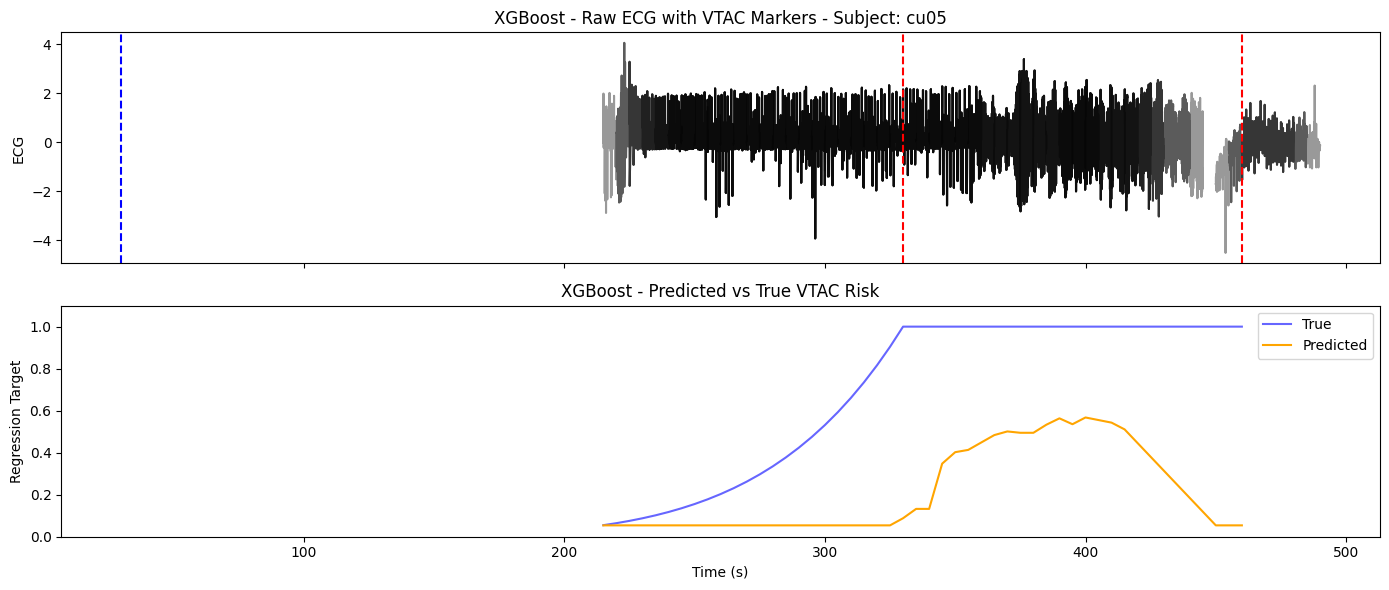

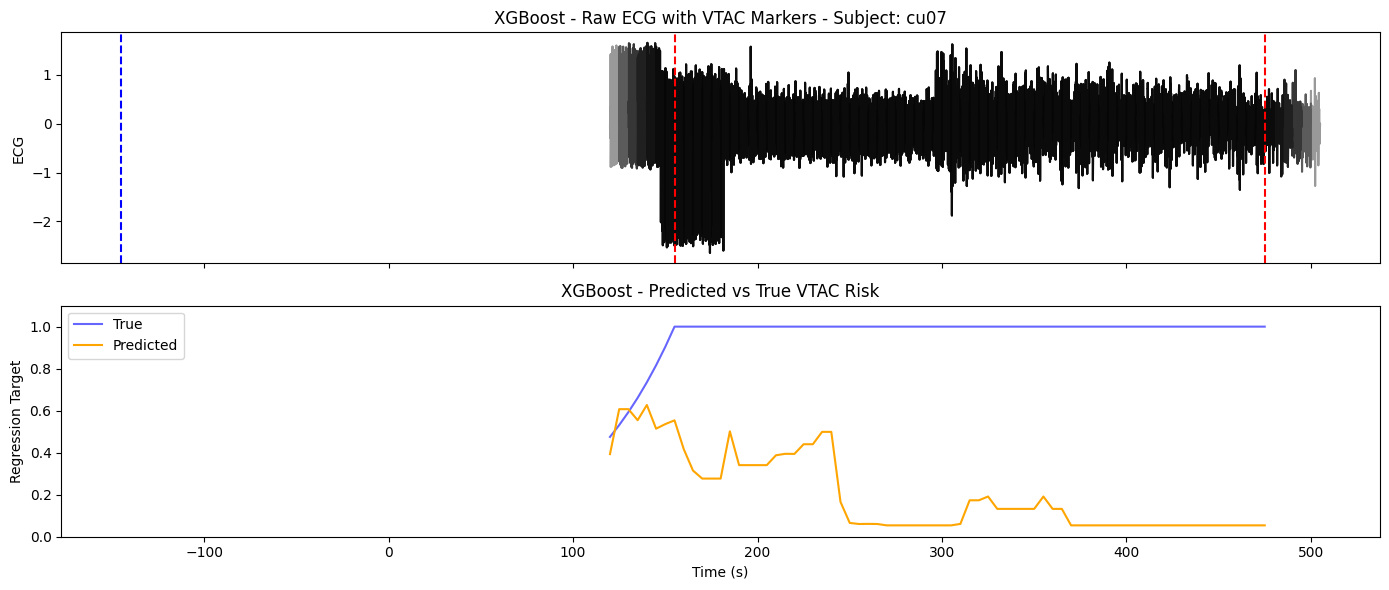

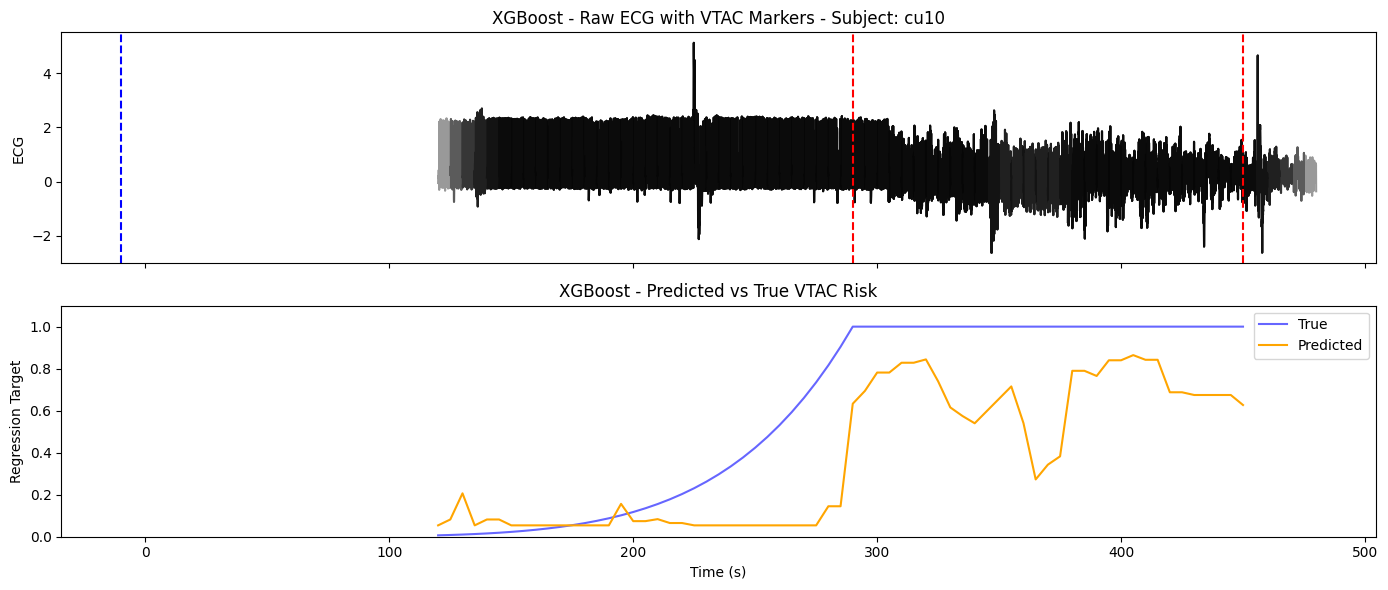

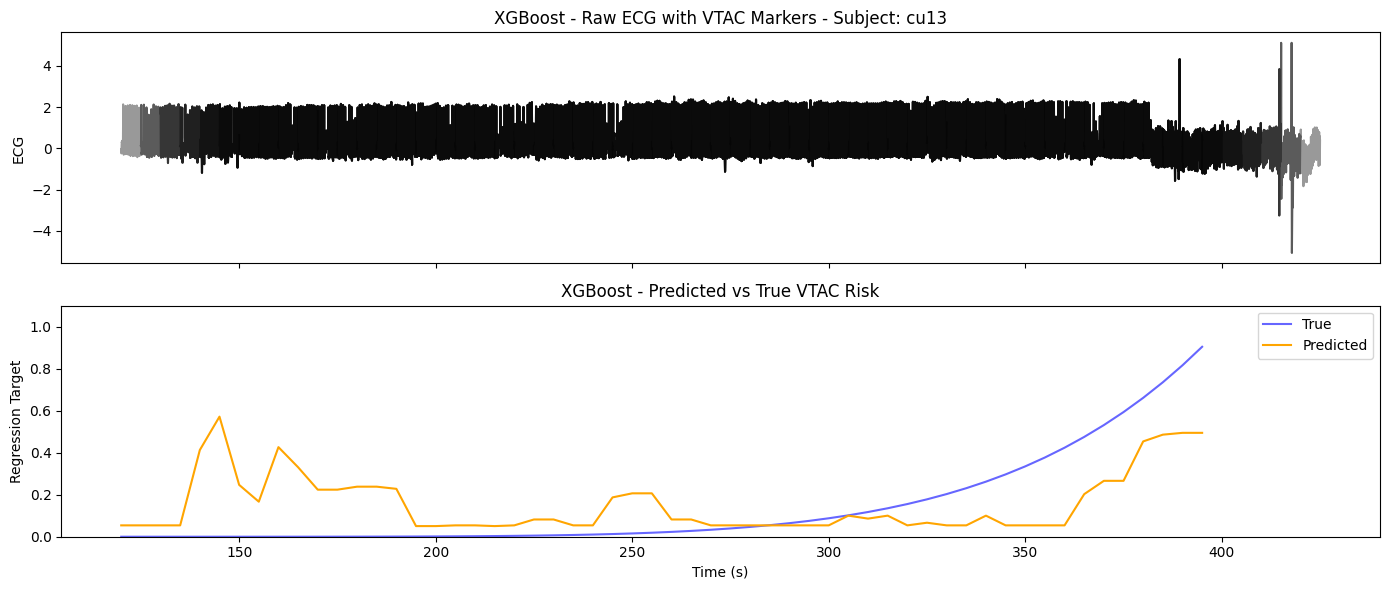

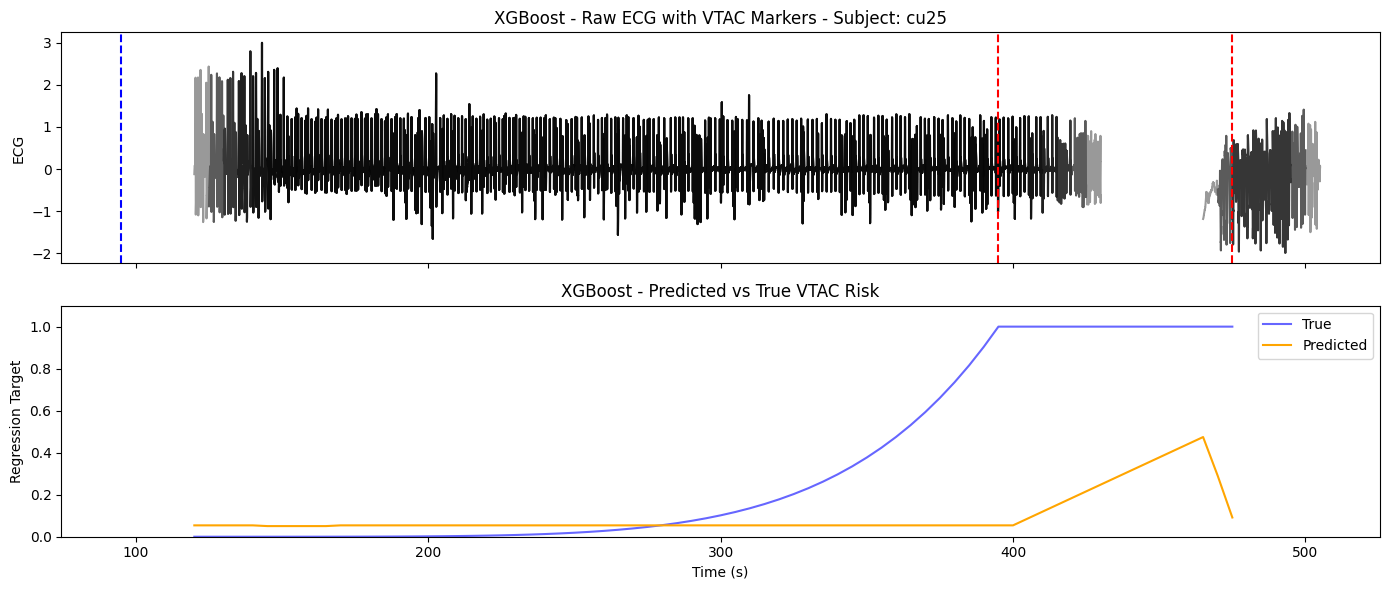

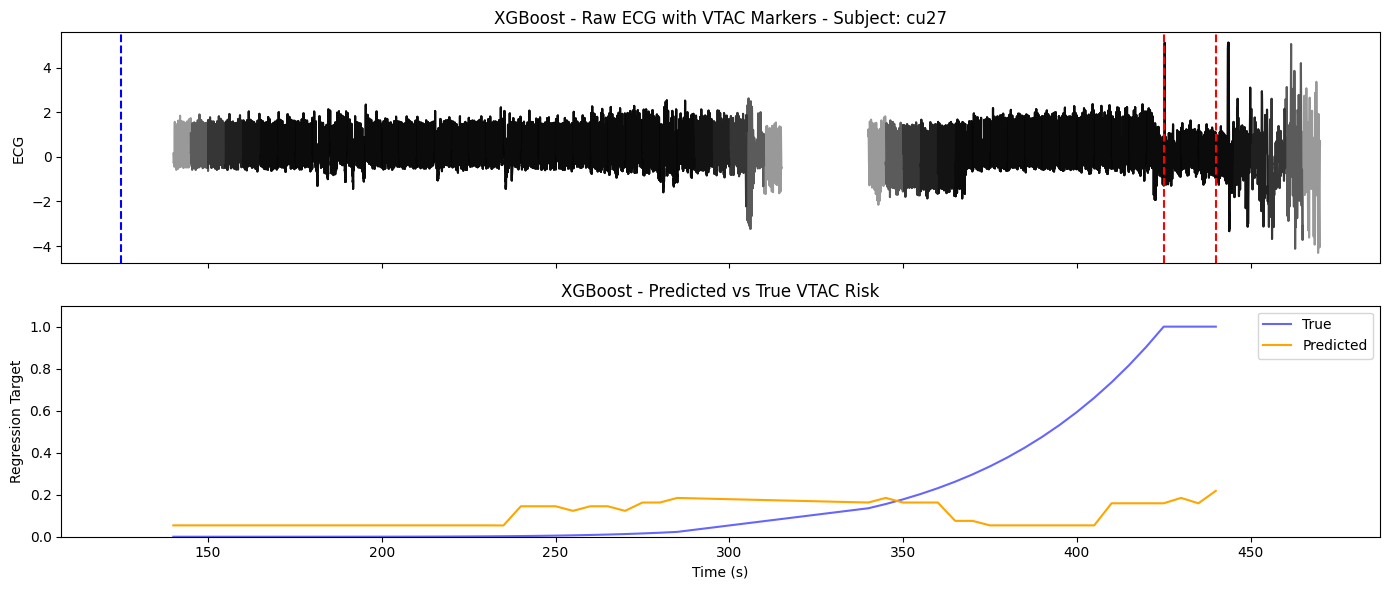

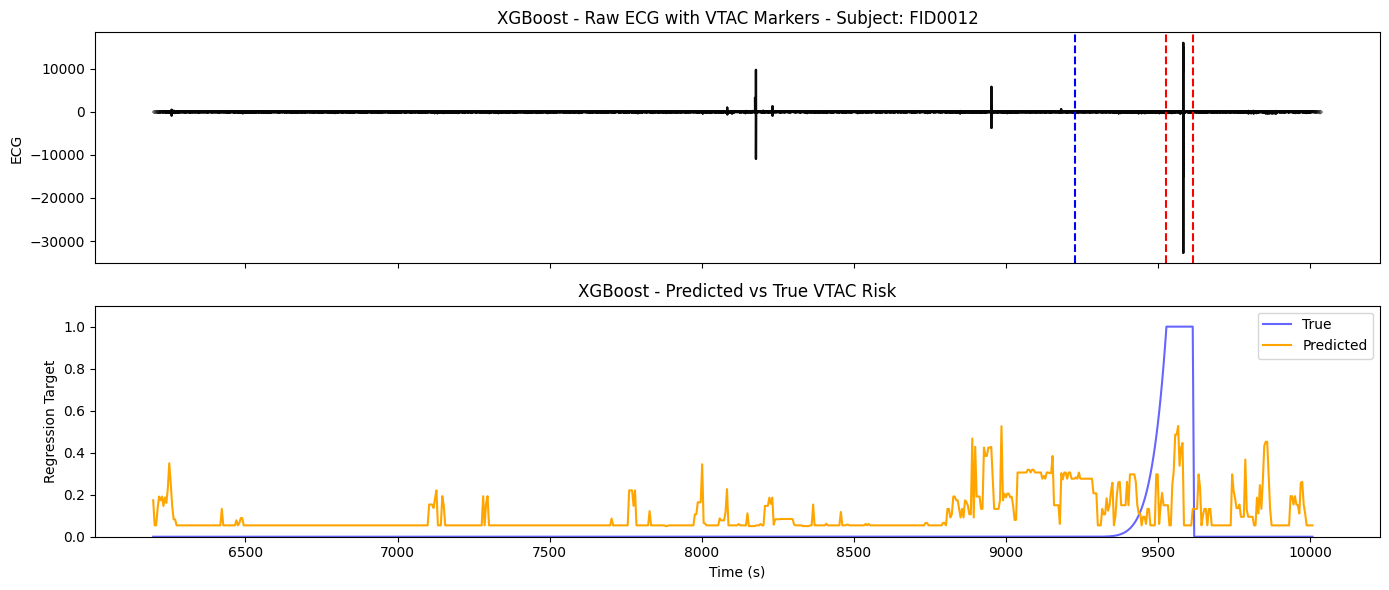


--- Fold 2 ---
RMSE (Train/Test): 0.2137 / 0.2782


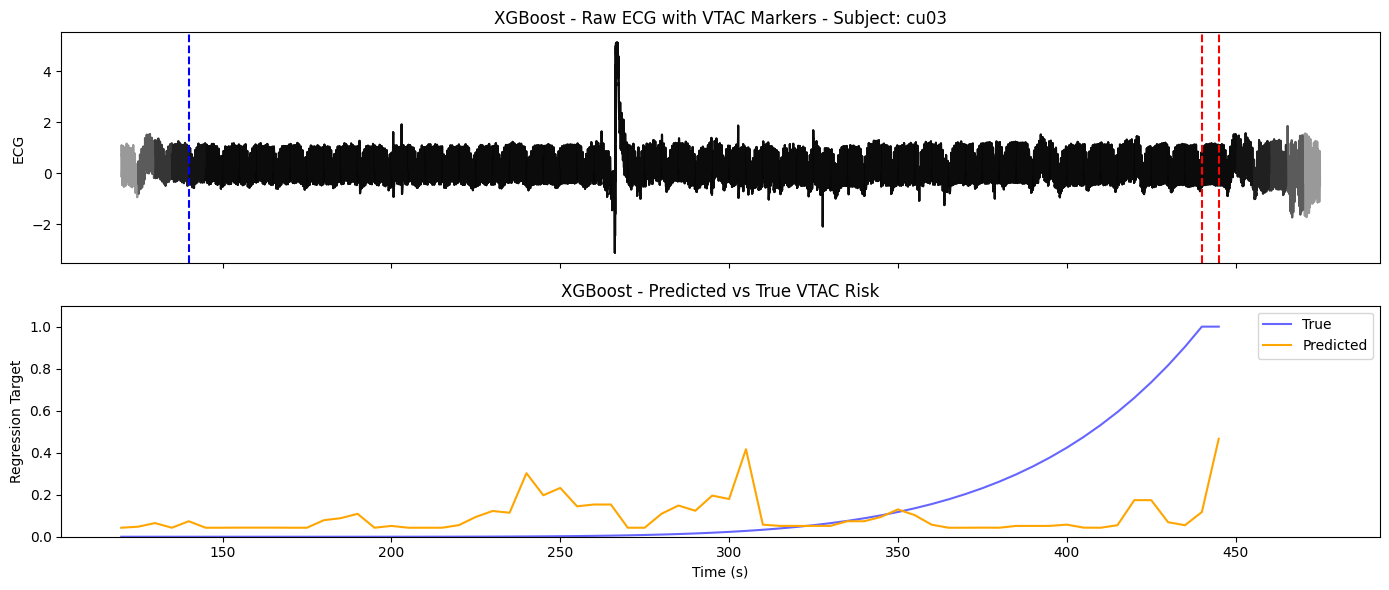

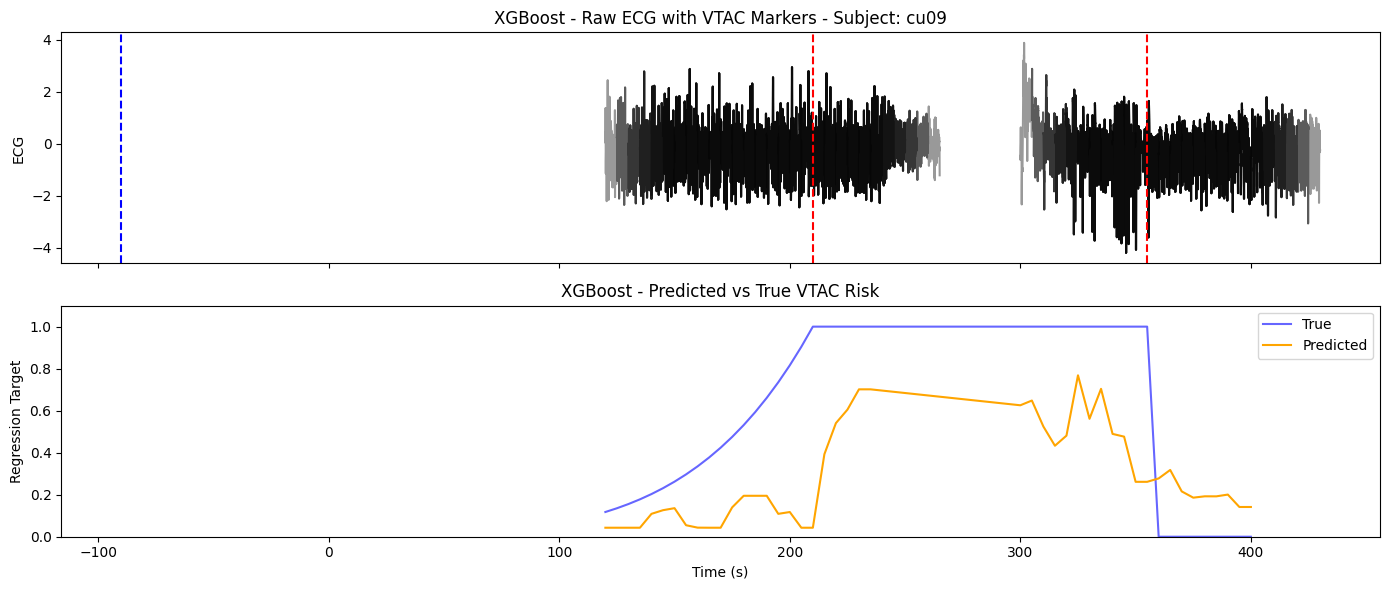

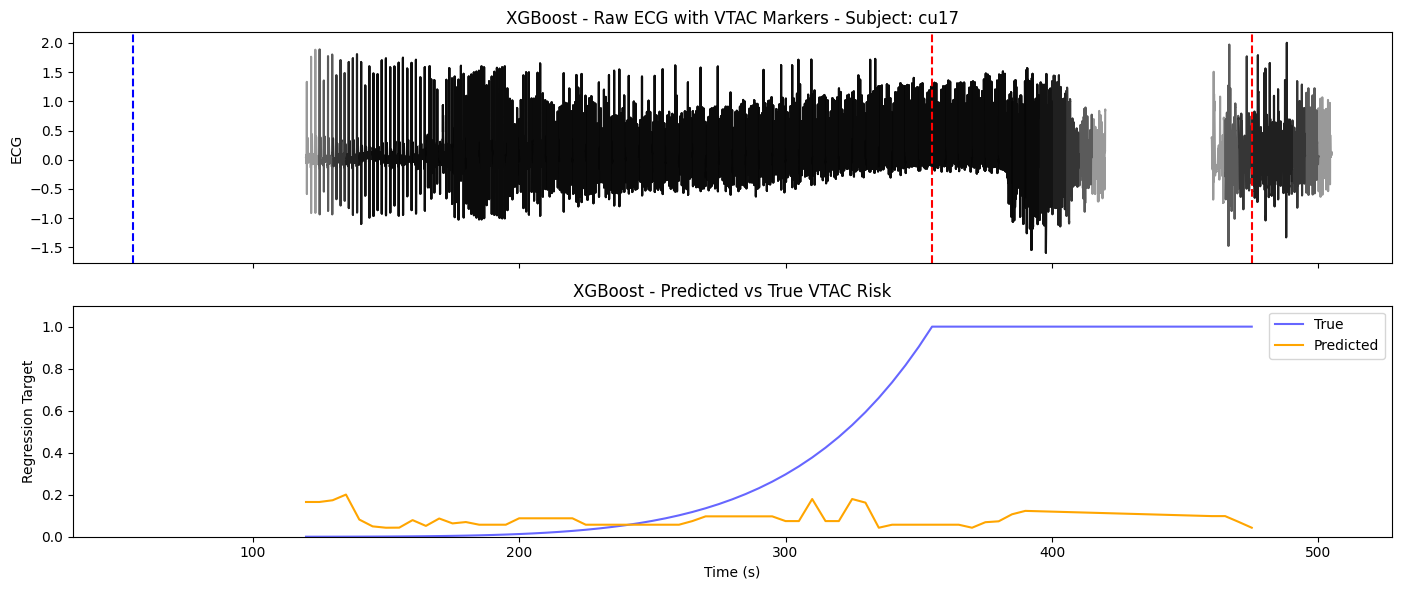

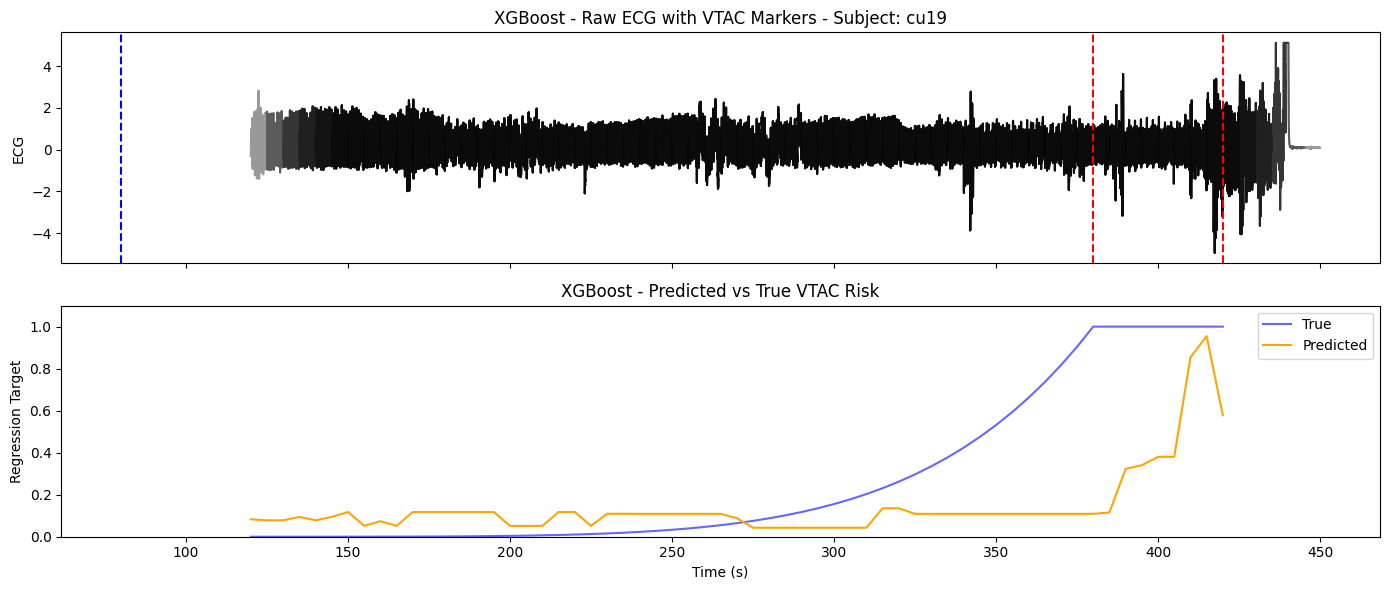

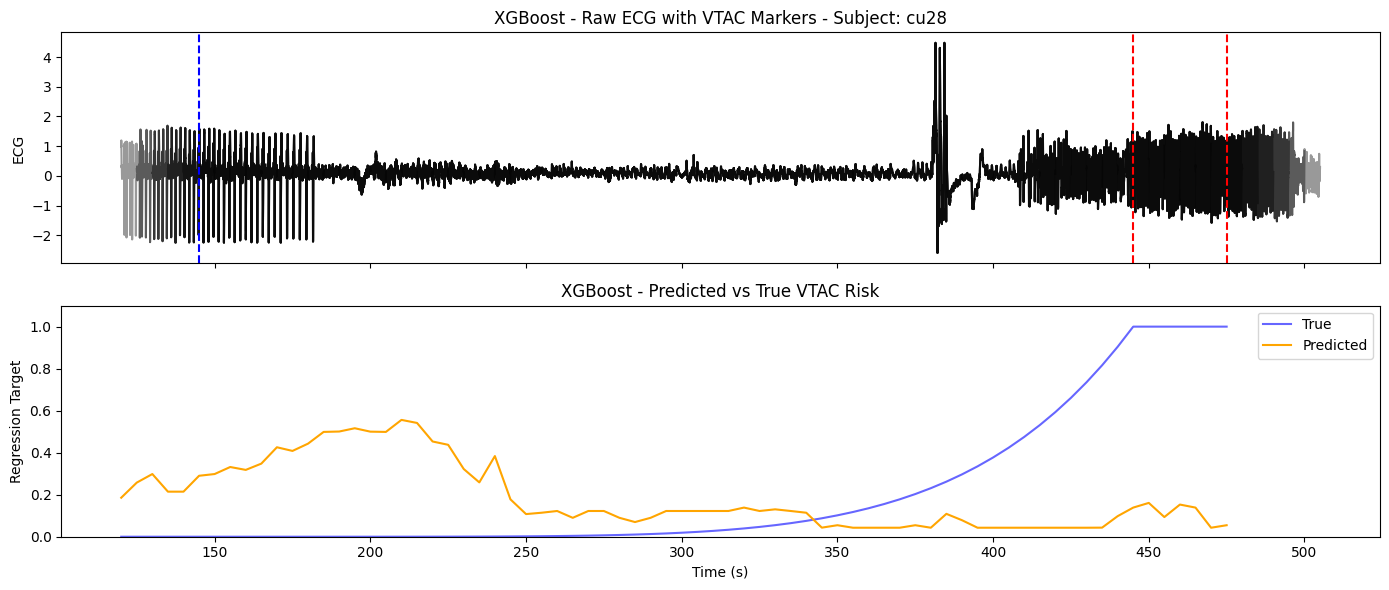

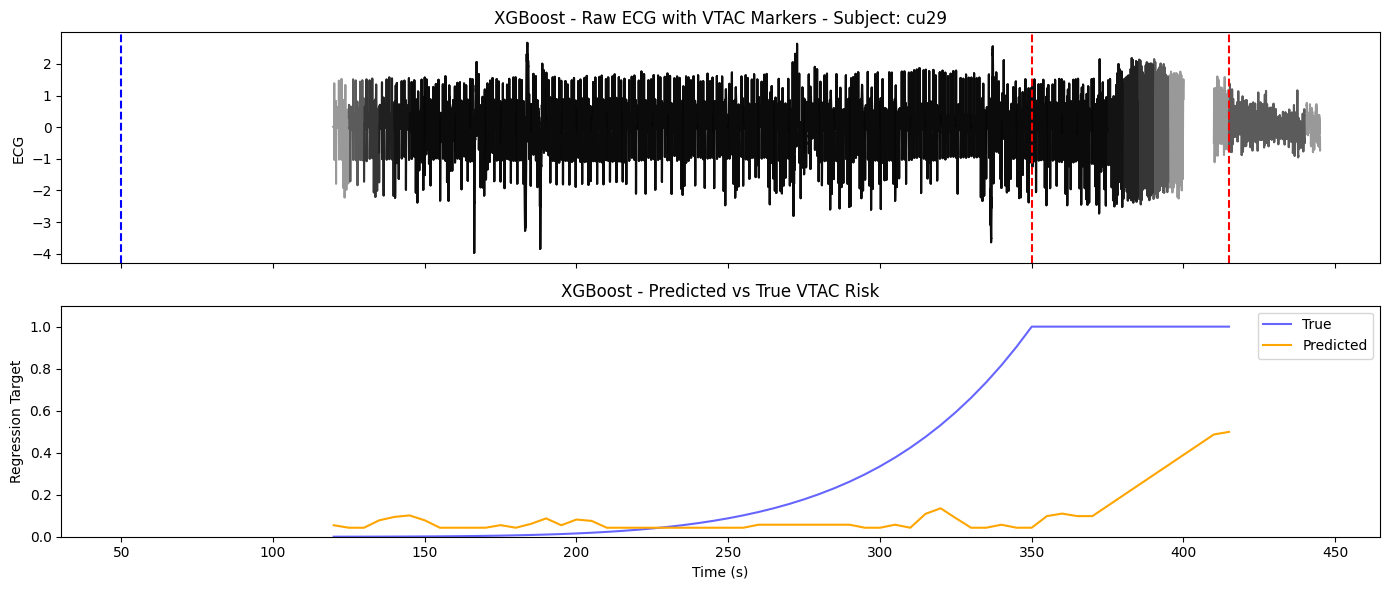

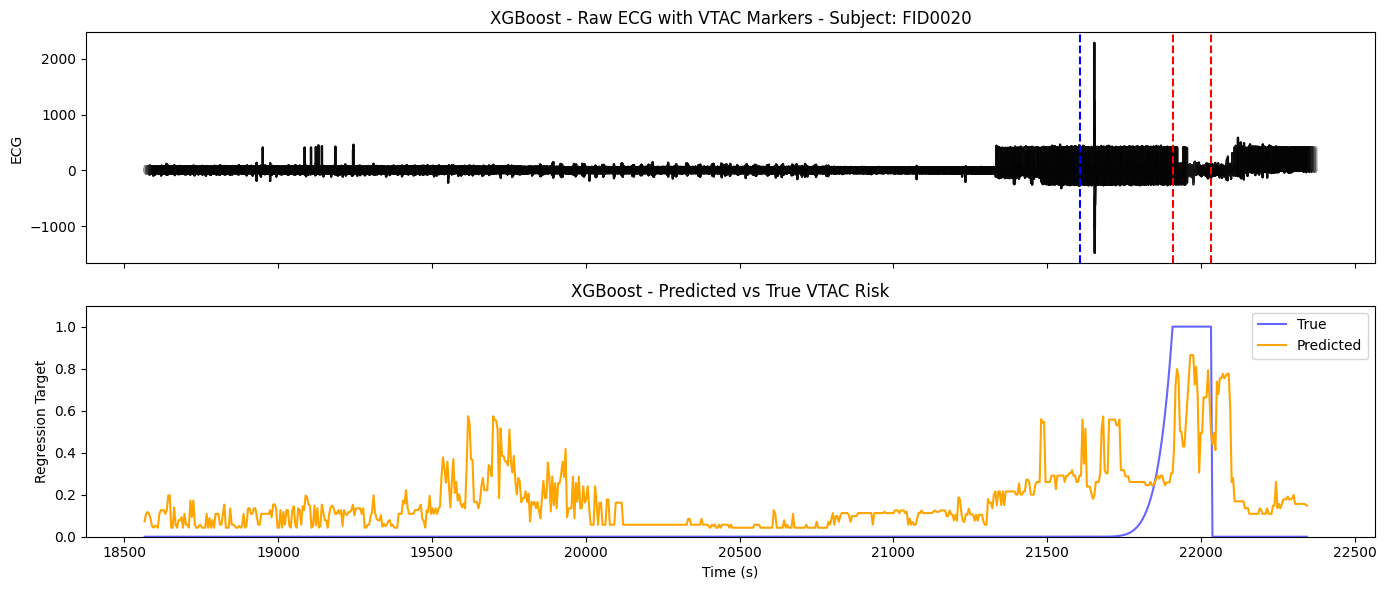


--- Fold 3 ---
RMSE (Train/Test): 0.1966 / 0.2624


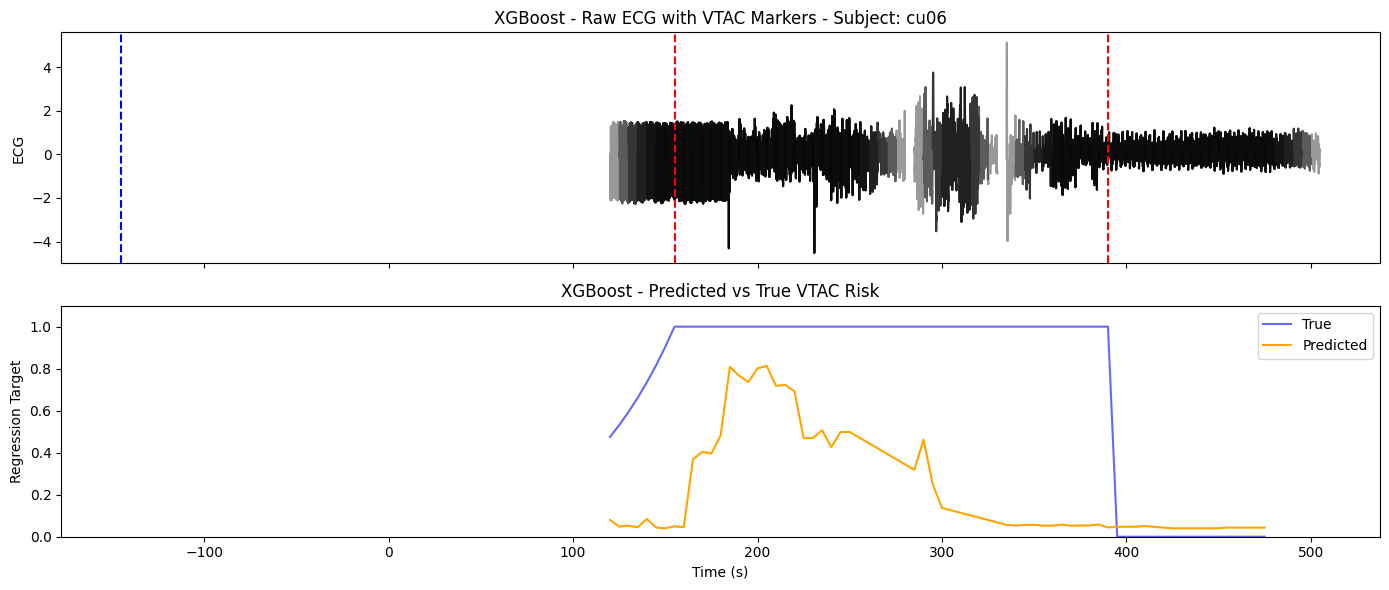

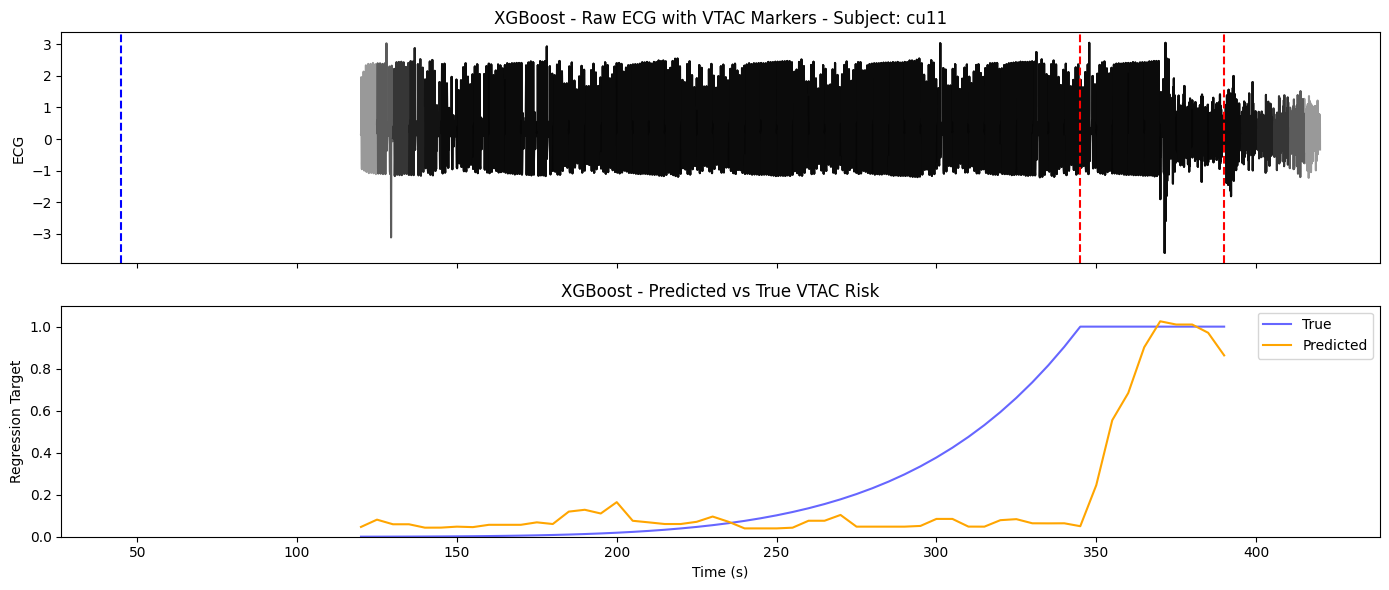

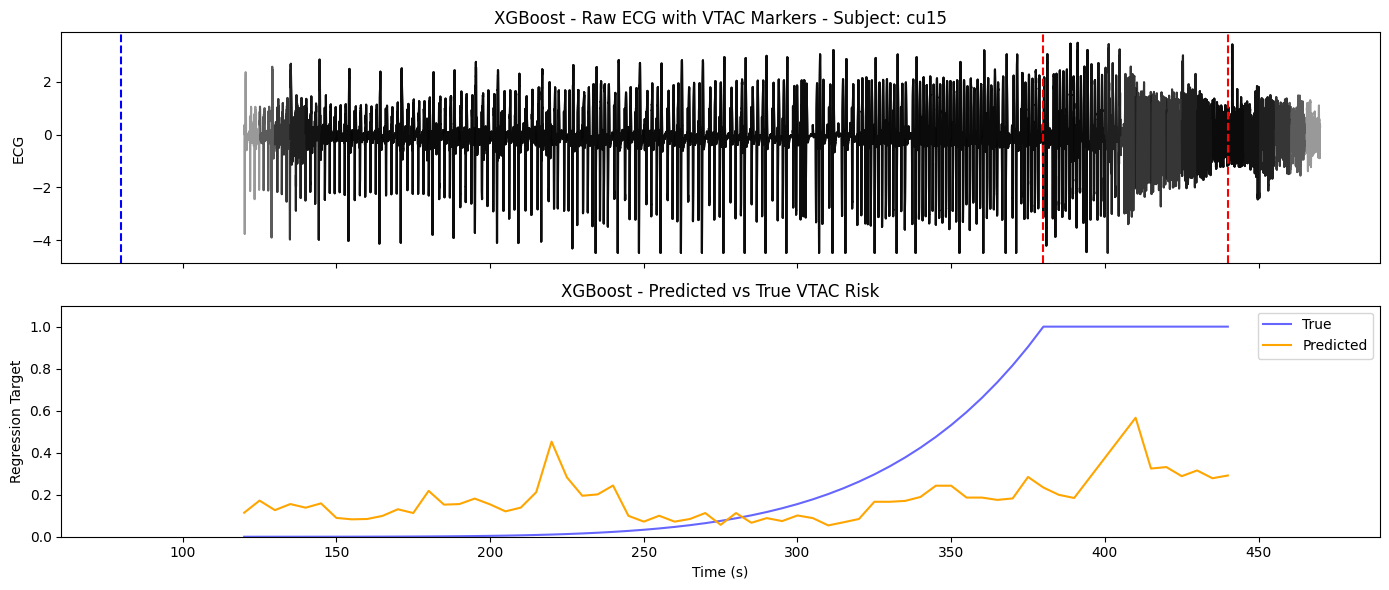

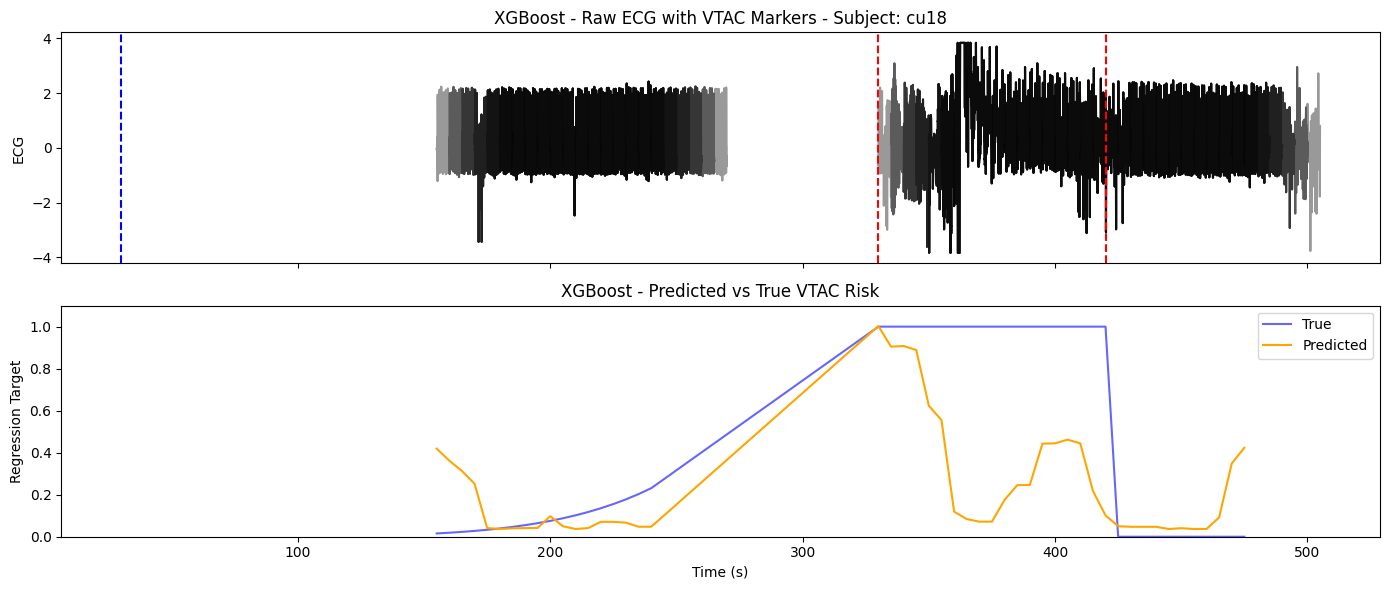

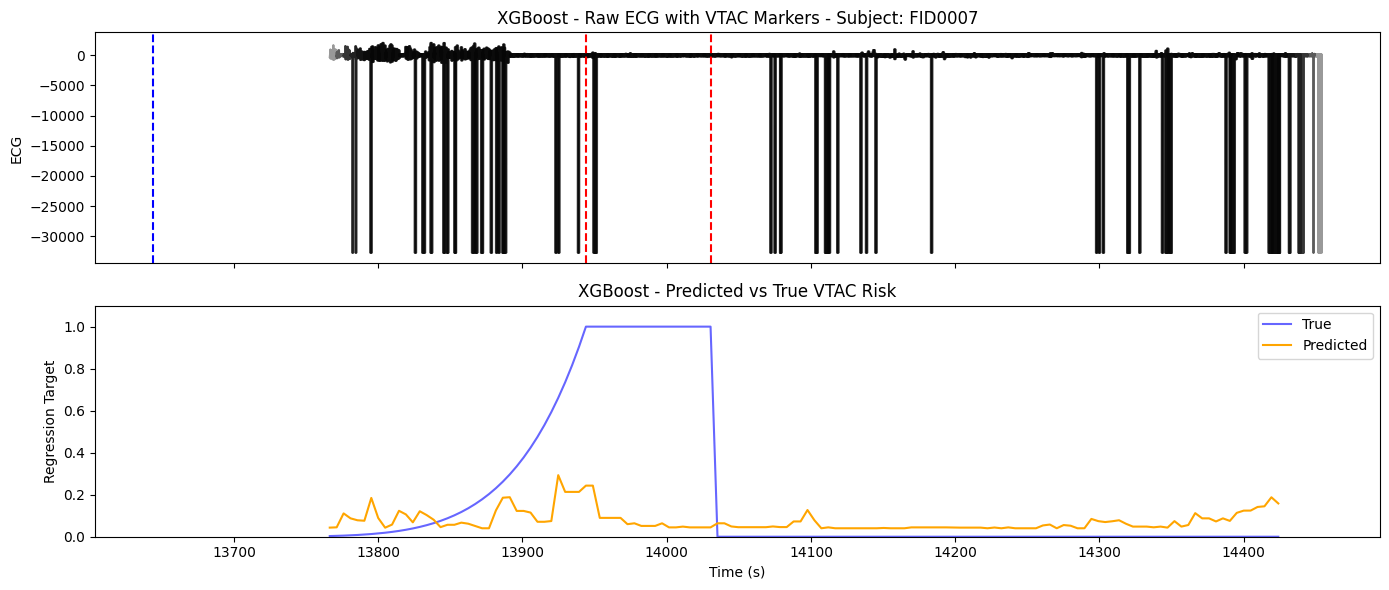

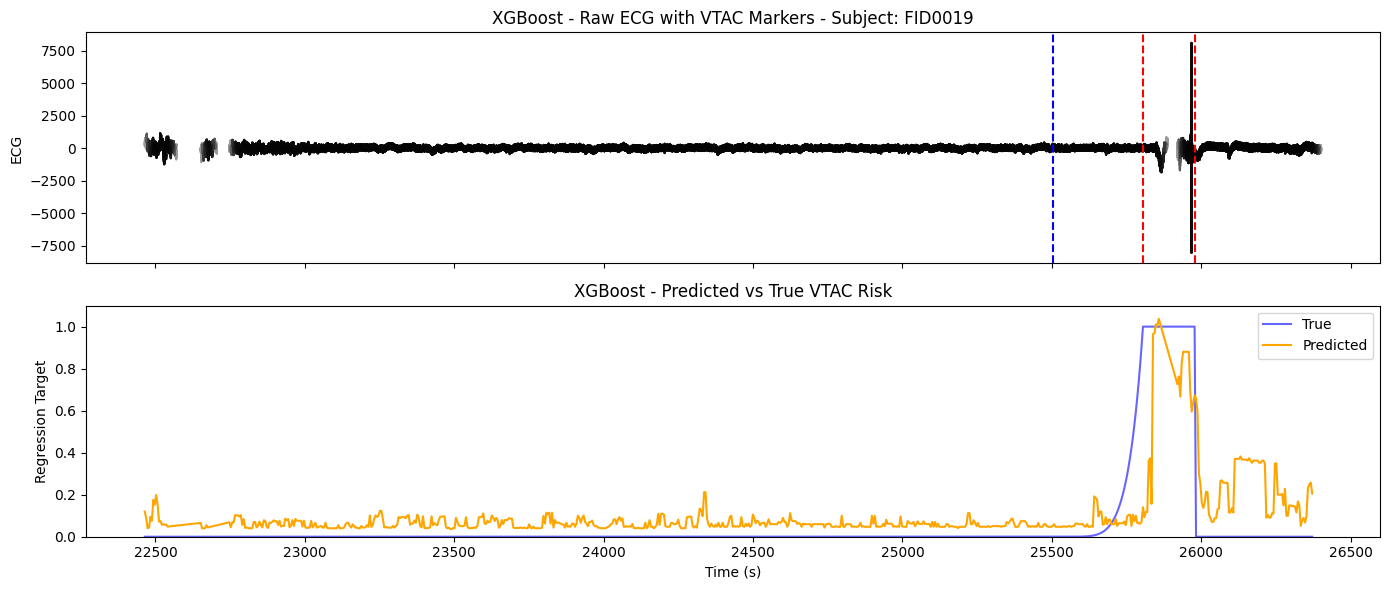


--- Fold 4 ---
RMSE (Train/Test): 0.1983 / 0.2175


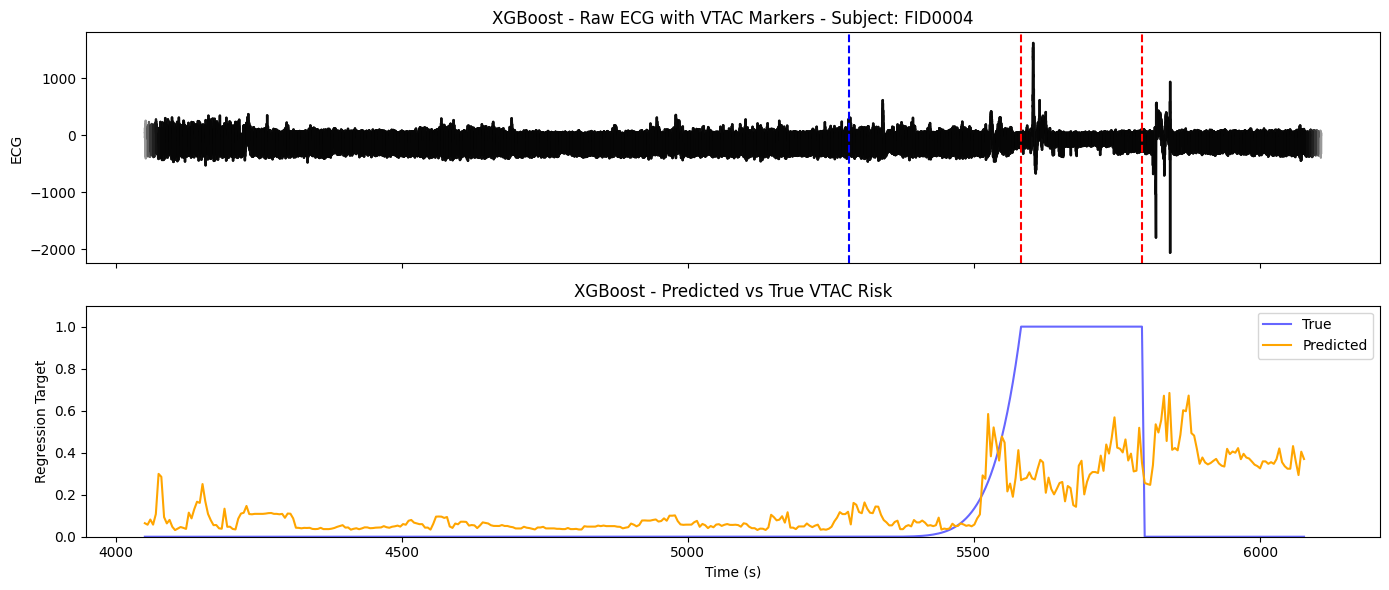

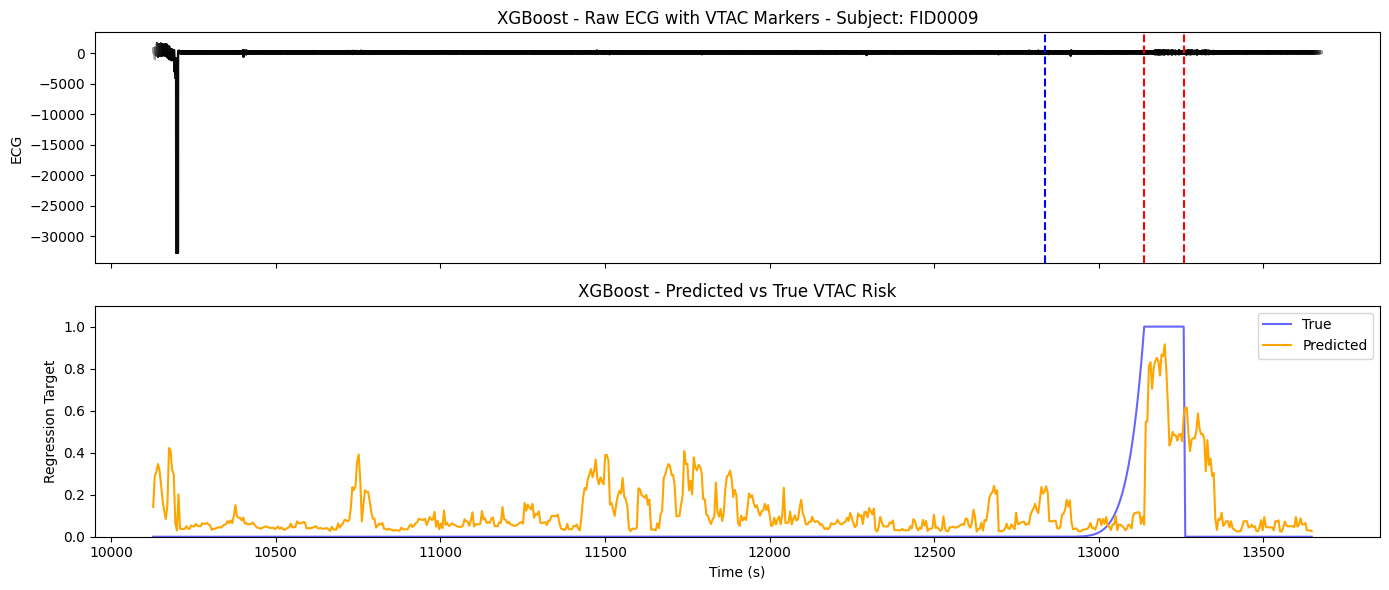


--- Fold 5 ---
RMSE (Train/Test): 0.1904 / 0.2185


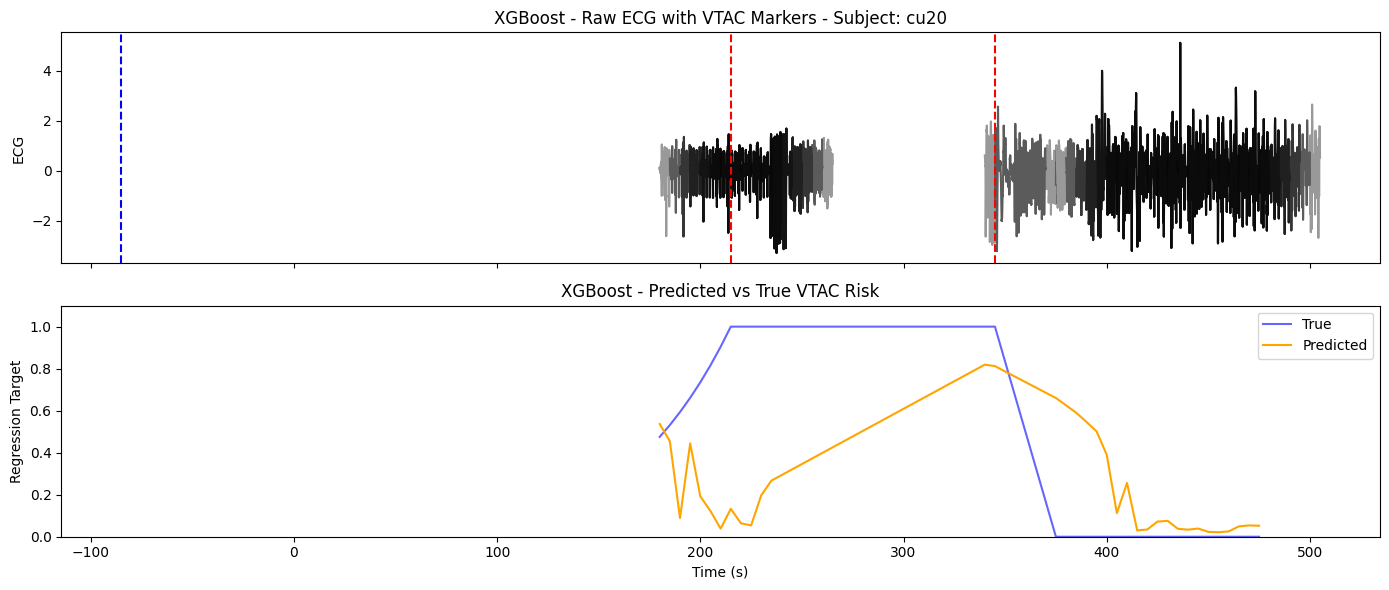

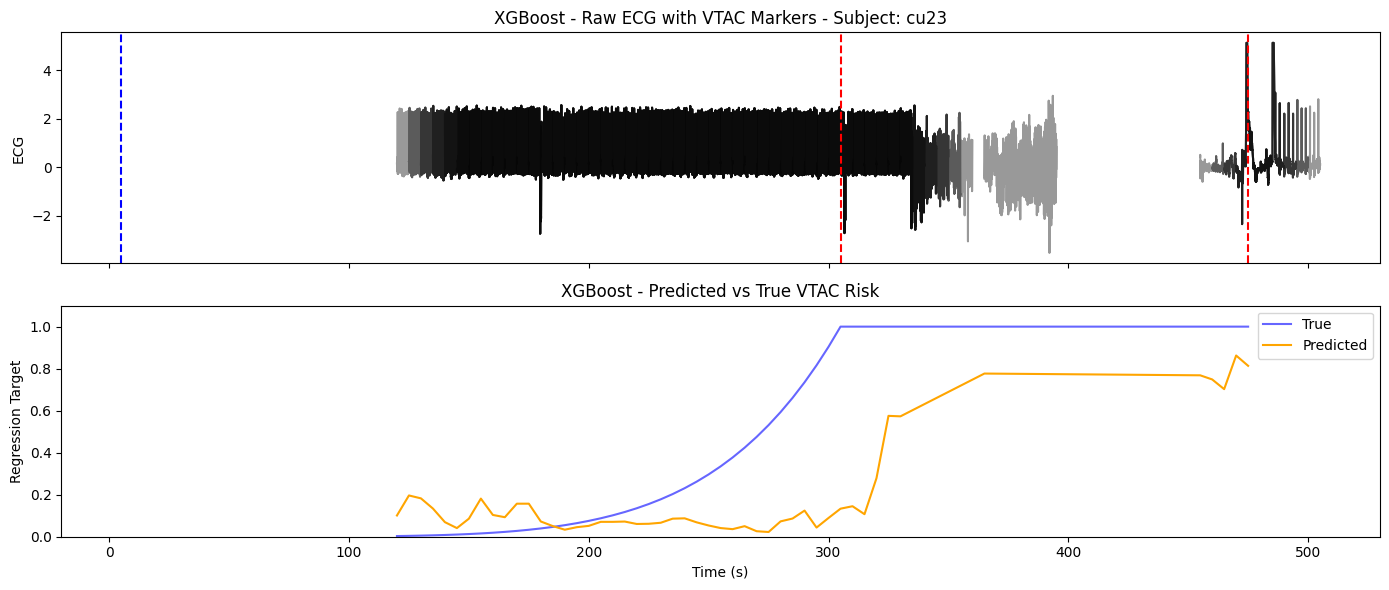

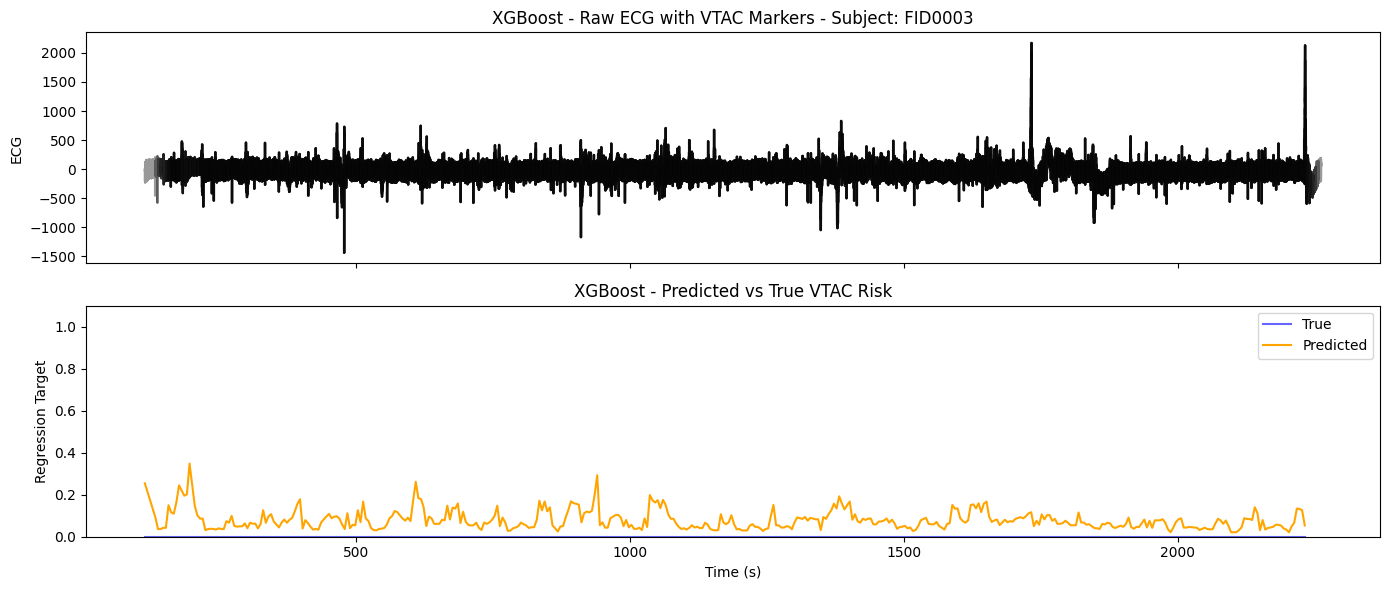

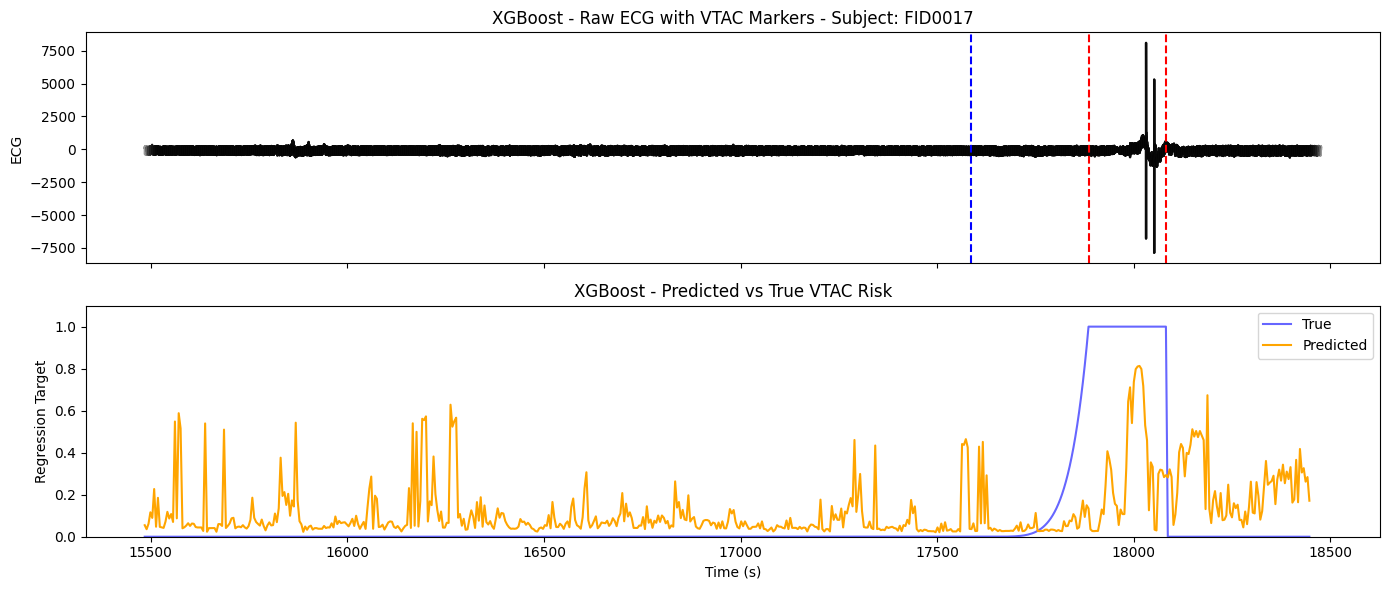

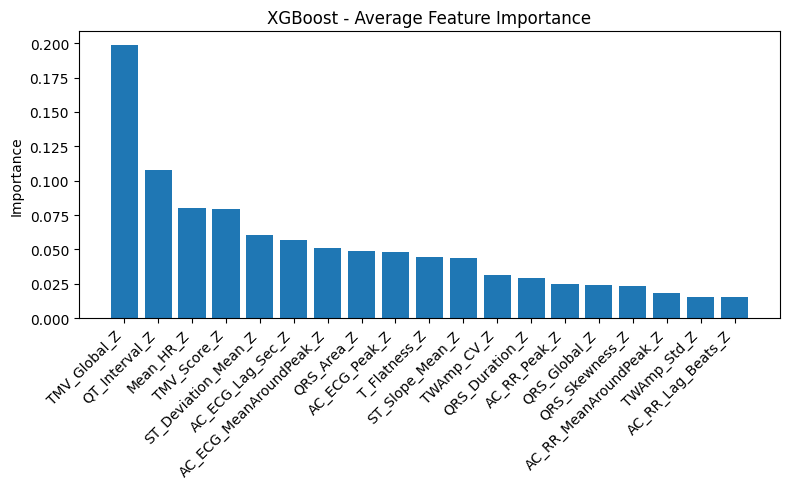

In [39]:
# --- Load your dataframe before running this ---
df = zscores_df.copy()
# --- Drop excluded subjects ---
excluded_subjects = ['cu01', 'cu02', 'cu04','cu12','cu14', 'cu21','cu24', 'cu30', 'cu31', 'cu33', 'cu34', 'cu35','cu16','cu26']
df = df[~df['Record'].isin(excluded_subjects)].copy()
# --- Regression Label: Exponential (t_norm^4) from 300s before VTAC ---
def get_sampling_rate(record_id):
    if str(record_id).startswith("FID"):
        return 240
    else:
        return 250
    
sigmoid_seconds = 300
df['VTAC_Label_Regression'] = 0.0

for record_id in df['Record'].unique():

    fs = get_sampling_rate(record_id)
    sigmoid_samples = int(sigmoid_seconds * fs)

    subj_idx = df['Record'] == record_id
    subj_df = df.loc[subj_idx]

    vtac_rows = subj_df[subj_df['VTAC_Label'] == 1]
    if vtac_rows.empty:
        continue

    vtac_start = vtac_rows['Start'].min()

    # --- Pre-VTAC window ---
    start_min = max(0, vtac_start - sigmoid_samples)

    pre_mask = (
        subj_idx &
        (df['Start'] >= start_min) &
        (df['Start'] < vtac_start)
    )

    # distance (in samples) to VTAC
    i = vtac_start - df.loc[pre_mask, 'Start'].values

    # time in seconds
    t = -i / fs

    # normalize to [0, 1]
    t_norm = (t + sigmoid_seconds) / sigmoid_seconds

    # your slow→fast ramp
    df.loc[pre_mask, 'VTAC_Label_Regression'] = t_norm ** 6

    # --- During VTAC ---
    df.loc[
        subj_idx & (df['VTAC_Label'] == 1),
        'VTAC_Label_Regression'
    ] = 1.0

# --- Define features and drop NaNs ---
df = df.dropna(subset=features + ['VTAC_Label_Regression', 'Record'])

# --- ML Inputs ---
X = df[features].values
y = df['VTAC_Label_Regression'].values
groups = df['Record'].astype(str).values

# --- Cross-validation setup ---
gkf = GroupKFold(n_splits=5)
all_preds, all_true, all_indices = [], [], []
feature_importances = np.zeros(len(features))

fold_num = 1
for train_idx, test_idx in gkf.split(X, y, groups):
    print(f"\n--- Fold {fold_num} ---")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    test_records = df.iloc[test_idx]['Record'].unique()

    # --- XGBoost Randomized Search ---
    param_dist = {
        'n_estimators': [50, 100, 200, 300],  
        'max_depth': [3, 5, 7],
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'gamma': uniform(0, 5),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(1, 2)
    }

    base_model = XGBRegressor(random_state=42, verbosity=0, eval_metric='rmse')
    search = RandomizedSearchCV(base_model, param_distributions=param_dist, n_iter=20, cv=3,
                                scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    model = search.best_estimator_

    # --- Predict ---
    preds_test = model.predict(X_test)
    preds_test = medfilt(preds_test, kernel_size=5)   # smooth test predictions

    preds_train = model.predict(X_train)
    preds_train = medfilt(preds_train, kernel_size=5)   # smooth test predictions


    all_preds.extend(preds_test)
    all_true.extend(y_test)
    all_indices.extend(test_idx)

    rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))

    # --- Report Pearson Correlation ---
    #print(f"Pearson r (Train/Test): {pearsonr(y_train, preds_train)[0]:.3f} / {pearsonr(y_test, preds_test)[0]:.3f}")
    print(f"RMSE (Train/Test): {rmse_train:.4f} / {rmse_test:.4f}")
    feature_importances += model.feature_importances_

    # --- Plot per Subject ---
    for subject_id in test_records:
        subject_df = df.iloc[test_idx].copy()
        subject_df = subject_df[subject_df['Record'] == subject_id].copy()
        subject_df = subject_df.sort_values('Start')
        X_sub = subject_df[features].values
        subject_df['Prediction'] = model.predict(X_sub)

        fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

        # --- Top: Raw ECG ---
        for _, row in subject_df.iterrows():
            if isinstance(row['ECG_Raw'], list) and len(row['ECG_Raw']) > 0:
                t = np.linspace(row['Start'] / sampling_rate,
                                (row['Start'] + sampling_rate * 30) / sampling_rate,
                                len(row['ECG_Raw']))
                axs[0].plot(t, row['ECG_Raw'], color='black', alpha=0.4)

        # --- VTAC Markers ---
        vtac_rows = subject_df[subject_df['VTAC_Label'] == 1]
        if not vtac_rows.empty:
            vtac_start = vtac_rows['Start'].min() / sampling_rate
            vtac_end = vtac_rows['Start'].max() / sampling_rate
            axs[0].axvline(vtac_start, color='red', linestyle='--')
            axs[0].axvline(vtac_end, color='red', linestyle='--')
            axs[0].axvline(vtac_start - sigmoid_seconds, color='blue', linestyle='--')

        axs[0].set_title(f"XGBoost - Raw ECG with VTAC Markers - Subject: {subject_id}")
        axs[0].set_ylabel("ECG")

        axs[1].plot(subject_df['Start'] / sampling_rate, subject_df['VTAC_Label_Regression'],
                    label="True", color='blue', alpha=0.6)
        axs[1].plot(subject_df['Start'] / sampling_rate, subject_df['Prediction'],
                    label="Predicted", color='orange')
        axs[1].legend()
        axs[1].set_ylabel("Regression Target")
        axs[1].set_xlabel("Time (s)")
        axs[1].set_title("XGBoost - Predicted vs True VTAC Risk")
        axs[1].set_ylim(0, 1.1)

        plt.tight_layout()
        plt.show()

    fold_num += 1

# --- Feature Importance ---
feature_importances /= gkf.get_n_splits()
plt.figure(figsize=(8, 5))
sorted_idx = np.argsort(feature_importances)[::-1]
plt.bar(range(len(features)), feature_importances[sorted_idx])
plt.xticks(range(len(features)), [features[i] for i in sorted_idx], rotation=45, ha='right')
plt.title("XGBoost - Average Feature Importance")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### Random Forest Regression


--- Fold 1 ---
RMSE (Train/Test): 0.1804 / 0.2983


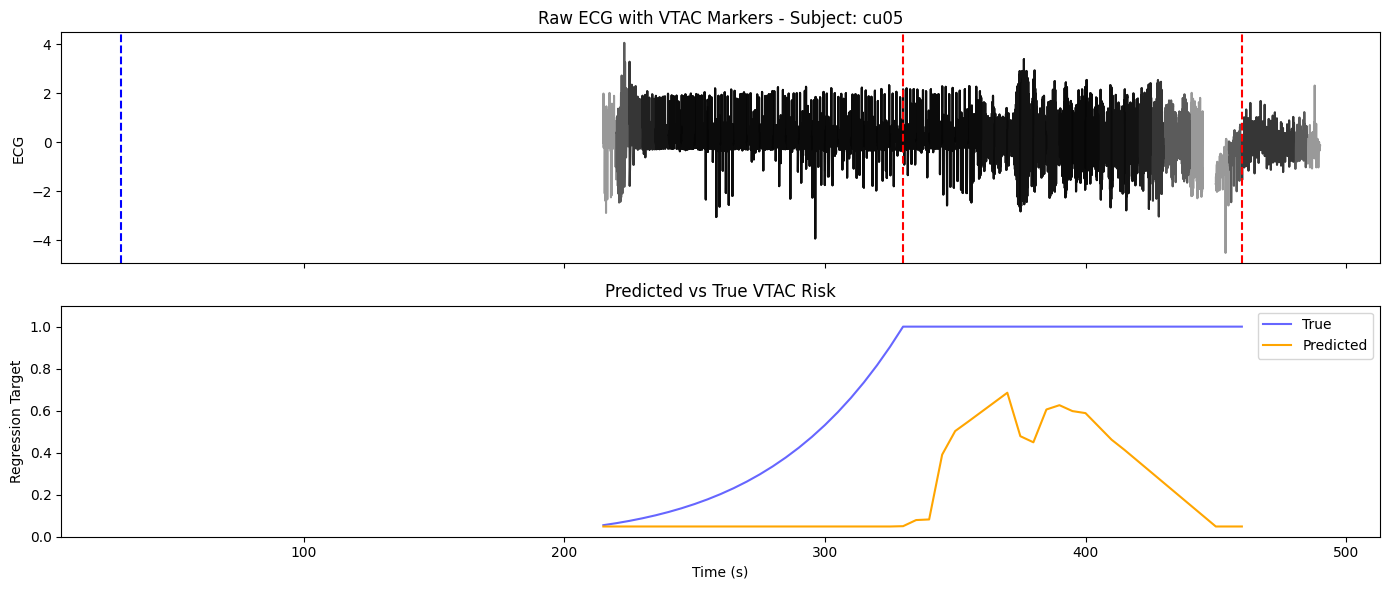

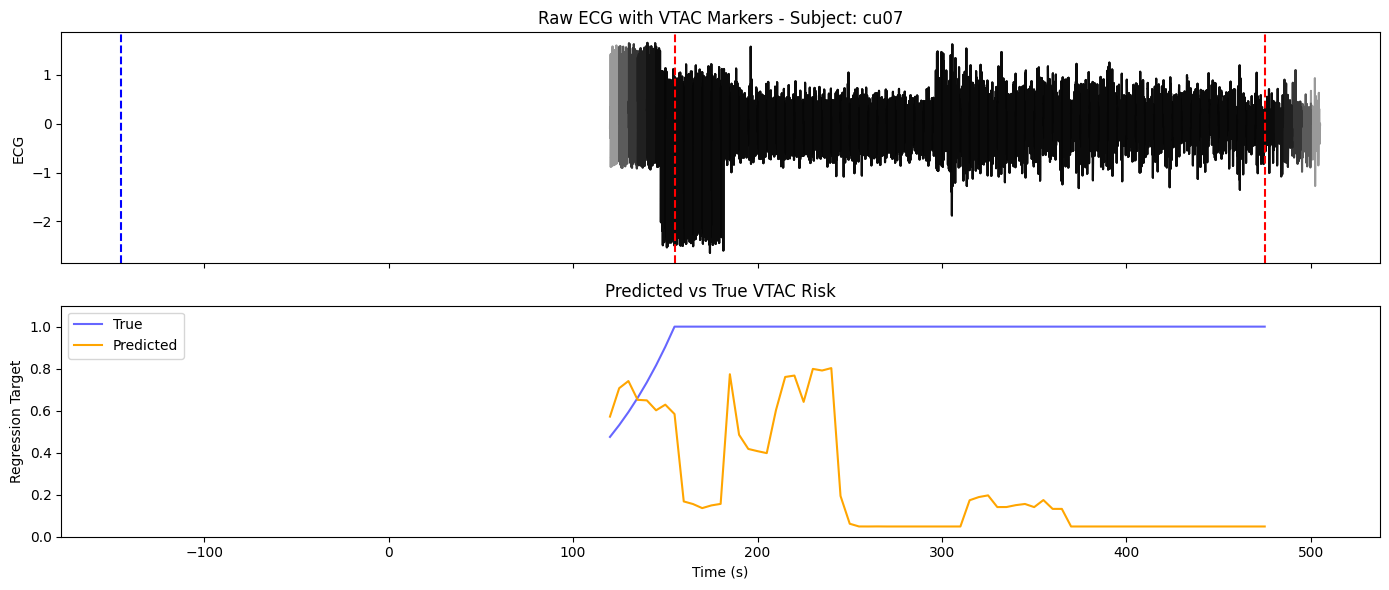

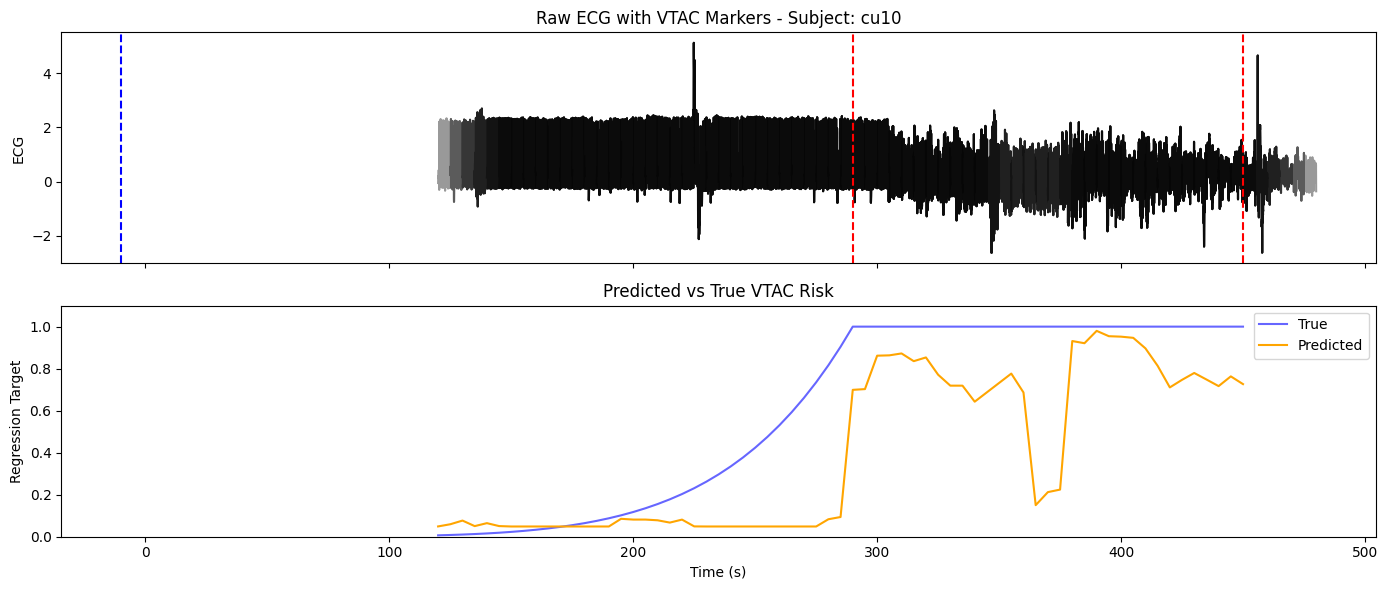

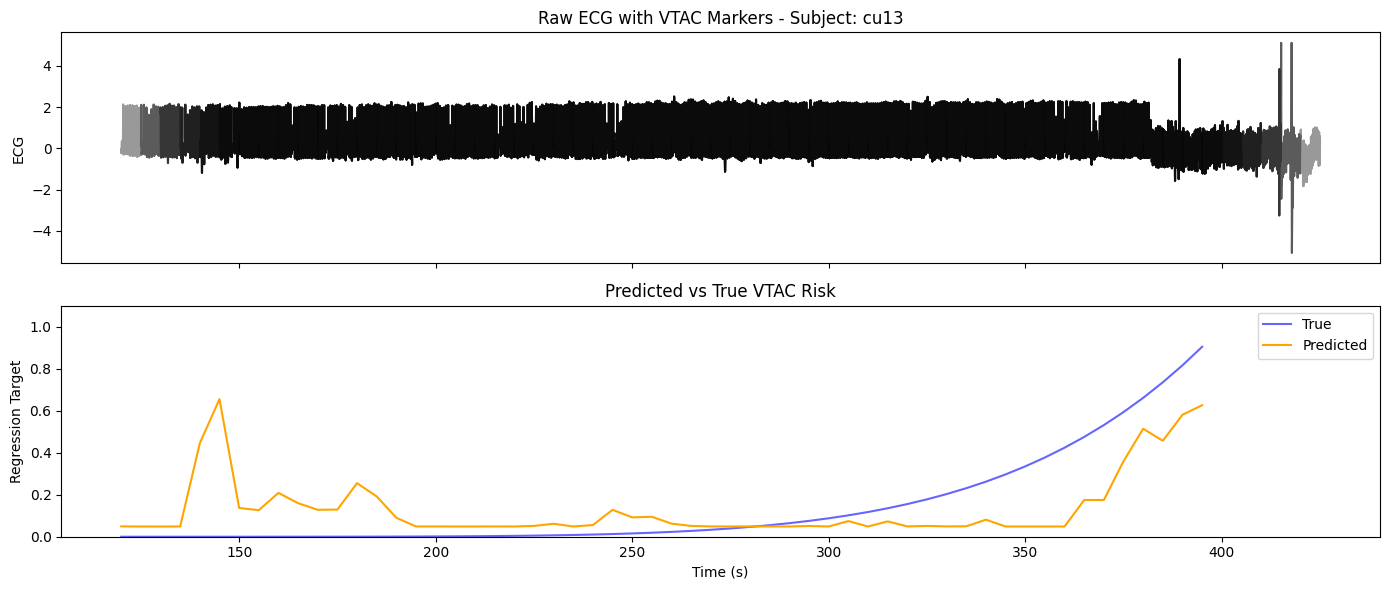

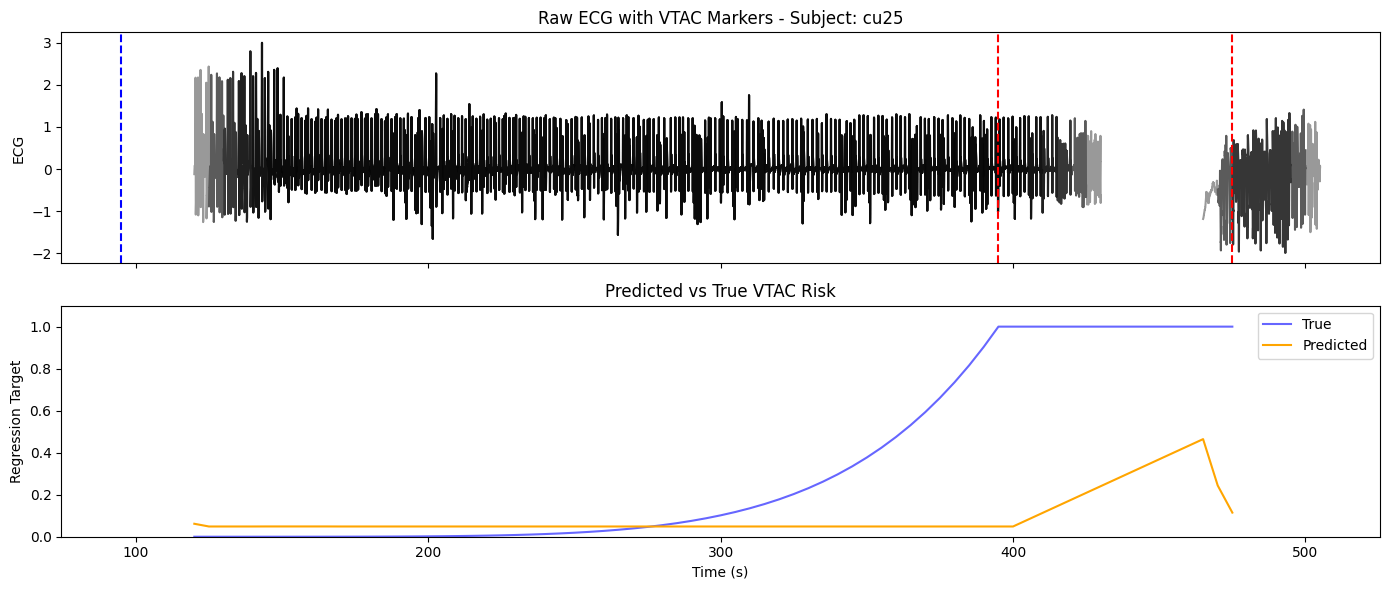

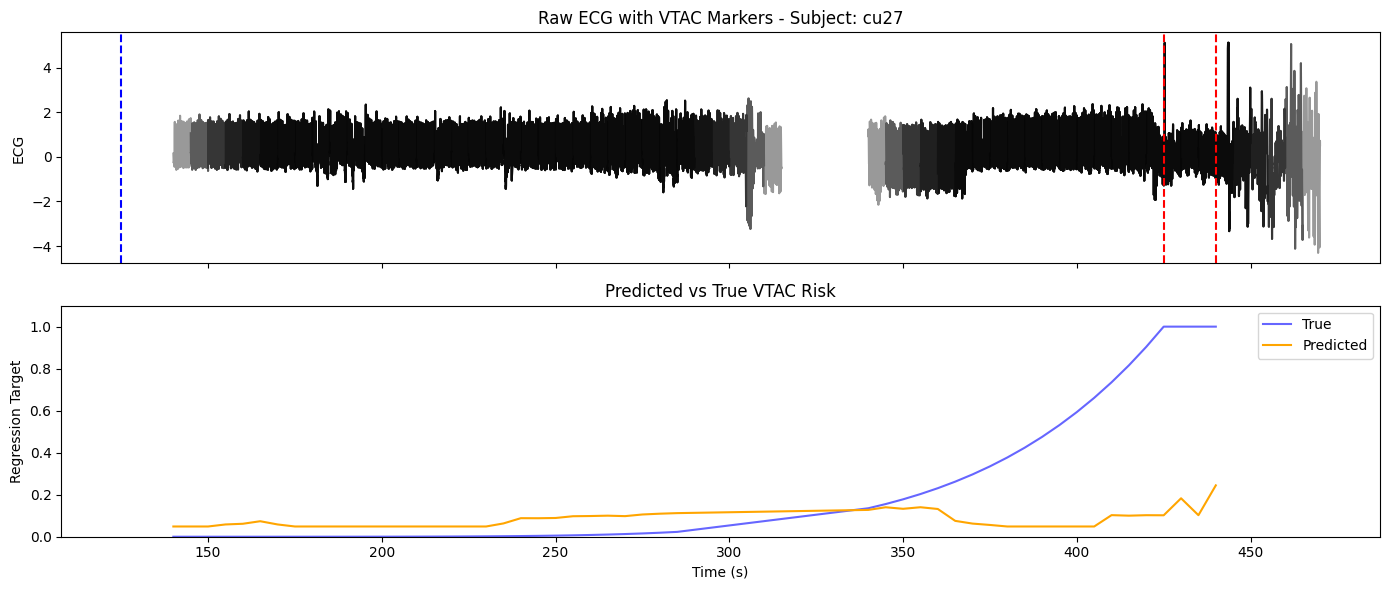

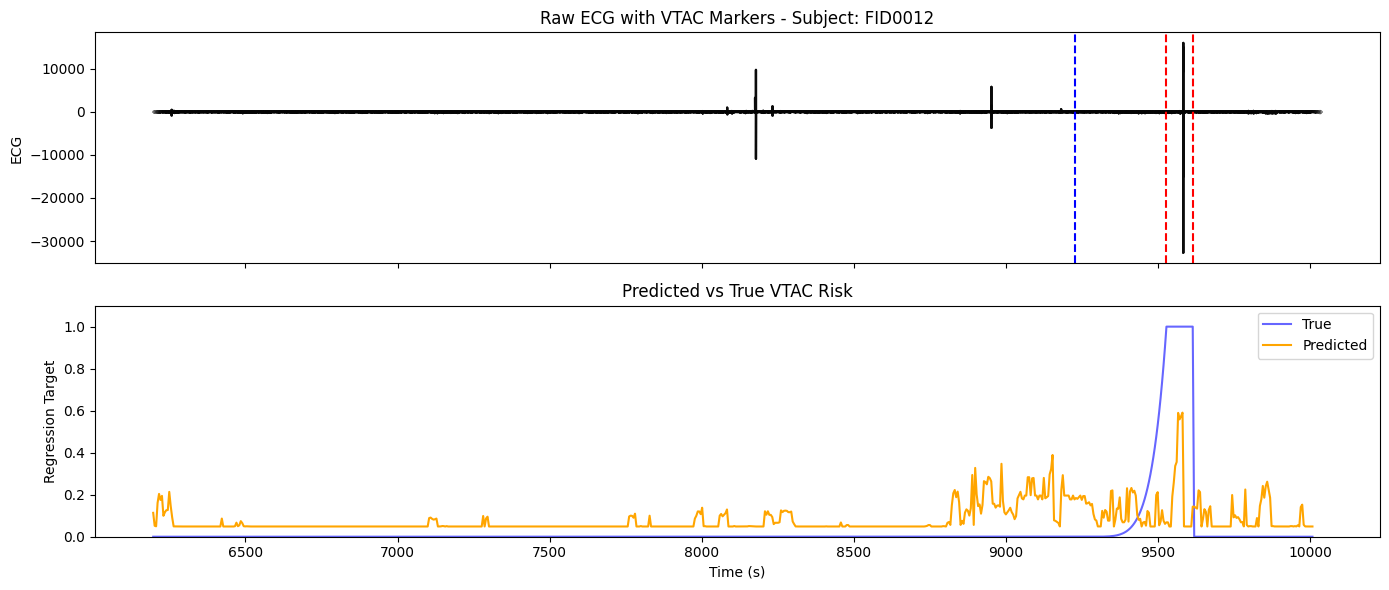


--- Fold 2 ---
RMSE (Train/Test): 0.2217 / 0.2752


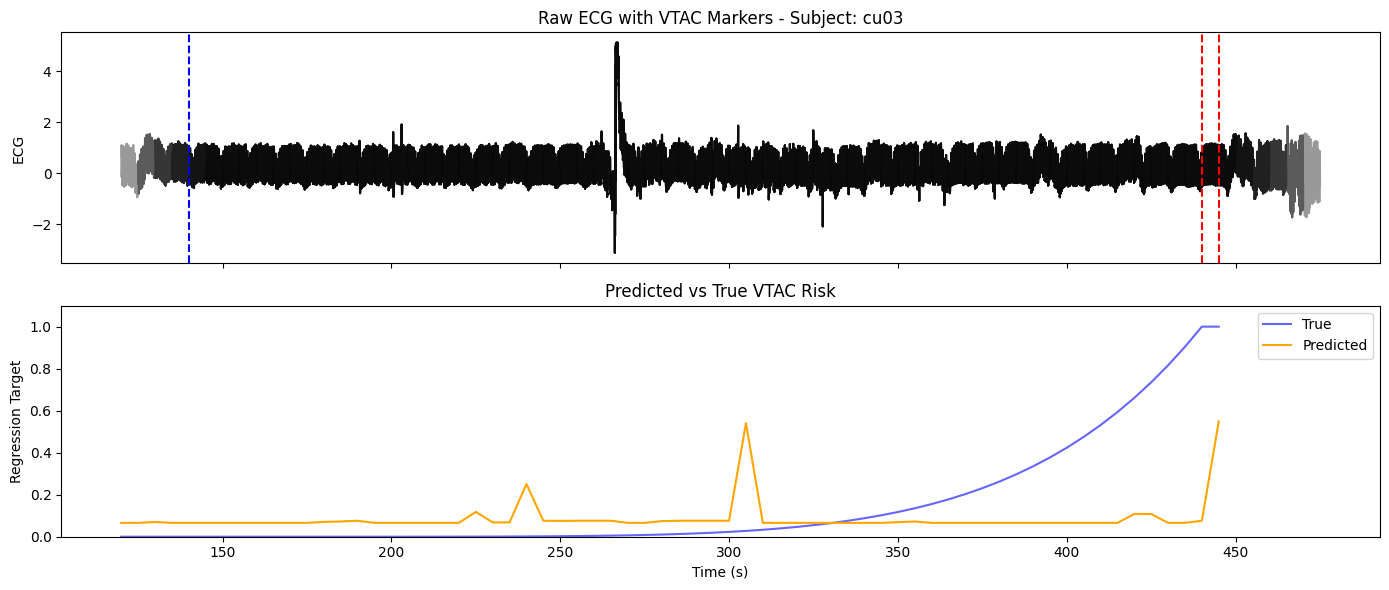

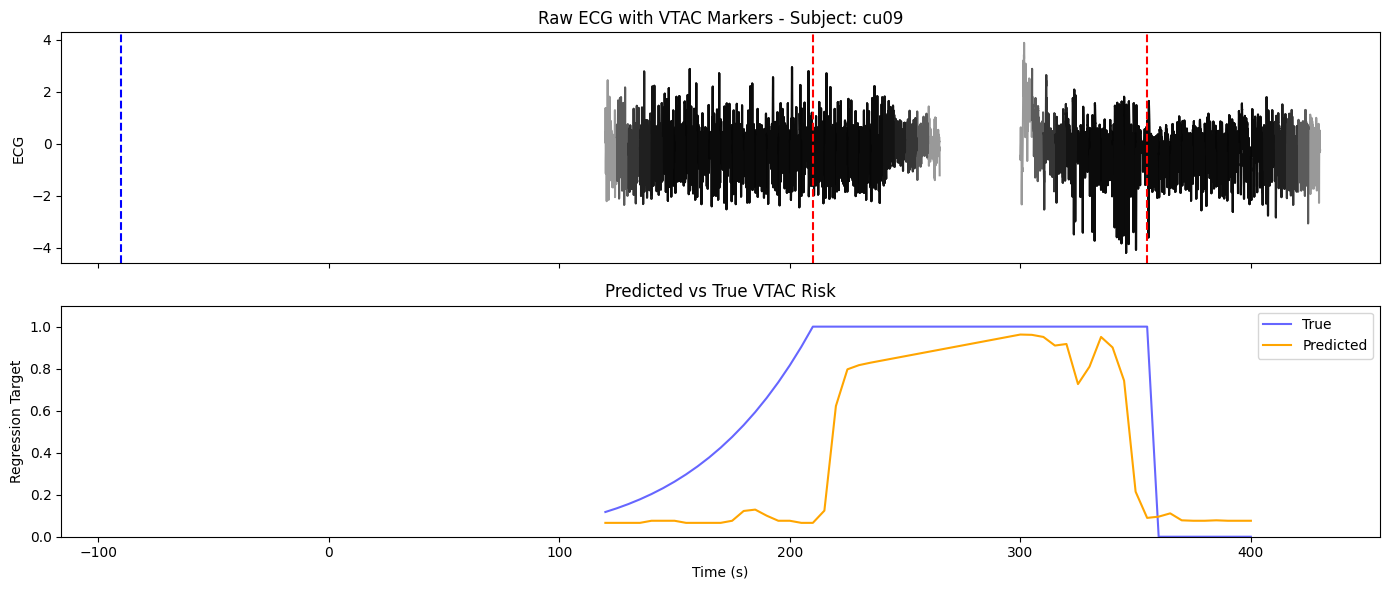

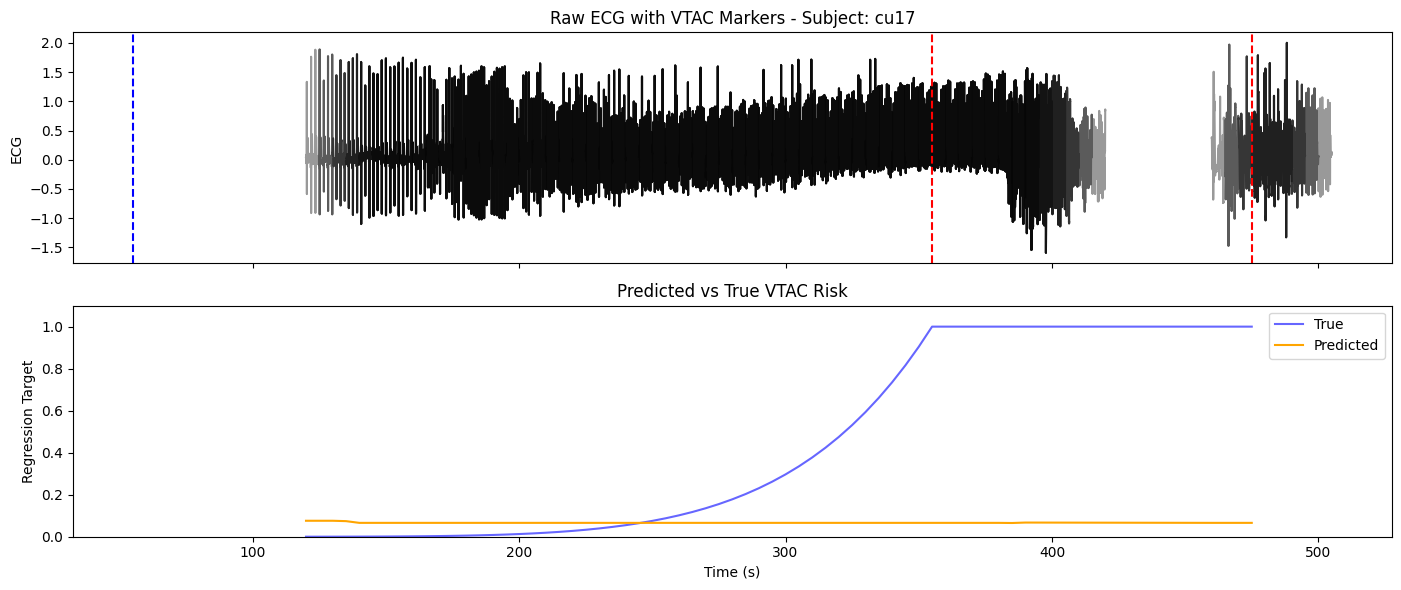

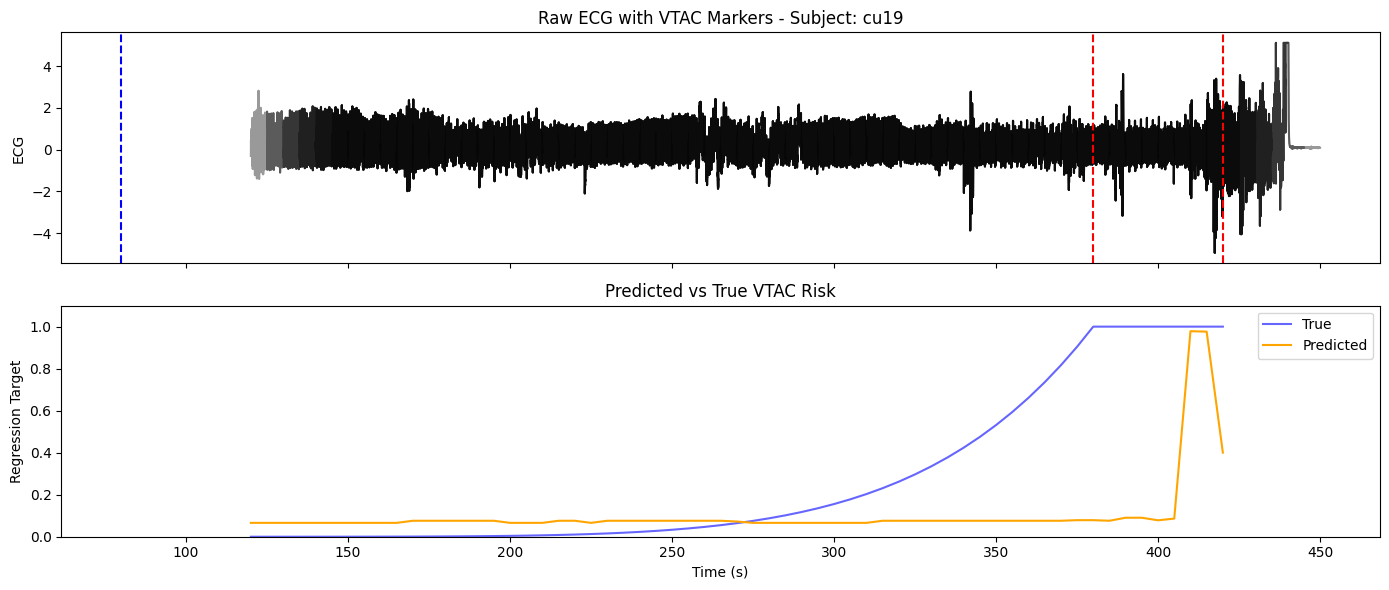

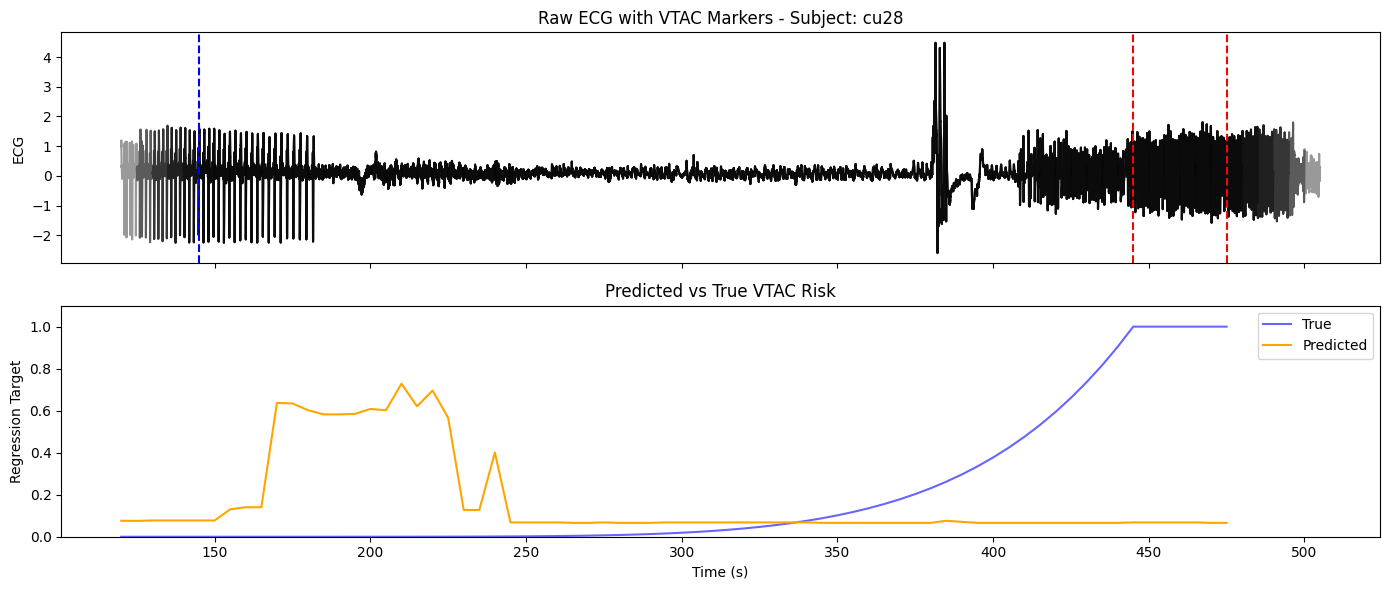

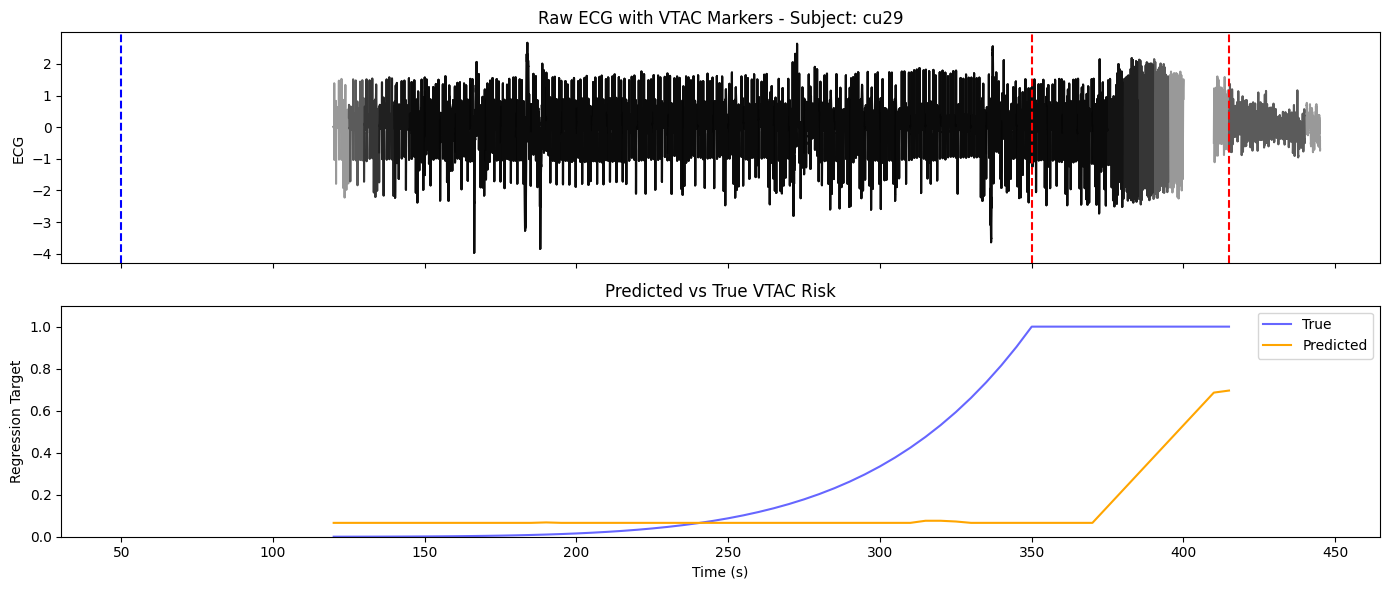

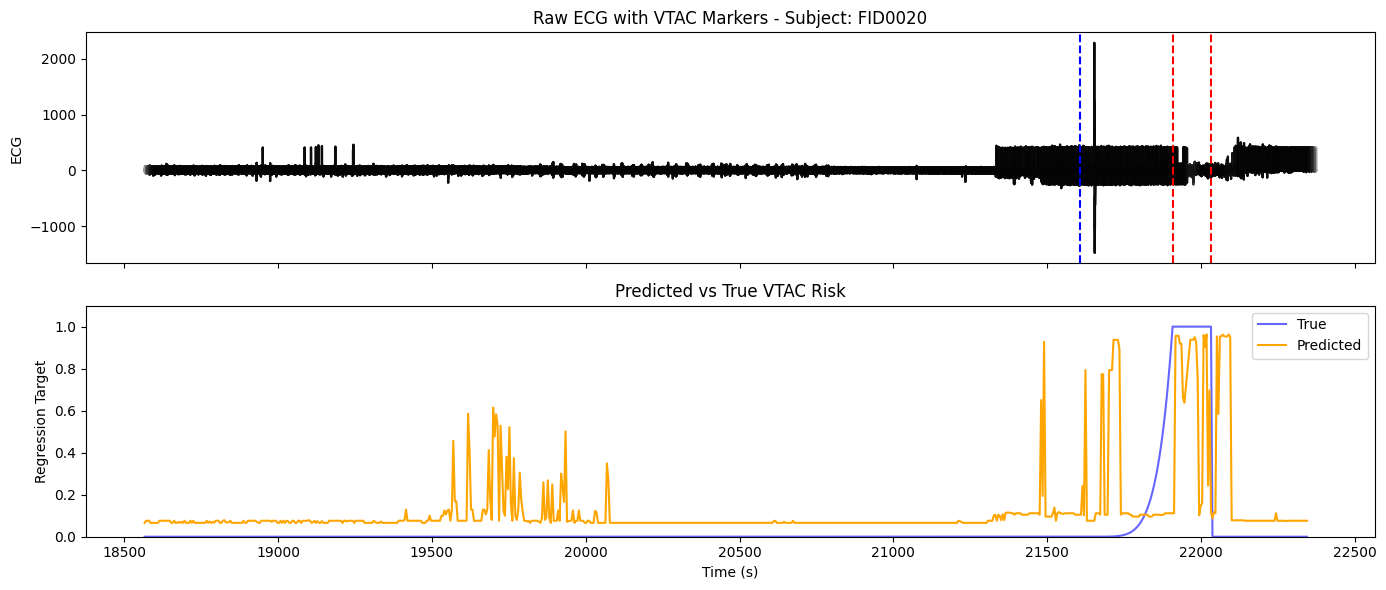


--- Fold 3 ---
RMSE (Train/Test): 0.2015 / 0.2538


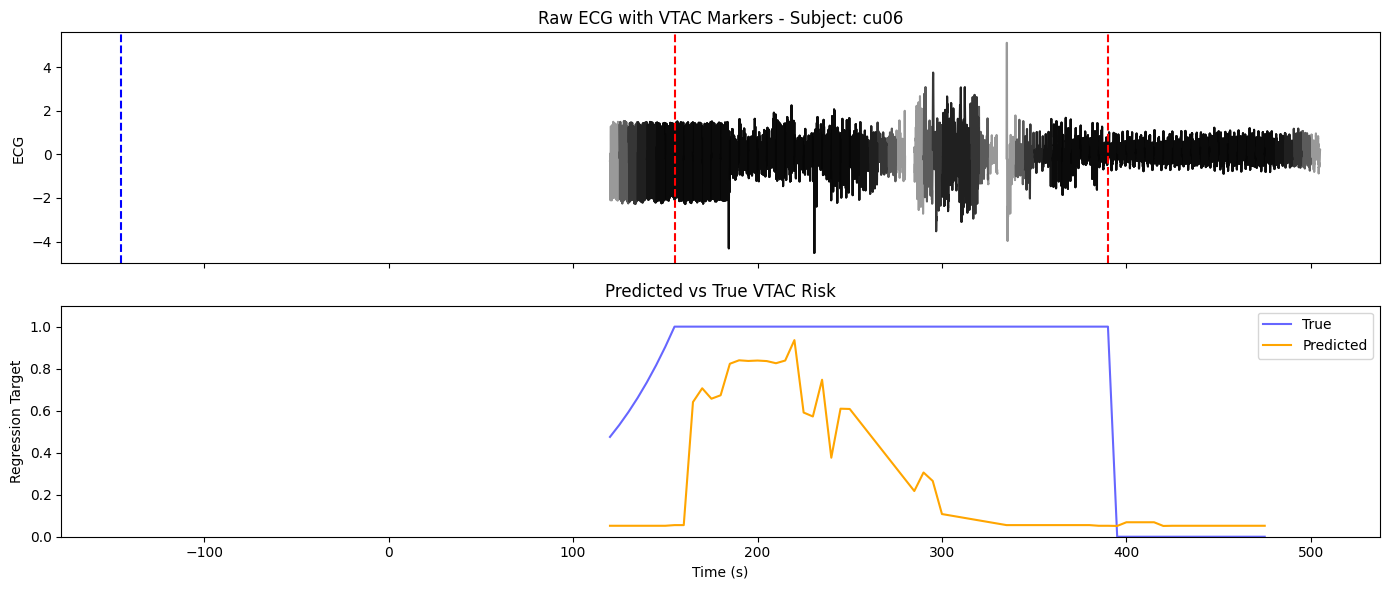

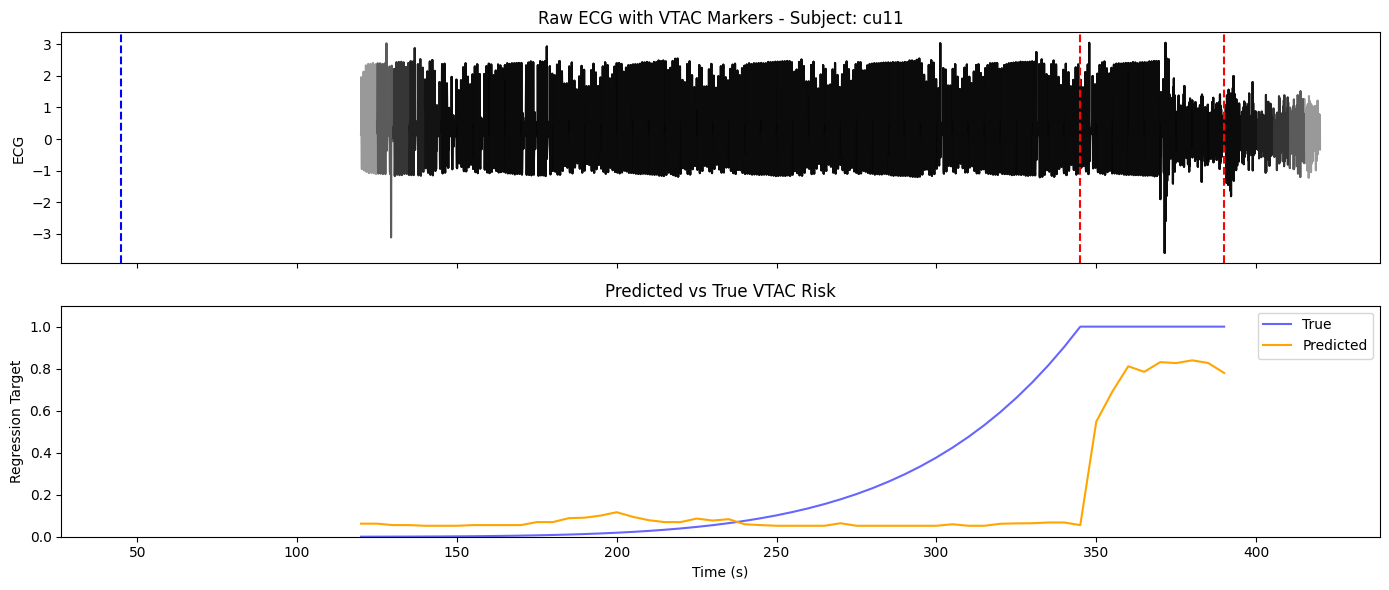

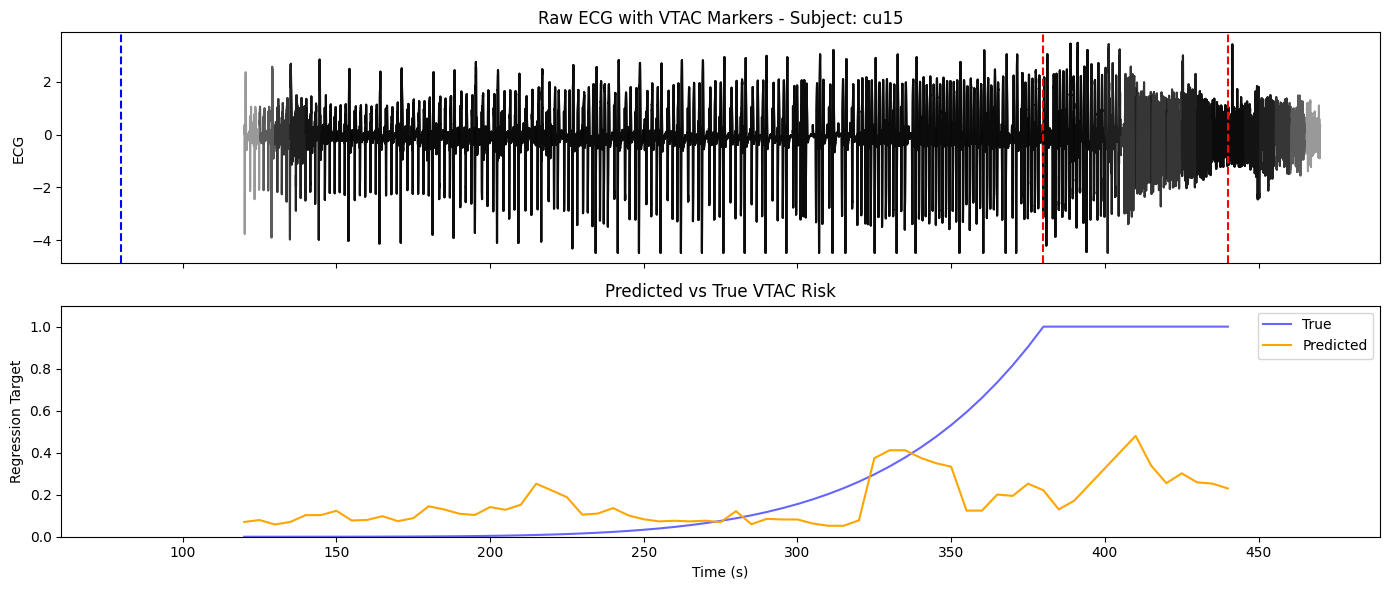

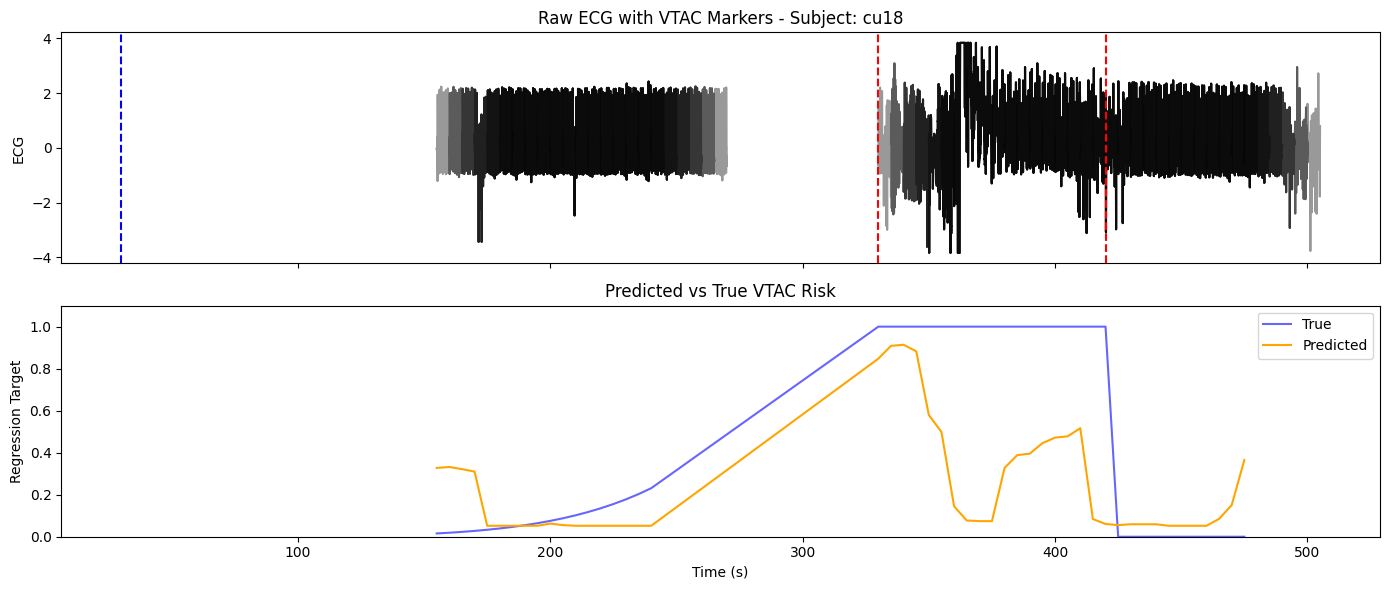

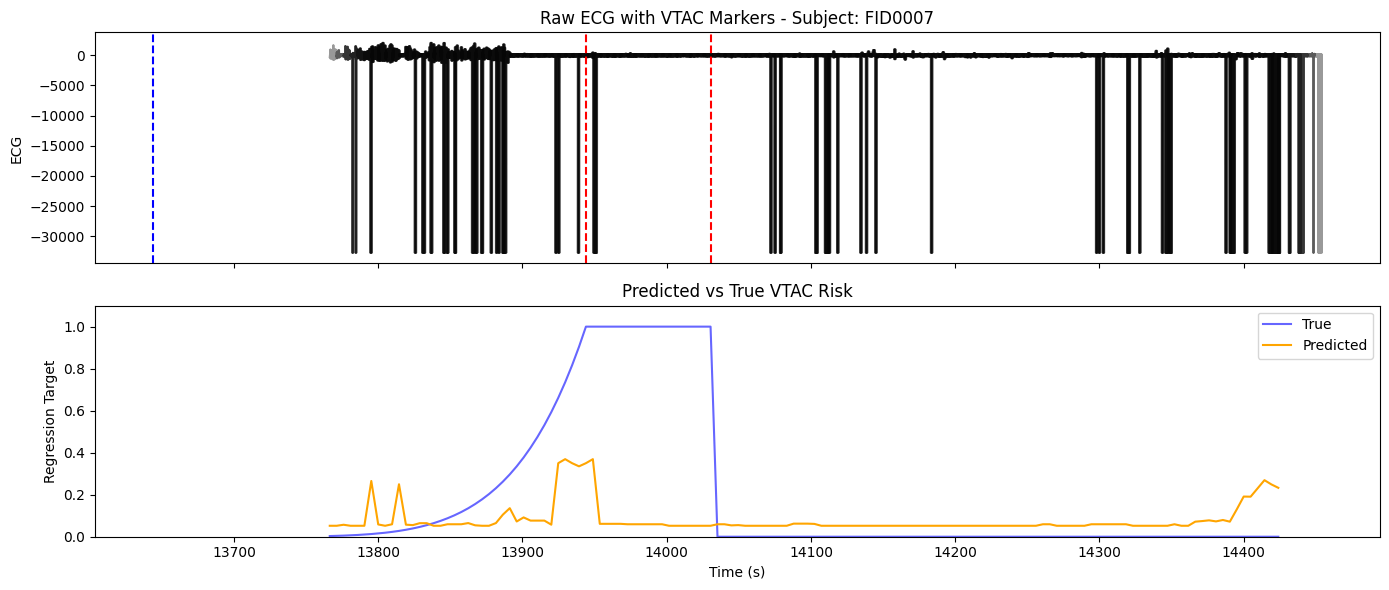

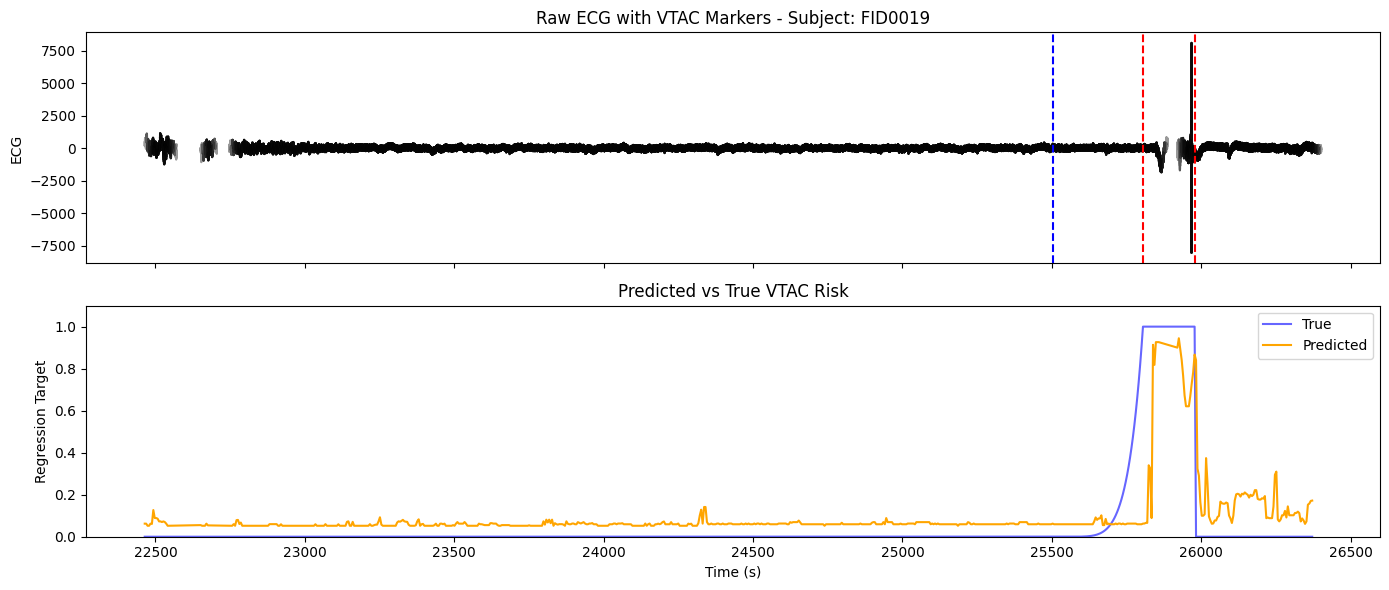


--- Fold 4 ---
RMSE (Train/Test): 0.2434 / 0.2198


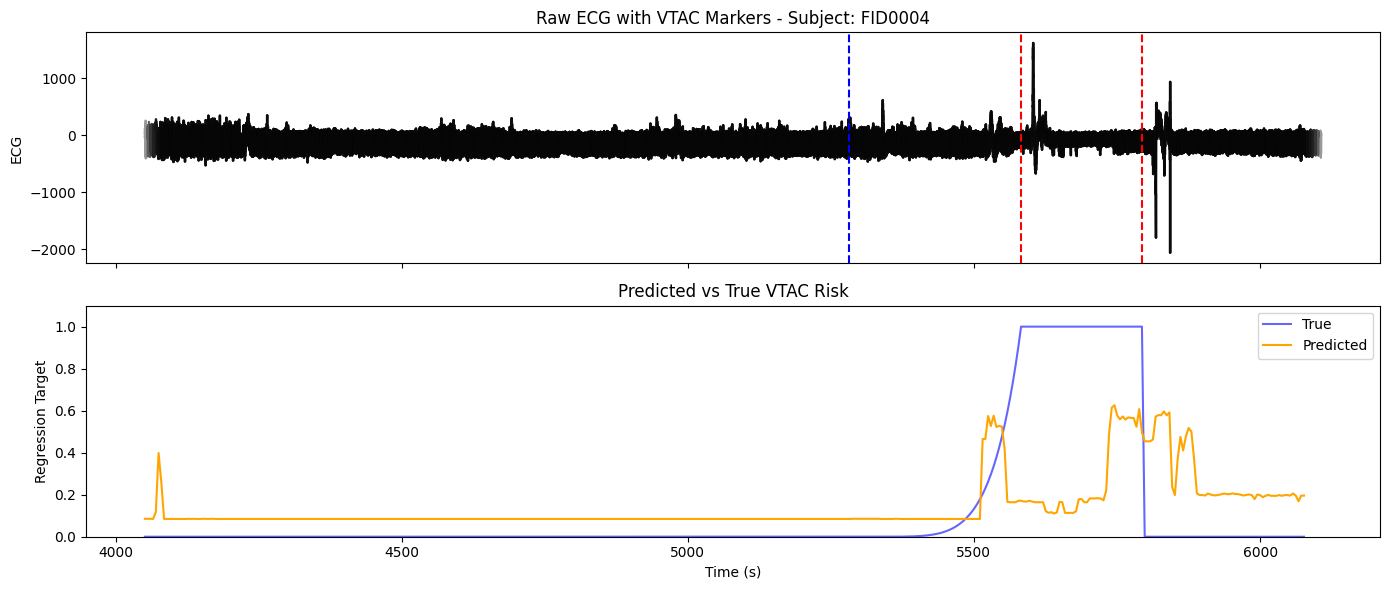

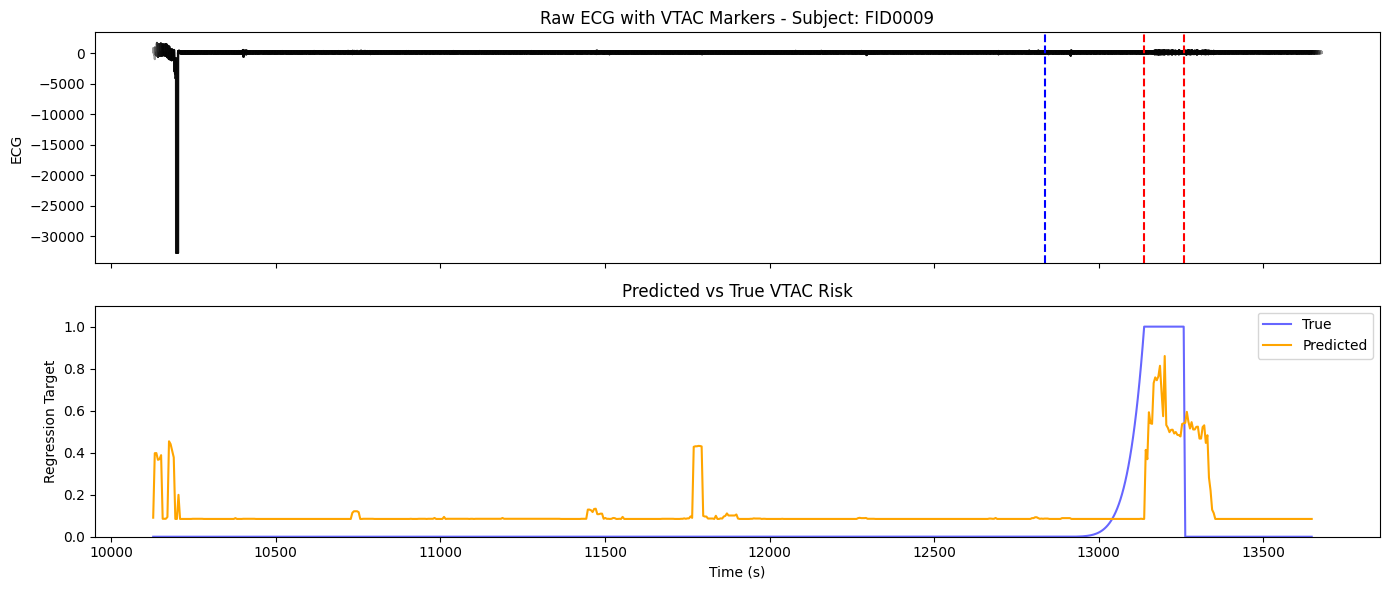


--- Fold 5 ---
RMSE (Train/Test): 0.2149 / 0.2140


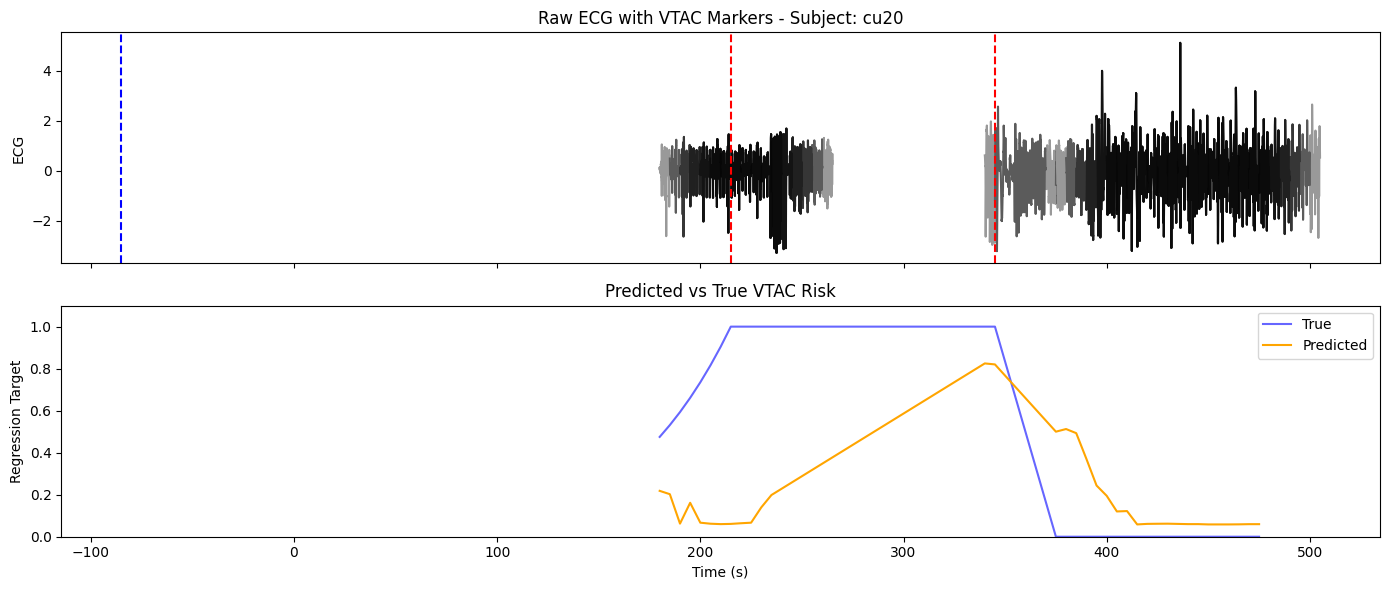

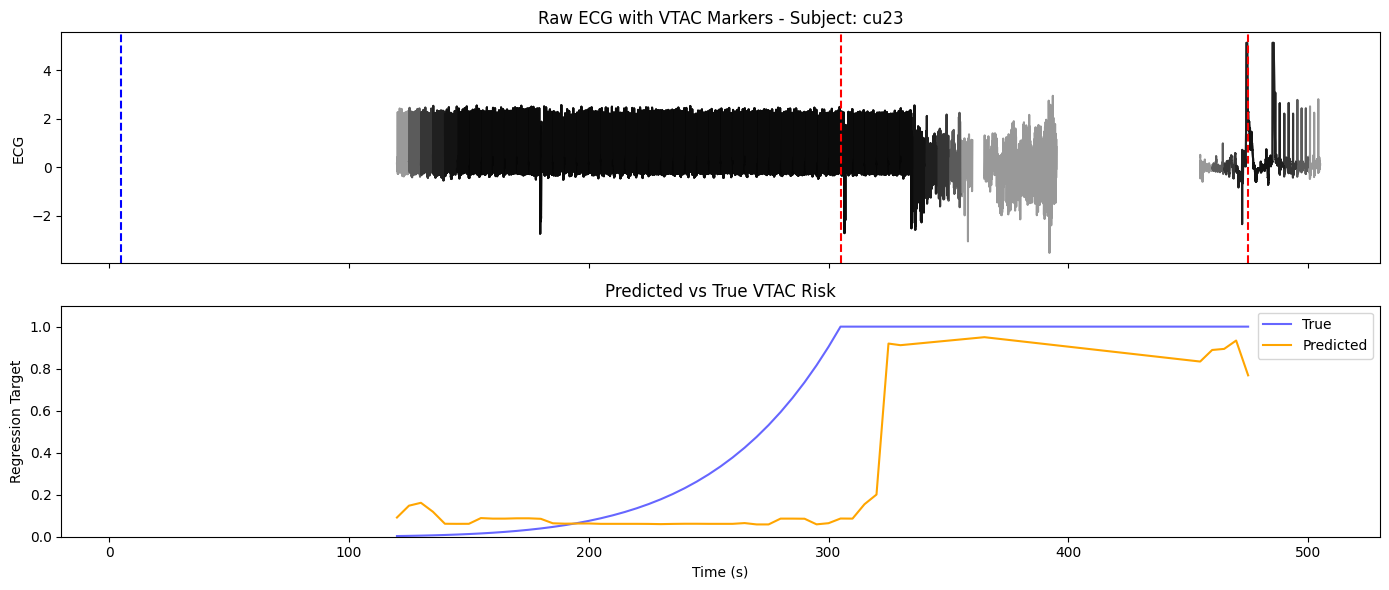

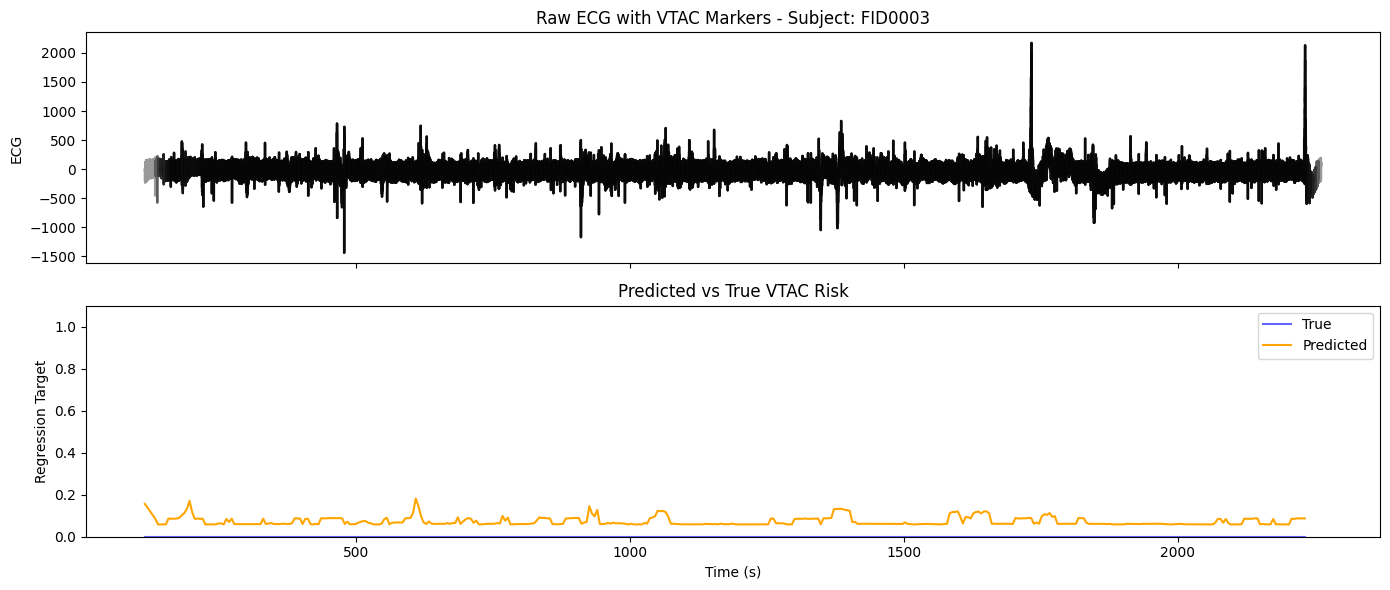

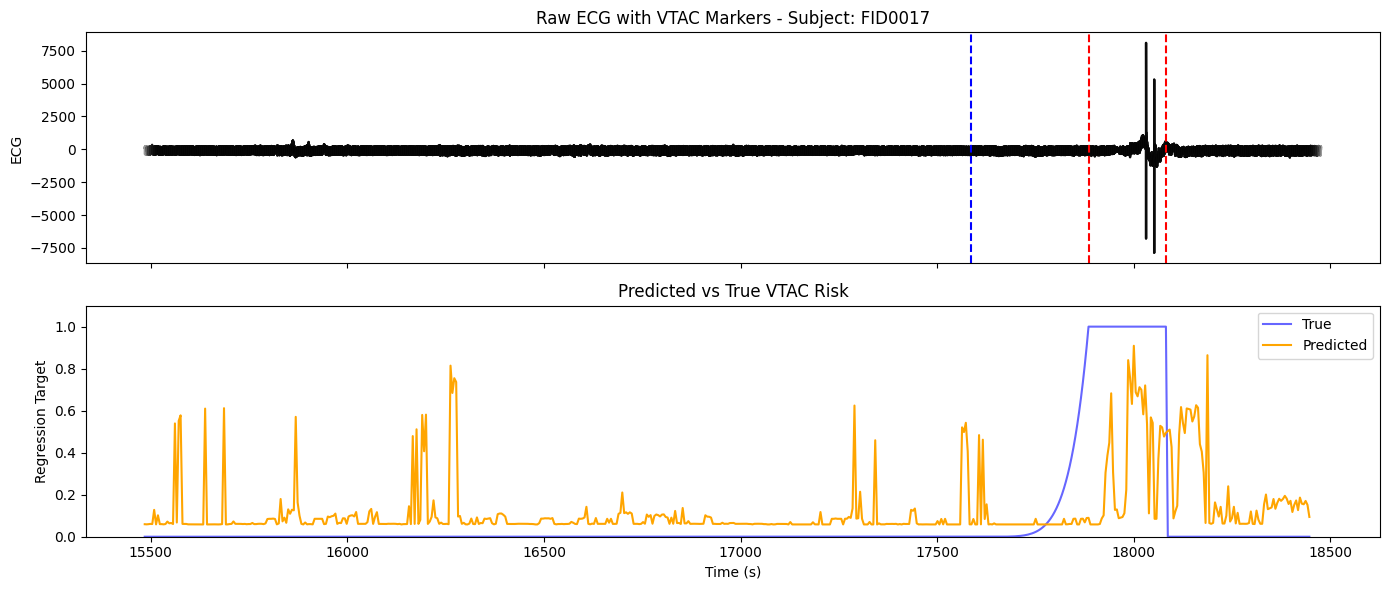

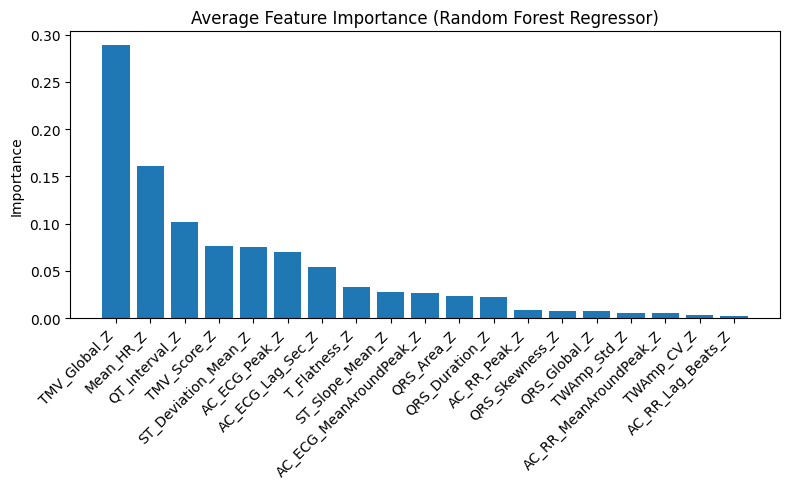

In [40]:
# --- Load your dataframe before running this ---
df = zscores_df.copy()
# --- Drop excluded subjects ---
excluded_subjects = ['cu01', 'cu02', 'cu04','cu12','cu14', 'cu21','cu24', 'cu30', 'cu31', 'cu33', 'cu34', 'cu35','cu16','cu26']
df = df[~df['Record'].isin(excluded_subjects)].copy()
# --- Regression Label: Exponential (t_norm^4) from 300s before VTAC ---
def get_sampling_rate(record_id):
    if str(record_id).startswith("FID"):
        return 240
    else:
        return 250
    
sigmoid_seconds = 300
df['VTAC_Label_Regression'] = 0.0

for record_id in df['Record'].unique():

    fs = get_sampling_rate(record_id)
    sigmoid_samples = int(sigmoid_seconds * fs)

    subj_idx = df['Record'] == record_id
    subj_df = df.loc[subj_idx]

    vtac_rows = subj_df[subj_df['VTAC_Label'] == 1]
    if vtac_rows.empty:
        continue

    vtac_start = vtac_rows['Start'].min()

    # --- Pre-VTAC window ---
    start_min = max(0, vtac_start - sigmoid_samples)

    pre_mask = (
        subj_idx &
        (df['Start'] >= start_min) &
        (df['Start'] < vtac_start)
    )

    # distance (in samples) to VTAC
    i = vtac_start - df.loc[pre_mask, 'Start'].values

    # time in seconds
    t = -i / fs

    # normalize to [0, 1]
    t_norm = (t + sigmoid_seconds) / sigmoid_seconds

    # your slow→fast ramp
    df.loc[pre_mask, 'VTAC_Label_Regression'] = t_norm ** 6

    # --- During VTAC ---
    df.loc[
        subj_idx & (df['VTAC_Label'] == 1),
        'VTAC_Label_Regression'
    ] = 1.0

# --- Define features and drop NaNs ---
df = df.dropna(subset=features + ['VTAC_Label_Regression', 'Record'])

# --- ML Inputs ---
X = df[features].values
y = df['VTAC_Label_Regression'].values
groups = df['Record'].astype(str).values


# --- Cross-validation setup ---
gkf = GroupKFold(n_splits=5)
all_preds, all_true, all_indices = [], [], []
feature_importances = np.zeros(len(features))

fold_num = 1
for train_idx, test_idx in gkf.split(X, y, groups):
    print(f"\n--- Fold {fold_num} ---")
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    test_records = df.iloc[test_idx]['Record'].unique()

    # --- Randomized Search for Regressor ---
    param_dist = {
        'n_estimators': [50, 100, 200, 300],  
        'max_depth': [3, 5, 7],
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5)
    }
    base_model = RandomForestRegressor(random_state=42)
    search = RandomizedSearchCV(base_model, param_distributions=param_dist, n_iter=20, cv=3,
                                scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    model = search.best_estimator_

    # --- Predict ---
    preds_test = model.predict(X_test)
    preds_test = medfilt(preds_test, kernel_size=5)   # smooth test predictions

    preds_train = model.predict(X_train)
    preds_train = medfilt(preds_train, kernel_size=5)   # smooth test predictions


    all_preds.extend(preds_test)
    all_true.extend(y_test)
    all_indices.extend(test_idx)

    rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))

    # --- Report Pearson Correlation ---
    #print(f"Pearson r (Train/Test): {pearsonr(y_train, preds_train)[0]:.3f} / {pearsonr(y_test, preds_test)[0]:.3f}")
    print(f"RMSE (Train/Test): {rmse_train:.4f} / {rmse_test:.4f}")
    feature_importances += model.feature_importances_


    # --- Plot per Subject ---
    for subject_id in test_records:
        subject_df = df.iloc[test_idx].copy()
        subject_df = subject_df[subject_df['Record'] == subject_id].copy()
        subject_df = subject_df.sort_values('Start')
        X_sub = subject_df[features].values
        subject_df['Prediction'] = model.predict(X_sub)

        fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

        # --- Top: Raw ECG ---
        for _, row in subject_df.iterrows():
            if isinstance(row['ECG_Raw'], list) and len(row['ECG_Raw']) > 0:
                t = np.linspace(row['Start'] / sampling_rate,
                                (row['Start'] + sampling_rate * 30) / sampling_rate,
                                len(row['ECG_Raw']))
                axs[0].plot(t, row['ECG_Raw'], color='black', alpha=0.4)

        # --- VTAC markers from original VTAC_Label ---
        vtac_rows = subject_df[subject_df['VTAC_Label'] == 1]
        if not vtac_rows.empty:
            vtac_start = vtac_rows['Start'].min() / sampling_rate
            vtac_end = vtac_rows['Start'].max() / sampling_rate
            axs[0].axvline(vtac_start, color='red', linestyle='--')
            axs[0].axvline(vtac_end, color='red', linestyle='--')
            axs[0].axvline(vtac_start - sigmoid_seconds, color='blue', linestyle='--')  # 60s early marker

        axs[0].set_title(f"Raw ECG with VTAC Markers - Subject: {subject_id}")
        axs[0].set_ylabel("ECG")

        # --- Bottom: Regression Predictions vs Ground Truth ---
        axs[1].plot(subject_df['Start'] / sampling_rate, subject_df['VTAC_Label_Regression'],
                    label="True", color='blue', alpha=0.6)
        axs[1].plot(subject_df['Start'] / sampling_rate, subject_df['Prediction'],
                    label="Predicted", color='orange')
        axs[1].legend()
        axs[1].set_ylabel("Regression Target")
        axs[1].set_xlabel("Time (s)")
        axs[1].set_title("Predicted vs True VTAC Risk")
        axs[1].set_ylim(0, 1.1)


        plt.tight_layout()
        plt.show()

    fold_num += 1

# --- Feature Importance ---
feature_importances /= gkf.get_n_splits()
plt.figure(figsize=(8, 5))
sorted_idx = np.argsort(feature_importances)[::-1]
plt.bar(range(len(features)), feature_importances[sorted_idx])
plt.xticks(range(len(features)), [features[i] for i in sorted_idx], rotation=45, ha='right')
plt.title("Average Feature Importance (Random Forest Regressor)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

### Train and Save Final VTAC Random Forest & XGBoost Regression Models

In [41]:
# --- Train Final Random Forest Model on Full Data ---
rf_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}
rf_model = RandomForestRegressor(random_state=42)
rf_search = RandomizedSearchCV(rf_model, param_distributions=rf_param_dist, n_iter=20, cv=3,
                               scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
rf_search.fit(X, y)
rf_best = rf_search.best_estimator_

# Save model
model_path = os.path.join("model", "random_forest_vtac_model_regression.joblib")
joblib.dump(rf_best, model_path)
print(f"✅ Random Forest model saved to '{model_path}'")


xgb_param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(1, 2)
}
xgb_model = XGBRegressor(random_state=42, verbosity=0, eval_metric='rmse')
xgb_search = RandomizedSearchCV(xgb_model, param_distributions=xgb_param_dist, n_iter=20, cv=3,
                                scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
xgb_search.fit(X, y)
xgb_best = xgb_search.best_estimator_

# Save model
model_path = os.path.join("model", "xgboost_vtac_model_regression.joblib")
joblib.dump(xgb_best, model_path)
print(f"✅ XGBoost model saved to '{model_path}'")

✅ Random Forest model saved to 'model/random_forest_vtac_model_regression.joblib'
✅ XGBoost model saved to 'model/xgboost_vtac_model_regression.joblib'
